# Introduction

In this notebook we are trying to analyze and predict the evolution of the European population with a special focus on migration.
The Notebook is divided into 3 sections.

The name in the bracket indicates the responsible person for the topic.

1. General Development of the European Population over Time 

2. Migration 

3. Predictions:

    3.1. For population Growth 
    
    3.2. For Migrations

# Imports

In [327]:
#please install the dependencies first

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import pycountry
import re
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from math import sqrt, ceil, floor
from itertools import combinations, product
import logging

# Loading Datasets

In [328]:
DATA_DIRECTORY = 'datasets' #directory where data sets are stored

#dictionary of datasets where key is name of file (without .csv extension) and value is a df
data_frames = {}

for dirname, _, filenames in os.walk(DATA_DIRECTORY):
    for filename in filenames:
        sep = ','
        if filename[-3:] == 'tsv': #support for .tsv files
            sep = '\t'
        data_frames[filename[:-4]] = pd.read_csv(os.path.join(dirname, filename), low_memory=False, sep=sep)


# 1. General Development of the European Population over Time
Our main question here is how has the european population developed over time, and more interestingly, are there any reasons or drivers of change identifiable? Finally we will also try find correlations of the population growth with other statistics of countries.

## Utility Functions

Here we define some generic functions that perform common tasks

In [329]:
# Function that removes all columns of a df where each row has the same value
# does not modify original df
def remove_single_value_cols(df: pd.DataFrame):
    cols = df.columns
    to_remove = []
    for c in cols:
        if len(df[c].unique()) <= 1:
            to_remove.append(c)
    
    return df.drop(columns=to_remove)

#Min max normalizes a given series and returns the result.
def normalize_series(s: pd.Series):
    return (s - s.min()) / (s.max() - s.min())

## Dataset Preparation

We are going to use the UN World Population Dataset as it contains lots of interesting data (such as population density, mortality, life expectancy, etc.) in addition to a big timespan of population numbers.
For the second sub-question we are going to look at the following statistics: crime rate, GDP, HDI, employment rate, to see if they play a role in the population change. Of course there are many more potential factors, but in order to keep the work load managable for this project we focus on these.

Links to sources:
- https://population.un.org/wpp/downloads
- https://ec.europa.eu/eurostat/databrowser/view/crim_off_cat/default/table?lang=en&category=crim.crim_off
- https://ec.europa.eu/eurostat/databrowser/view/tec00114__custom_15075010/default/table?lang=en
- https://globaldatalab.org/shdi/table/shdi/
- https://ec.europa.eu/eurostat/databrowser/view/lfsq_ergaed/default/table?lang=en&category=labour.employ.lfsq.lfsq_emprt

### UN World Population

Steps:
- Reduce date range from 1950-2100 to 1950-2023 (as future are only predictions)
- Remove countries outside of europe
- Remove unnecessary columns
- Check missing values and handle them


In [330]:
un_world_pop_df = data_frames["WPP2024_Demographic_Indicators_Medium"] #Get Dataframe from dictionary
un_world_pop_predictions_df = un_world_pop_df[un_world_pop_df['Time'] >= 2024] #keep predictions for later use
un_world_pop_df = un_world_pop_df[un_world_pop_df['Time'] < 2024] #Remove future predictions

#Remove countries outside of europe
eur_countries = [
    'Armenia',
    'Azerbaijan',
    'Cyprus',
    'Georgia',
    'Türkiye',
    'Belarus',
    'Bulgaria',
    'Czechia',
    'Hungary',
    'Poland',
    'Republic of Moldova',
    'Romania',
    'Russian Federation',
    'Slovakia',
    'Ukraine',
    'Denmark',
    'Estonia',
    'Finland',
    'Iceland',
    'Ireland',
    'Latvia',
    'Lithuania',
    'Norway',
    'Sweden',
    'United Kingdom',
    'Albania',
    'Andorra',
    'Bosnia and Herzegovina',
    'Croatia',
    'Greece',
    'Italy',
    'Kosovo (under UNSC res. 1244)',
    'Malta',
    'Montenegro',
    'North Macedonia',
    'Portugal',
    'San Marino',
    'Serbia',
    'Slovenia',
    'Spain',
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Liechtenstein',
    'Luxembourg',
    'Monaco',
    'Netherlands',
    'Switzerland'
]
un_world_pop_df = un_world_pop_df[un_world_pop_df['Location'].isin(eur_countries)]

#Remove unnecessary columns
un_world_pop_df = remove_single_value_cols(un_world_pop_df)
un_world_pop_df = un_world_pop_df.drop(columns=['SortOrder', 'LocID', 'Notes', 'SDMX_code', 'ParentID']) #only keep ISO codes from IDs


In [331]:
print(un_world_pop_df.isnull().sum()) #Only DoublingTime has null values and it's not of interest, therefore we remove it
un_world_pop_df = un_world_pop_df.drop(columns=['DoublingTime'])

display(un_world_pop_df)

ISO3_code                    0
ISO2_code                    0
Location                     0
Time                         0
TPopulation1Jan              0
TPopulation1July             0
TPopulationMale1July         0
TPopulationFemale1July       0
PopDensity                   0
PopSexRatio                  0
MedianAgePop                 0
NatChange                    0
NatChangeRT                  0
PopChange                    0
PopGrowthRate                0
DoublingTime              1564
Births                       0
Births1519                   0
CBR                          0
TFR                          0
NRR                          0
MAC                          0
SRB                          0
Deaths                       0
DeathsMale                   0
DeathsFemale                 0
CDR                          0
LEx                          0
LExMale                      0
LExFemale                    0
LE15                         0
LE15Male                     0
LE15Fema

ISO3_code ISO2_code     Location  Time  TPopulation1Jan  \
59736       ARM        AM      Armenia  1950         1366.292   
59737       ARM        AM      Armenia  1951         1399.497   
59738       ARM        AM      Armenia  1952         1435.070   
59739       ARM        AM      Armenia  1953         1473.143   
59740       ARM        AM      Armenia  1954         1514.012   
...         ...       ...          ...   ...              ...   
70749       CHE        CH  Switzerland  2019         8546.621   
70750       CHE        CH  Switzerland  2020         8608.427   
70751       CHE        CH  Switzerland  2021         8672.736   
70752       CHE        CH  Switzerland  2022         8741.311   
70753       CHE        CH  Switzerland  2023         8843.053   

       TPopulation1July  TPopulationMale1July  TPopulationFemale1July  \
59736          1382.895               661.922                 720.972   
59737          1417.284               679.400                 737.884   
59738          1454.107               698.083                 756.024   
59739          1493.578               718.080                 775.498   
59740          1535.978               739.532                 796.446   
...                 ...                   ...                     ...   
70749          8577.524              4254.229                4323.295   
70750          8640.582              4287.099                4353.482   
70751          8707.024              4321.808                4385.215   
70752          8792.182              4365.224                4426.958   
70753          8870.561              4405.222                4465.340   

       PopDensity  PopSexRatio  ...  Q0060Male  Q0060Female     Q1550  \
59736     48.5840      91.8097  ...   455.2814     342.0190  139.7836   
59737     49.7921      92.0740  ...   447.9709     335.2508  136.6926   
59738     51.0858      92.3362  ...   440.7845     328.5563  133.7153   
59739     52.4725      92.5959  ...   433.7307     321.9023  130.8284   
59740     53.9621      92.8541  ...   426.8461     315.2667  128.0046   
...           ...          ...  ...        ...          ...       ...   
70749    214.4810      98.4025  ...    59.0600      36.3589   17.6110   
70750    216.0577      98.4752  ...    61.9708      36.8884   18.5746   
70751    217.7191      98.5541  ...    61.4653      36.9183   17.9207   
70752    219.8485      98.6055  ...    64.1373      36.5130   18.4351   
70753    221.8084      98.6537  ...    57.3421      34.3758   16.5532   

       Q1550Male  Q1550Female     Q1560  Q1560Male  Q1560Female  \
59736   175.3018     109.7487  253.4783   307.9124     199.1264   
59737   171.7993     106.9746  249.1156   303.4197     195.5144   
59738   168.3949     104.2450  244.6606   299.0196     191.9336   
59739   165.1062     101.5492  240.1689   294.7423     188.3682   
59740   161.9494      98.8778  235.7720   290.6166     184.8038   
...          ...          ...       ...        ...          ...   
70749    22.3172      12.7480   43.6186    54.6216      32.2486   
70750    23.5971      13.3797   44.8294    56.7746      32.4808   
70751    23.1479      12.5111   45.1217    56.8501      32.9935   
70752    24.3964      12.2436   45.9755    59.2810      32.1857   
70753    21.2650      11.6659   41.9024    53.0074      30.4383   

       NetMigrations    CNMR  
59736          9.013   6.517  
59737          9.309   6.568  
59738          9.722   6.686  
59739         10.131   6.783  
59740         10.608   6.906  
...              ...     ...  
70749         44.517   5.190  
70750         55.523   6.426  
70751         50.665   5.819  
70752         96.424  10.967  
70753         45.098   5.084  

[3626 rows x 57 columns]

### Police-recorded offences by offence category

Date range: 2008-2022

Steps:
- Remove unnecessary columns
- Fix data types
- Consolidate crime categories
- Consolidate british regions to UK
- Check missing values and handle them


In [332]:
estat_crim_off_cat = data_frames['estat_crim_off_cat']

#Set proper Null values
estat_crim_off_cat = estat_crim_off_cat.replace({": ": None})

#Unfold first column
estat_crim_off_cat[['freq', 'iccs', 'unit', 'country']] = estat_crim_off_cat['freq,iccs,unit,geo\TIME_PERIOD'].str.split(',', expand=True)

#Remove unnecessary columns
estat_crim_off_cat = estat_crim_off_cat.drop(columns=['freq,iccs,unit,geo\TIME_PERIOD', 'freq'])

#Only use "per 100 000 inhabitants" as unit and remove absolute numbers
estat_crim_off_cat = estat_crim_off_cat[estat_crim_off_cat['unit'] == 'P_HTHAB']

#Fix data types
years = [f"{x} " for x in range(2008, 2023)]
estat_crim_off_cat[years] = estat_crim_off_cat[years].astype('float')

print(estat_crim_off_cat.dtypes)

#Check null values
nulls_per_country = pd.concat([estat_crim_off_cat[years].isnull(), estat_crim_off_cat['country']], axis=1)
display(nulls_per_country.groupby(['country'])[years].sum())

2008       float64
2009       float64
2010       float64
2011       float64
2012       float64
2013       float64
2014       float64
2015       float64
2016       float64
2017       float64
2018       float64
2019       float64
2020       float64
2021       float64
2022       float64
iccs        object
unit        object
country     object
dtype: object


2008   2009   2010   2011   2012   2013   2014   2015   2016   2017   \
country                                                                         
AL           8      8     21      8     21     21      8      8      0      1   
AT           8      8      8      8      8      8      8      8      0      0   
BA           1      3      2      1      1     11     11     11     11     11   
BE           8      8      8      8      8      8      8      8      0      0   
BG           8      8      8      8      8      8      8      8      2      2   
CH          11      7      7      7      7      7      7      7      1      1   
CY           8      8      8      7      7      7      7      7      0      0   
CZ           8      8      8      8      8      8      8      8      1      0   
DE           8      8      8      8      8      8      8      8      2      0   
DK           6      6      6      6      6      6      6      6      0      0   
EE           7      7      7      7      7      7      7      7      3      0   
EL           8      8      8      8      8      8      8      8      2      0   
ES           8      8      8      8      8      8      8      8      1      0   
FI           8      8      8      8      8      8      8      8      0      0   
FR           8      8      8      8      8      8      8      8      0      3   
HR           9      9      8      8      8      8      8      8      0      0   
HU           7      7      7      7      7      7      7      7      6      5   
IE           6      6      6      6      6      6      6      6      3      2   
IS           8      6      6      6      6      4      4      4      4      3   
IT           9      9      9      9      9      8      8      8      2      1   
LI           8      8      9      8      8      6      6      6      1      7   
LT           9      9      9      9      9      8      8      8      0      0   
LU           7      5      5      5      5      5      5      5      2      3   
LV           9      9      9     13      9      7      7      7      1      0   
ME           7      7      7      7      7      7      7      7      3      2   
MK           4      4      4      4      4      3      3      7      7      8   
MT           8      8      8      8      8      8      8      8      2      1   
NL           5      5      6      6      6      5      6      6      2      2   
NO           5      5      5      5      5      5      5      7      2      2   
PL          11     10     10     10     10      8      8      8      2      1   
PT           7      7      7      7      7      7      7      7      1      1   
RO           8      9      8      8      8      8      8      8      4      0   
RS           7      7      7      7      7      7      7      7      1      0   
SE           7      7      7      7      7      7      7      7      0      0   
SI           8      8      8      8      8      8      8      8      1      2   
SK          10     10     10     10     10      8      8      8      1      0   
TR          13      6      6      6      6     13     13     13      5     10   
UKC-L        0      0      0      0      0      0      0      0      0      0   
UKM          0      0      0      0      0      0      0      0      0      0   
UKN          0      0      0      0      0      0      0      0      0      1   
XK           8      8      8      8     21     21     21     21      0      2   

         2018   2019   2020   2021   2022   
country                                     
AL           1      1      1      0      1  
AT           0      0      0      0      1  
BA          11     11     11     11     11  
BE           1      1      1      1      2  
BG           0      0      0      0      1  
CH           1      1      0      0      1  
CY           2      2      2      2      3  
CZ           0      0      0      0      1  
DE           0      0      0      0      2  
DK           0      0      0  

#### Null value handling strategy

As there are many missing values and there is no proper way to really replace them we came up with the following strategy:
- Countries for which more than 25% of values are missing, we consider them as "no data", due to too little data
- For the others we will replace the value with the median of all countries in the respective year for the crime category
- We will keep the original data in addition to the adjusted data to be able to reference both

In [333]:
null_ratio_per_country = nulls_per_country.groupby(['country'])[years].mean().mean(axis=1).to_frame(name='null_ratio')

estat_crim_off_cat = estat_crim_off_cat.join(null_ratio_per_country, on=['country'])
estat_crim_off_cat = estat_crim_off_cat[estat_crim_off_cat['null_ratio'] <= 0.25]

iccs = estat_crim_off_cat['iccs'].unique()

adjusted_years = [f"{y}adjusted" for y in years]

estat_crim_off_cat[adjusted_years] = estat_crim_off_cat[years]

#set median value for null values
for y in years:
    for i in iccs:
        vals = estat_crim_off_cat[estat_crim_off_cat['iccs'] == i][y]
        median = np.nan
        if not vals.isna().all():
            median = vals.median()
            
        if np.isnan(median):
            median = estat_crim_off_cat[estat_crim_off_cat['iccs'] == i][years].median(axis=1).median()
            
        estat_crim_off_cat.loc[(estat_crim_off_cat['iccs'] == i) & (estat_crim_off_cat[y].isna()), f"{y}adjusted"] = median

#remove now unneeded columns
estat_crim_off_cat = estat_crim_off_cat.drop(columns=['iccs', 'unit'])

all_cols = years + adjusted_years
estat_crim_off_cat = estat_crim_off_cat.groupby(['country'])[all_cols].sum()

display(estat_crim_off_cat)

2008     2009     2010     2011     2012     2013     2014   \
country                                                                  
AT       3896.74  3906.74  3308.21  3197.13  3212.19  3696.53  3573.58   
BE       5286.56  5371.02  5013.71  5220.06  5103.10  4838.86  4979.90   
BG       1125.92  1239.25  1333.80  1185.51  1101.63  1131.29  1037.75   
CH       3134.06  4918.21  4713.76  5149.25  5466.46  5208.94  4560.88   
CY       1134.69  1045.26   975.40  1217.85  1134.44   973.46   880.17   
CZ       2458.57  2718.35  2554.07  2493.08  2341.84  2609.94  2131.42   
DE       4338.07  2971.81  2832.69  2996.95  2997.45  3032.73  3100.11   
DK       8775.35  9157.96  8706.94  8627.71  8122.22  7853.71  7267.44   
EE       2781.13  2580.74  2507.95  2153.33  2091.26  1886.12  1774.48   
EL       1354.11  1493.26  1718.92  2224.00  1790.08  1595.24  1459.23   
ES       1654.10  1601.11  1405.70  1374.88  1506.46  1469.25  1372.01   
FI       3947.57  3991.21  3906.51  4003.25  3631.47  3546.52  3548.27   
HR       1143.28  1083.63  1127.77  1213.39  1260.59  1073.41   918.84   
IE       3333.24  3292.67  3197.82  3131.68  3038.12  2983.45  2988.35   
IS       3019.41  3800.94  3425.37  2866.36  2639.77  2815.85  2668.96   
LT       1396.89  1412.10  1272.92  1292.96  1164.63  1384.95  1397.04   
LU       3268.49  3633.64  3129.48  3874.64  3694.94  4405.27  4848.09   
LV       1738.47  1903.43  1607.69   208.38  1425.67  1361.84  1404.73   
ME        525.37   505.38   419.87   429.60   456.87   412.78   401.44   
MT       2389.72  2055.10  2269.20  2439.59  2481.65  2379.89  2263.01   
NL       7492.47  7451.11  4077.82  4158.66  4116.46  4069.88  3661.97   
NO       5067.58  5285.24  5057.55  4755.72  4853.56  4595.78  4201.47   
PT       2521.52  2370.01  2114.46  2162.89  2047.22  1878.12  1771.37   
RO        410.06   461.57   478.04   483.90   601.61   613.25  1312.20   
RS        771.93   738.65   713.65   776.03   775.99  1165.87  1026.67   
SE       8018.07  7884.50  7580.88  7723.11  7488.32  7398.59  7189.69   
SI       2456.78  2484.43  2380.30  2447.82  2639.78  2799.68  2455.04   

           2015     2016     2017   ...  2013 adjusted  2014 adjusted  \
country                             ...                                 
AT       3397.45  4011.98  3634.96  ...       3917.470       3794.520   
BE       5117.61  5383.18  5264.43  ...       5059.800       5200.840   
BG        953.96   839.50   936.95  ...       1352.230       1258.690   
CH       4147.95  4058.85  3836.21  ...       5417.050       4768.990   
CY        762.81   732.98   715.62  ...       1188.610       1095.320   
CZ       1665.22  1389.63  1274.90  ...       2830.880       2352.360   
DE       3161.14  4186.84  3917.51  ...       3253.670       3321.050   
DK       6528.66  7213.38  7012.46  ...       8061.325       7475.055   
EE       1488.58  1463.90  1355.93  ...       2097.220       1985.580   
EL       1561.05  1623.93  1699.18  ...       1816.180       1680.170   
ES       1444.94  1727.21  1752.14  ...       1690.190       1592.950   
FI       3451.95  4234.96  3956.61  ...       3767.460       3769.210   
HR        958.37  1258.06  1216.90  ...       1294.350       1139.780   
IE       2743.59  2429.16  2536.91  ...       3202.385       3207.285   
IS       2571.54  2279.78  2629.81  ...       3009.095       2862.205   
LT       1196.82  1232.19  1146.63  ...       1605.890       1617.980   
LU       3720.70  3598.63  2908.24  ...       4600.955       5043.775   
LV       1376.44  1587.76  1473.67  ...       1582.285       1625.175   
ME        383.70   342.34   349.63  ...        623.880        612.540   
MT       2281.96  2419.99  2390.88  ...       2600.830       2483.950   
NL       3374.37  3434.11  2662.90  ...       4282.180       3875.810   
NO       3356.73  3482.41  3189.57  ...       4801.885       4407.575   
PT       1760.23  1806.51  1770.83  ...       2092.425       1985.675   
RO        857.47   768.92   887.02  ...

### GDP per capita in PPS

Date range: 2012-2023

Steps:
- Remove unnecessary columns and 2023, as a) out of range for other DFs and b) contains partly estimates
- Remove aggregated countries
- Check missing values and handle them


In [334]:
estat_gdp = data_frames['estat_tec00114']

#Unfold first column
estat_gdp[['freq', 'na_item', 'ppp_cat', 'country']] = estat_gdp['freq,na_item,ppp_cat,geo\TIME_PERIOD'].str.split(',', expand=True)

#Remove unnecessary columns
estat_gdp = remove_single_value_cols(estat_gdp)
estat_gdp = estat_gdp.drop(columns=['freq,na_item,ppp_cat,geo\TIME_PERIOD', '2023 '])

#Remove aggregated countries
estat_gdp = estat_gdp[~estat_gdp['country'].isin(['EA19', 'EA20', 'EU27_2020'])]

print(estat_gdp.isnull().sum().sum()) #No missing values

display(estat_gdp)

0


2012   2013   2014   2015   2016   2017   2018   2019   2020   2021   \
0      30     29     30     30     29     30     30     30     30     31   
1     131    131    129    128    128    125    126    124    123    121   
2      30     30     30     31     31     31     32     32     33     33   
3     121    121    121    119    118    117    116    117    118    117   
4      47     46     48     49     51     52     53     55     57     60   
5     169    170    169    169    164    158    157    152    153    156   
6      91     84     81     83     88     89     91     93     91     94   
7      84     85     88     89     89     92     93     95     96     92   
8     126    126    128    126    126    126    125    122    123    120   
9     127    129    128    127    126    128    127    125    132    134   
12     74     76     78     77     78     80     82     84     85     85   
13     70     71     71     69     67     67     66     66     62     64   
14     91     90     90     91     92     93     91     91     83     85   
16    116    114    111    109    109    110    109    107    112    109   
17    108    109    108    106    105    103    103    105    104    101   
18     61     61     60     61     62     63     64     67     66     70   
19     66     68     69     70     69     69     72     73     75     75   
20    133    134    141    186    179    187    192    190    205    226   
21    122    124    125    130    133    131    129    128    120    122   
22    103    100     98     97     99     98     97     96     93     96   
23    107    108    106    106     99     96     94     88     89     85   
24     70     73     75     75     75     78     81     83     87     88   
25    274    277    280    279    276    267    258    249    256    260   
26     58     60     61     62     63     64     66     66     69     71   
27     39     41     41     42     44     46     48     50     44     46   
28     36     38     39     39     40     40     41     42     42     43   
29     87     91     94     99    100    106    107    106    105    109   
30    135    136    133    132    130    130    130    128    131    132   
31    187    185    177    157    145    150    156    146    141    171   
32     67     67     68     70     69     70     72     74     79     79   
33     75     77     77     76     77     76     77     77     75     74   
34     56     54     55     56     58     63     66     69     72     72   
35     41     42     41     40     40     40     41     42     44     45   
36    129    127    125    126    123    119    118    117    121    121   
37     82     82     82     81     82     84     86     87     88     88   
38     77     77     78     78     73     70     70     70     74     74   
39     59     62     64     67     65     65     63     59     60     60   
40    109    110    110    110    108    107    104    103    101     98   
41    147    146    147    147    141    139    139    134    135    137   

    2022  country  
0      34      AL  
1     123      AT  
2      34      BA  
3     119      BE  
4      62      BG  
5     159      CH  
6      98      CY  
7      89      CZ  
8     118      DE  
9     135      DK  
12     84      EE  
13     67      EL  
14     88      ES  
16    107      FI  
17     98      FR  
18     72      HR  
19     77      HU  
20    238      IE  
21    132      IS  
22     98      IT  
23     83      JP  
24     88      LT  
25    252      LU  
26     69      LV  
27     49      ME  
28     42      MK  
29    105      MT  
30    134      NL  
31    214      NO  
32     78      PL  
33     77      PT  
34     74      RO  
35     46      RS  
36    115      SE  
37     89      SI  
38     71      SK  
39     68      TR  
40    102      UK  
41    136      US

### HDI per country

Date range: 1990-2022

Steps:
- Remove unnecessary columns
- Fix Date range to match other data sets
- Check missing values and handle them


In [335]:
gdl_hdi = data_frames['GDL-Subnational-HDI-data']

#Remove unnecessary columns
gdl_hdi = remove_single_value_cols(gdl_hdi)
gdl_hdi = gdl_hdi.drop(columns=['GDLCODE'] + [f"{y}" for y in range(1990, 2012)])

print(gdl_hdi.isnull().sum().sum()) #no missing values

display(gdl_hdi)

0


Country ISO_Code   2012   2013   2014   2015   2016   2017  \
0                  Albania      ALB  0.789  0.793  0.797  0.797  0.795  0.796   
1                  Andorra      AND  0.867  0.851  0.854  0.856  0.859  0.860   
2                  Armenia      ARM  0.751  0.757  0.764  0.769  0.773  0.775   
3                  Austria      AUT  0.909  0.907  0.911  0.910  0.913  0.914   
4               Azerbaijan      AZE  0.739  0.745  0.749  0.751  0.752  0.754   
5                  Belarus      BLR  0.805  0.806  0.810  0.809  0.809  0.811   
6                  Belgium      BEL  0.915  0.917  0.922  0.924  0.927  0.931   
7   Bosnia and Herzegovina      BIH  0.735  0.745  0.751  0.757  0.767  0.770   
8                 Bulgaria      BGR  0.798  0.804  0.807  0.809  0.810  0.810   
9                  Croatia      HRV  0.832  0.839  0.842  0.844  0.850  0.855   
10                  Cyprus      CYP  0.862  0.863  0.867  0.874  0.881  0.891   
11                 Czechia      CZE  0.878  0.884  0.889  0.891  0.894  0.896   
12                 Denmark      DNK  0.931  0.933  0.932  0.936  0.943  0.944   
13                 Estonia      EST  0.876  0.881  0.879  0.883  0.884  0.886   
14                 Finland      FIN  0.916  0.926  0.928  0.930  0.931  0.934   
15                  France      FRA  0.885  0.888  0.892  0.893  0.896  0.899   
16                 Georgia      GEO  0.779  0.784  0.793  0.798  0.802  0.807   
17                 Germany      DEU  0.937  0.938  0.942  0.941  0.941  0.944   
18                  Greece      GRC  0.870  0.874  0.879  0.881  0.877  0.880   
19                 Hungary      HUN  0.833  0.843  0.840  0.839  0.843  0.846   
20                 Iceland      ISL  0.938  0.942  0.946  0.948  0.951  0.955   
21                 Ireland      IRL  0.907  0.911  0.918  0.924  0.929  0.934   
22                   Italy      ITA  0.881  0.880  0.882  0.881  0.886  0.889   
23                  Kosovo      XKO  0.732  0.736  0.741  0.746  0.749  0.754   
24                  Latvia      LVA  0.837  0.846  0.850  0.853  0.858  0.863   
25           Liechtenstein      LIE  0.921  0.921  0.923  0.926  0.925  0.934   
26               Lithuania      LTU  0.855  0.858  0.864  0.865  0.870  0.878   
27              Luxembourg      LUX  0.917  0.922  0.927  0.914  0.922  0.918   
28                 Moldova      MDA  0.722  0.726  0.749  0.749  0.755  0.764   
29              Montenegro      MNE  0.813  0.819  0.822  0.827  0.826  0.833   
30             Netherlands      NLD  0.927  0.929  0.931  0.932  0.933  0.936   
31         North Macedonia      MKD  0.755  0.763  0.769  0.777  0.782  0.789   
32                  Norway      NOR  0.941  0.945  0.949  0.952  0.956  0.959   
33                  Poland      POL  0.855  0.865  0.867  0.869  0.872  0.874   
34                Portugal      PRT  0.837  0.842  0.847  0.850  0.851  0.857   
35                 Romania      ROU  0.807  0.811  0.811  0.813  0.815  0.823   
36      Russian Federation      RUS  0.811  0.816  0.818  0.823  0.826  0.827   
37                  Serbia      SRB  0.780  0.785  0.787  0.794  0.800  0.802   
38         Slovak Republic      SVK  0.846  0.849  0.851  0.852  0.855  0.857   
39                Slovenia      SVN  0.892  0.901  0.903  0.903  0.909  0.912   
40                   Spain      ESP  0.875  0.880  0.884  0.889  0.894  0.896   
41                  Sweden      SWE  0.912  0.932  0.935  0.937  0.939  0.941   
42             Switzerland      CHE  0.943  0.947  0.951  0.952  0.954  0.955   
43                 Ukraine      UKR  0.774  0.774  0.774  0.764  0.767  0.771   
44          United Kingdom      GBR  0.910  0.923  0.924  0.923  0.926  0.929   

     2018   2019   2020   2021   2022  
0   0.797  0.800  0.784  0.785  0.789  
1   0.863  0.865  0.843  0.855  0.884  
2   0.781  0.789  0.769  0.774  0.786  
3   0.917  0.920  0.916  0.920  0.926  
4   0.757  0.762  0.722  0.738  0.760  
5   0.812  0.810  0.800  0.801  0.801  
6   0.933  0

### Employment rates by sex, age and educational attainment level

Date range: 1998-2024

Steps:
- Only consider Q1 values
- Remove unnecessary columns
- Fix Date range to match other data sets
- Only focus on totals
- Remove aggregated countries
- Fix data types
- Check missing values and handle them


In [336]:
estat_employment_rates = data_frames['estat_lfsq_ergaed']

#only keep Q1 values
estat_employment_rates = estat_employment_rates.drop(columns=[f"{y}-Q{q} " for y in range(1998, 2025) for q in [2,3,4]][:-1]) #-1 because there is no q4 for 2024

#Unfold first column
estat_employment_rates[['freq', 'unit', 'sex', 'age', 'isced11', 'country']] = estat_employment_rates['freq,unit,sex,age,isced11,geo\TIME_PERIOD'].str.split(',', expand=True)

#Remove unnecessary columns and fix date range
estat_employment_rates = estat_employment_rates.drop(columns=['freq,unit,sex,age,isced11,geo\TIME_PERIOD', '2023-Q1 ', '2024-Q1 '])
estat_employment_rates = estat_employment_rates.drop(columns=[f"{y}-Q1 " for y in range(1998, 2012)])

#Only consider totals
estat_employment_rates = estat_employment_rates[estat_employment_rates['isced11'] == 'TOTAL']
estat_employment_rates = estat_employment_rates[estat_employment_rates['sex'] == 'T']
estat_employment_rates = estat_employment_rates[estat_employment_rates['age'] == 'Y15-64']

#remove now redundant columns
estat_employment_rates = remove_single_value_cols(estat_employment_rates)

#Remove aggregated countries
estat_employment_rates = estat_employment_rates[~estat_employment_rates['country'].isin(['EA19', 'EA20', 'EU27_2020'])]

#Fix data types
years = [f"{y}-Q1 " for y in range(2012, 2023)]
estat_employment_rates[years] = estat_employment_rates[years].map(lambda x: x[:4])
estat_employment_rates = estat_employment_rates.replace({": ": None})
estat_employment_rates[years] = estat_employment_rates[years].astype('float')

estat_employment_rates = estat_employment_rates.rename(lambda x: x[:4] if x != 'country' else x, axis=1) #remove -Q1 suffix
years = [f"{y}" for y in range(2012, 2023)]

print(estat_employment_rates.dtypes)

#Check null values
nulls_per_country = pd.concat([estat_employment_rates[years].isnull(), estat_employment_rates['country']], axis=1)
display(nulls_per_country.groupby(['country'])[years].sum())

2012       float64
2013       float64
2014       float64
2015       float64
2016       float64
2017       float64
2018       float64
2019       float64
2020       float64
2021       float64
2022       float64
country     object
dtype: object


2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
country                                                                  
AT          0     0     0     0     0     0     0     0     0     0     0
BA          1     1     1     1     1     1     1     1     1     0     0
BE          0     0     0     0     0     0     0     0     0     0     0
BG          0     0     0     0     0     0     0     0     0     0     0
CH          0     0     0     0     0     0     0     0     0     0     0
CY          0     0     0     0     0     0     0     0     0     0     0
CZ          0     0     0     0     0     0     0     0     0     0     0
DE          0     0     0     0     0     0     0     0     1     0     0
DK          0     0     0     0     0     0     0     0     0     0     0
EE          0     0     0     0     0     0     0     0     0     0     0
EL          0     0     0     0     0     0     0     0     0     0     0
ES          0     0     0     0     0     0     0     0     0     0     0
FI          0     0     0     0     0     0     0     0     0     0     0
FR          0     0     0     0     0     0     0     0     0     0     0
HR          0     0     0     0     0     0     0     0     0     0     0
HU          0     0     0     0     0     0     0     0     0     0     0
IE          0     0     0     0     0     0     0     0     0     0     0
IS          0     0     0     0     0     0     0     0     0     0     0
IT          0     0     0     0     0     0     0     0     0     0     0
LT          0     0     0     0     0     0     0     0     0     0     0
LU          0     0     0     0     0     0     0     0     0     0     0
LV          0     0     0     0     0     0     0     0     0     0     0
ME          0     0     0     0     0     0     0     0     0     1     1
MK          0     0     0     0     0     0     0     0     0     1     1
MT          0     0     0     0     0     0     0     0     0     0     0
NL          0     0     0     0     0     0     0     0     0     0     0
NO          0     0     0     0     0     0     0     0     0     0     0
PL          0     0     0     0     0     0     0     0     0     0     0
PT          0     0     0     0     0     0     0     0     0     0     0
RO          0     0     0     0     0     0     0     0     0     0     0
RS          1     1     0     0     0     0     0     0     0     0     0
SE          0     0     0     0     0     0     0     0     0     0     0
SI          0     0     0     0     0     0     0     0     0     0     0
SK          0     0     0     0     0     0     0     0     0     0     0
TR          0     0     0     0     0     0     0     0     0     0     0
UK          0     0     0     0     0     0     0     0     0     1     1

#### Null value handling strategy

Remove bosnia as most values are missing, remaining values replaced by countries' average.

In [337]:
estat_employment_rates = estat_employment_rates[estat_employment_rates['country'] != 'BA']

def replace_nans(row):
    if row.isnull().any():
        mean = row[years].mean().round(1)
        row.fillna(mean, inplace=True)

    return row

estat_employment_rates = estat_employment_rates.apply(replace_nans, axis=1)

display(estat_employment_rates)

2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  \
16160  70.4  70.4  70.1  70.2  70.4  71.0  72.0  72.7  72.3  70.5  73.3   
16162  61.5  61.3  61.5  61.9  61.6  62.2  63.9  64.5  65.1  63.6  66.4   
16163  56.9  57.7  59.0  61.0  62.3  64.3  66.5  68.6  68.5  67.2  68.8   
16164  78.1  78.0  77.9  79.2  79.4  79.3  79.4  79.9  80.4  79.0  79.8   
16165  64.7  61.8  60.9  61.9  61.6  63.4  66.2  69.9  70.9  69.6  73.2   
16166  65.6  66.8  68.1  69.4  71.0  72.8  74.2  75.0  74.8  73.6  75.1   
16167  72.3  72.8  73.2  73.7  74.0  74.6  75.4  76.3  74.3  74.4  76.4   
16168  70.5  70.4  69.9  71.4  71.8  72.4  73.2  74.1  74.7  73.5  76.0   
16170  66.0  67.4  67.6  69.5  69.8  72.7  73.2  73.9  74.4  73.4  76.3   
16171  51.8  48.6  48.5  49.2  50.9  52.0  53.3  55.0  55.9  52.7  59.2   
16172  56.0  54.2  54.7  56.4  58.5  59.9  61.1  62.5  62.6  60.8  63.5   
16174  67.9  67.4  67.3  67.2  67.5  68.0  70.1  71.4  72.0  70.4  72.7   
16175  63.5  63.5  63.3  63.3  63.7  63.8  64.7  65.2  65.7  66.2  67.5   
16176  52.5  50.7  52.4  54.3  55.0  55.9  58.7  61.2  61.5  61.6  64.6   
16177  55.2  56.1  60.6  62.4  65.1  67.1  68.9  70.1  69.9  72.0  74.2   
16178  59.3  60.3  62.0  63.7  65.1  66.9  67.9  69.3  69.8  65.5  72.9   
16179  77.1  78.3  80.1  82.9  84.6  85.7  83.8  84.1  81.9  76.1  82.0   
16180  56.4  55.4  55.1  55.5  56.3  57.2  57.7  58.3  58.5  56.1  59.1   
16181  60.6  62.3  64.2  66.0  68.3  69.0  70.6  72.5  73.0  71.4  72.6   
16182  64.6  65.3  66.2  66.2  65.4  65.9  67.2  67.6  66.7  68.2  70.6   
16183  61.1  64.1  65.8  66.9  68.2  68.7  70.9  71.4  71.8  68.7  70.5   
16184  45.8  45.5  48.1  49.1  50.6  51.6  51.9  54.5  54.4  50.2  50.2   
16185  43.6  45.2  46.7  47.2  48.4  50.1  50.9  53.9  55.6  49.1  49.1   
16186  58.9  61.1  63.2  64.1  65.7  67.6  69.5  71.3  73.3  73.0  75.4   
16187  74.1  73.5  72.4  73.6  74.0  75.1  76.2  77.7  78.4  79.2  81.2   
16188  75.3  75.0  74.6  74.4  74.2  73.5  74.1  74.5  75.2  74.4  77.3   
16189  58.8  58.7  60.3  61.9  63.7  65.4  66.6  67.5  68.5  69.3  71.1   
16190  61.8  59.3  61.5  62.8  63.9  66.3  68.8  69.8  69.8  67.8  71.0   
16191  58.6  58.6  59.5  59.1  59.8  61.2  63.1  64.2  65.4  60.8  62.4   
16192  55.8  55.8  48.7  50.3  52.1  54.3  55.6  58.7  60.7  59.0  62.7   
16193  72.4  72.9  73.4  74.0  74.9  75.7  76.2  76.2  75.4  73.0  75.1   
16194  64.0  62.4  62.5  63.5  64.2  67.3  69.7  71.3  71.5  68.1  72.5   
16195  59.6  59.8  60.2  61.9  64.1  65.8  67.1  68.6  68.0  67.9  70.6   
16196  46.3  47.9  48.0  48.4  49.4  49.5  51.1  49.3  47.6  48.0  50.8   
16197  69.3  70.0  71.3  72.4  73.1  73.7  74.6  75.0  75.3  72.7  72.7   

      country  
16160      AT  
16162      BE  
16163      BG  
16164      CH  
16165      CY  
16166      CZ  
16167      DE  
16168      DK  
16170      EE  
16171      EL  
16172      ES  
16174      FI  
16175      FR  
16176      HR  
16177      HU  
16178      IE  
16179      IS  
16180      IT  
16181      LT  
16182      LU  
16183      LV  
16184      ME  
16185      MK  
16186      MT  
16187      NL  
16188      NO  
16189      PL  
16190      PT  
16191      RO  
16192      RS  
16193      SE  
16194      SI  
16195      SK  
16196      TR  
16197      UK

### Combining Data Sets

Date Range: 2012 - 2022

Index: Multi index - (Country (in ISO code), Year)

Columns:
+ crimes - Number of crimes per 100 000 inhabitants
+ crimes_adjusted - Adjusted number of crimes per 100 000 inhabitants
+ emplyoment_rate - Employment rate in percent
+ hdi - HDI
+ gdp - GDP per capita in PPS
+ Location - Full name of country
+ TPopulation1Jan - Total Population, as of 1 January (thousands)
+ PopDensity - Population Density, as of 1 July (persons per square km)
+ NatChangeRT - Rate of Natural Change (per 1,000 population)
+ PopGrowthRate - Population Growth Rate (percentage)
+ Births - Births (thousands)
+ CBR - Crude Birth Rate (births per 1,000 population)
+ TFR - Total Fertility Rate (live births per woman)
+ Deaths - Total Deaths (thousands)
+ CDR - Crude Death Rate (deaths per 1,000 population)
+ LEx - Life Expectancy at Birth, both sexes (years)
+ Under5Deaths - Deaths under age 5 (thousands)
+ Q1560 - Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)
+ NetMigrations - Net Number of Migrants (thousands)
+ CNMR - Net Migration Rate (per 1,000 population)

In [338]:
#World Population
combined_df = un_world_pop_df[(un_world_pop_df['Time'] >= 2012) & (un_world_pop_df['Time'] <= 2022)]
combined_df = combined_df.drop(columns=['TPopulation1July', 'TPopulationMale1July', 'TPopulationFemale1July', 'PopSexRatio', 'MedianAgePop',
                                        'NatChange', 'PopChange', 'Births1519', 'NRR', 'MAC', 'SRB', 'DeathsMale', 
                                        'DeathsFemale', 'LExMale', 'LExFemale', 'LE15', 'LE15Male', 'LE15Female', 'LE65',
                                        'LE65Male', 'LE65Female', 'LE80', 'LE80Male', 'LE80Female', 'InfantDeaths', 'IMR', 'LBsurvivingAge1',
                                        'Q5', 'Q0040', 'Q0040Male', 'Q0040Female', 'Q0060', 'Q0060Male', 'Q0060Female', 'Q1550', 'Q1550Male',
                                        'Q1550Female', 'Q1560Male', 'Q1560Female'])
combined_df = combined_df.rename({"ISO3_code": "country", "Time": "year"}, axis=1)
combined_df = combined_df.set_index(['country', 'year'])

#Crimes
crimes_melted = pd.melt(estat_crim_off_cat.reset_index(), id_vars=['country'], var_name='year', value_name='value')
crimes_melted['is_adjusted'] = crimes_melted['year'].str.contains('adjusted')
crimes_melted['year'] = crimes_melted['year'].str.extract(r'(\d{4})')
crimes_melted = crimes_melted.pivot(index=['country', 'year'], columns='is_adjusted', values='value')
crimes_melted.columns = ['crimes', 'crimes_adjusted']

crimes_melted.index = crimes_melted.index.set_levels(crimes_melted.index.levels[1].astype(int), level='year')

#GDP
gdp_melted = pd.wide_to_long(estat_gdp, stubnames='', i='country', j='year', suffix='20[0-9]{2} ')
gdp_melted = gdp_melted.rename(lambda x: "gdp", axis=1)

temp_joined_df = gdp_melted.join(crimes_melted, how='outer').drop([2008, 2009, 2010, 2011], level=1)

#HDI
hdi_melted = pd.wide_to_long(gdl_hdi, stubnames='', i=['Country', 'ISO_Code'], j='year', suffix='20[0-9]{2}')
hdi_melted = hdi_melted.reset_index().rename({"ISO_Code": 'country', "": 'hdi'}, axis=1).drop(columns=['Country'])

hdi_melted = hdi_melted.set_index(['country', 'year'])

combined_df = hdi_melted.join(combined_df, how='right').reset_index()

#employment rates
emp_rates_melted = pd.wide_to_long(estat_employment_rates, stubnames='', i='country', j='year', suffix='20[0-9]{2}')
emp_rates_melted = emp_rates_melted.rename(lambda x: "employment_rate", axis=1)

temp_joined_df = emp_rates_melted.join(temp_joined_df, how='outer').rename({"EL": "GR"})

combined_df = combined_df.drop(columns=['country']).rename({"ISO2_code": 'country'}, axis=1).set_index(['country', 'year'])
combined_df = temp_joined_df.join(combined_df, how='right')

display(combined_df)

employment_rate    gdp   crimes  crimes_adjusted    hdi  \
country year                                                            
AM      2012              NaN    NaN      NaN              NaN  0.751   
        2013              NaN    NaN      NaN              NaN  0.757   
        2014              NaN    NaN      NaN              NaN  0.764   
        2015              NaN    NaN      NaN              NaN  0.769   
        2016              NaN    NaN      NaN              NaN  0.773   
...                       ...    ...      ...              ...    ...   
CH      2018             79.4  157.0  3583.53         3590.000  0.957   
        2019             79.9  152.0  3560.91         3567.670  0.960   
        2020             80.4  153.0  3314.92         3314.920  0.957   
        2021             79.0  156.0  3214.00         3214.000  0.965   
        2022             79.8  159.0  3537.35         3543.985  0.967   

                 Location  TPopulation1Jan  PopDensity  NatChangeRT  \
country year                                                          
AM      2012      Armenia         2922.641    102.6745        5.668   
        2013      Armenia         2922.414    102.6742        5.634   
        2014      Armenia         2922.622    102.6708        5.252   
        2015      Armenia         2922.222    102.6271        4.498   
        2016      Armenia         2920.133    102.5433        4.115   
...                   ...              ...         ...          ...   
CH      2018  Switzerland         8486.068    212.9512        2.265   
        2019  Switzerland         8546.621    214.4810        2.016   
        2020  Switzerland         8608.427    216.0577        1.017   
        2021  Switzerland         8672.736    217.7191        2.057   
        2022  Switzerland         8741.311    219.8485        0.605   

              PopGrowthRate  Births     CBR     TFR  Deaths    CDR      LEx  \
country year                                                                  
AM      2012         -0.008  45.208  15.469  1.6474  28.645  9.801  73.4396   
        2013          0.007  45.139  15.445  1.6689  28.673  9.811  73.7131   
        2014         -0.014  44.017  15.062  1.6634  28.669  9.810  73.9800   
        2015         -0.072  41.785  14.304  1.6207  28.646  9.806  74.2290   
        2016         -0.092  40.595  13.908  1.6248  28.584  9.793  74.4937   
...                     ...     ...     ...     ...     ...    ...      ...   
CH      2018          0.711  86.891  10.203  1.5130  67.599  7.938  83.5639   
        2019          0.721  85.393   9.955  1.4778  68.100  7.939  83.7804   
        2020          0.744  85.214   9.862  1.4657  76.427  8.845  83.0626   
        2021          0.788  89.352  10.262  1.5260  71.444  8.205  83.6477   
        2022          1.157  81.859   9.310  1.3948  76.534  8.705  83.2003   

              Under5Deaths     Q1560  NetMigrations    CNMR  
country year                                                 
AM      2012         0.757  132.6213        -16.782  -5.742  
        2013         0.721  129.6448        -16.265  -5.565  
        2014         0.673  126.9438        -15.745  -5.388  
        2015         0.615  124.6434        -15.225  -5.212  
        2016         0.567  122.2607        -14.697  -5.035  
...                    ...       ...            ...     ...  
CH      2018         0.343   46.5414         41.253   4.844  
        2019         0.324   43.6186         44.517   5.190  
        2020         0.363   44.8294         55.523   6.426  
        2021         0.327   45.1217         50.665   5.819  
        2022         0.325   45.9755         96.424  10.967  

[539 rows x 20 columns]

## Overall Change of Population

First we are going to see how the population grew overall, comparing it to births and deaths. Also life expectancy will be analyzed as it plays a crucial role. As we will see by the results of the first analyses, migration plays a big role, therefore we compare for each country  what effect migration has on the population change. We do this per country, as it is more interesting, as each country is slightly different

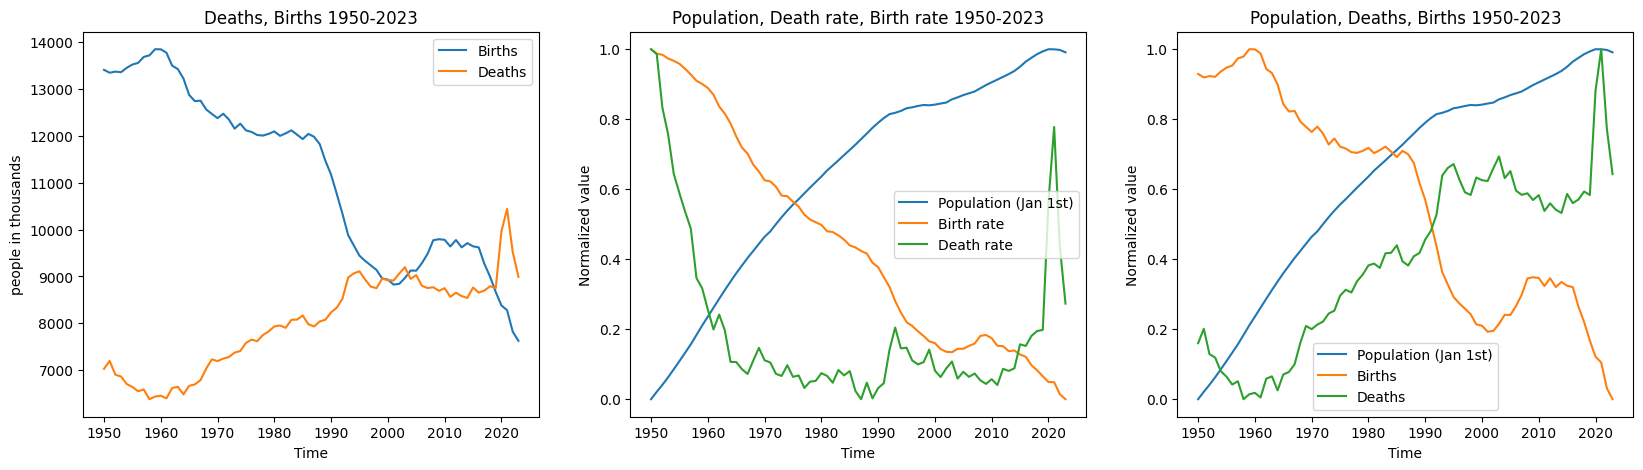

In [339]:
eur_agg_pop_deaths_births = un_world_pop_df[['Time', 'TPopulation1Jan', 'Births', 'Deaths']].groupby(['Time']).sum()
eur_agg_pop_deaths_births = eur_agg_pop_deaths_births.join(un_world_pop_df[['CBR', 'CDR', 'Time']].groupby(['Time']).mean())

fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)

ax1 = eur_agg_pop_deaths_births[['Births', 'Deaths']].plot(title='Deaths, Births 1950-2023', ylabel="people in thousands", ax=axs[0])
ax1.legend(['Births', 'Deaths'])

#normalize for better visual
for c in eur_agg_pop_deaths_births.columns:
    eur_agg_pop_deaths_births[c] = normalize_series(eur_agg_pop_deaths_births[c]) 

ax2 = eur_agg_pop_deaths_births[['TPopulation1Jan', 'CBR', 'CDR']].plot(title='Population, Death rate, Birth rate 1950-2023', 
                                                                       ylabel="Normalized value", ax=axs[1])
ax2.legend(['Population (Jan 1st)', 'Birth rate', 'Death rate'])

ax3 = eur_agg_pop_deaths_births[['TPopulation1Jan', 'Births', 'Deaths']].plot(title='Population, Deaths, Births 1950-2023', 
                                                                             ylabel="Normalized value", ax=axs[2])
ax3.legend(['Population (Jan 1st)', 'Births', 'Deaths'])

plt.show()

### Population Growth 1950-2023

Population in europe has been steadily increasing throughout time. Shortly after 1990 the growth rate slowed down a bit but still continued to increase. Interestingly, this slow down starts around the same where death and birth rates are converging. Finally, in 2023, for the first time we see a decrease in population. The death rate has been falling from 1950 to around 1965 and behaved mostly sideways with a big spike coming up in 2020 and 2021, most likely due to the global pandemic but then recovered a bit in 2023.

Interestingly, the birth rate has been declining from the 1950s and is currently at its lowest in history. Since total births are also at its lowest (even lower than total deaths), this development hints that part of the population growth might be attributed to migration.

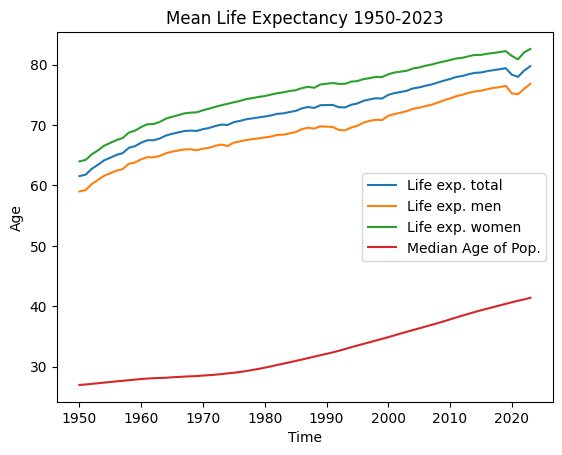

In [340]:
eur_agg_lex = un_world_pop_df[['Time', 'LEx', 'LExMale', 'LExFemale', 'MedianAgePop']].groupby(['Time']).mean()

ax = eur_agg_lex.plot(title='Mean Life Expectancy 1950-2023', ylabel="Age")
ax.legend(['Life exp. total', 'Life exp. men', 'Life exp. women', 'Median Age of Pop.'])

plt.show()

### Life expectancy

We can see that life expectancy has been growing and is now at the highest ever after a small dip during the pandemic. There is a gap of ~5 years between men and women but they seem to be moving in parallel. Also, one can see that the steepest improvement was during 1950 to shortly after 1960, which is exactly the timeframe in which death rates were strongly going down, as can be seen in the previous figure.

Meanwhile, the median age of the population is also increasing and even slightly accelrated the increase starting from the 1980s. Overall, this shows that the population is getting older, as there are lower births and people live longer, where the latter one is also contributing to population growth.

Next, given our assumption of migration contributing greatly to the way population numbers change, we will check how much net migrations contribute to the yearly population change. We do this for every country as it gives a better overview and also allows for identifying patterns.

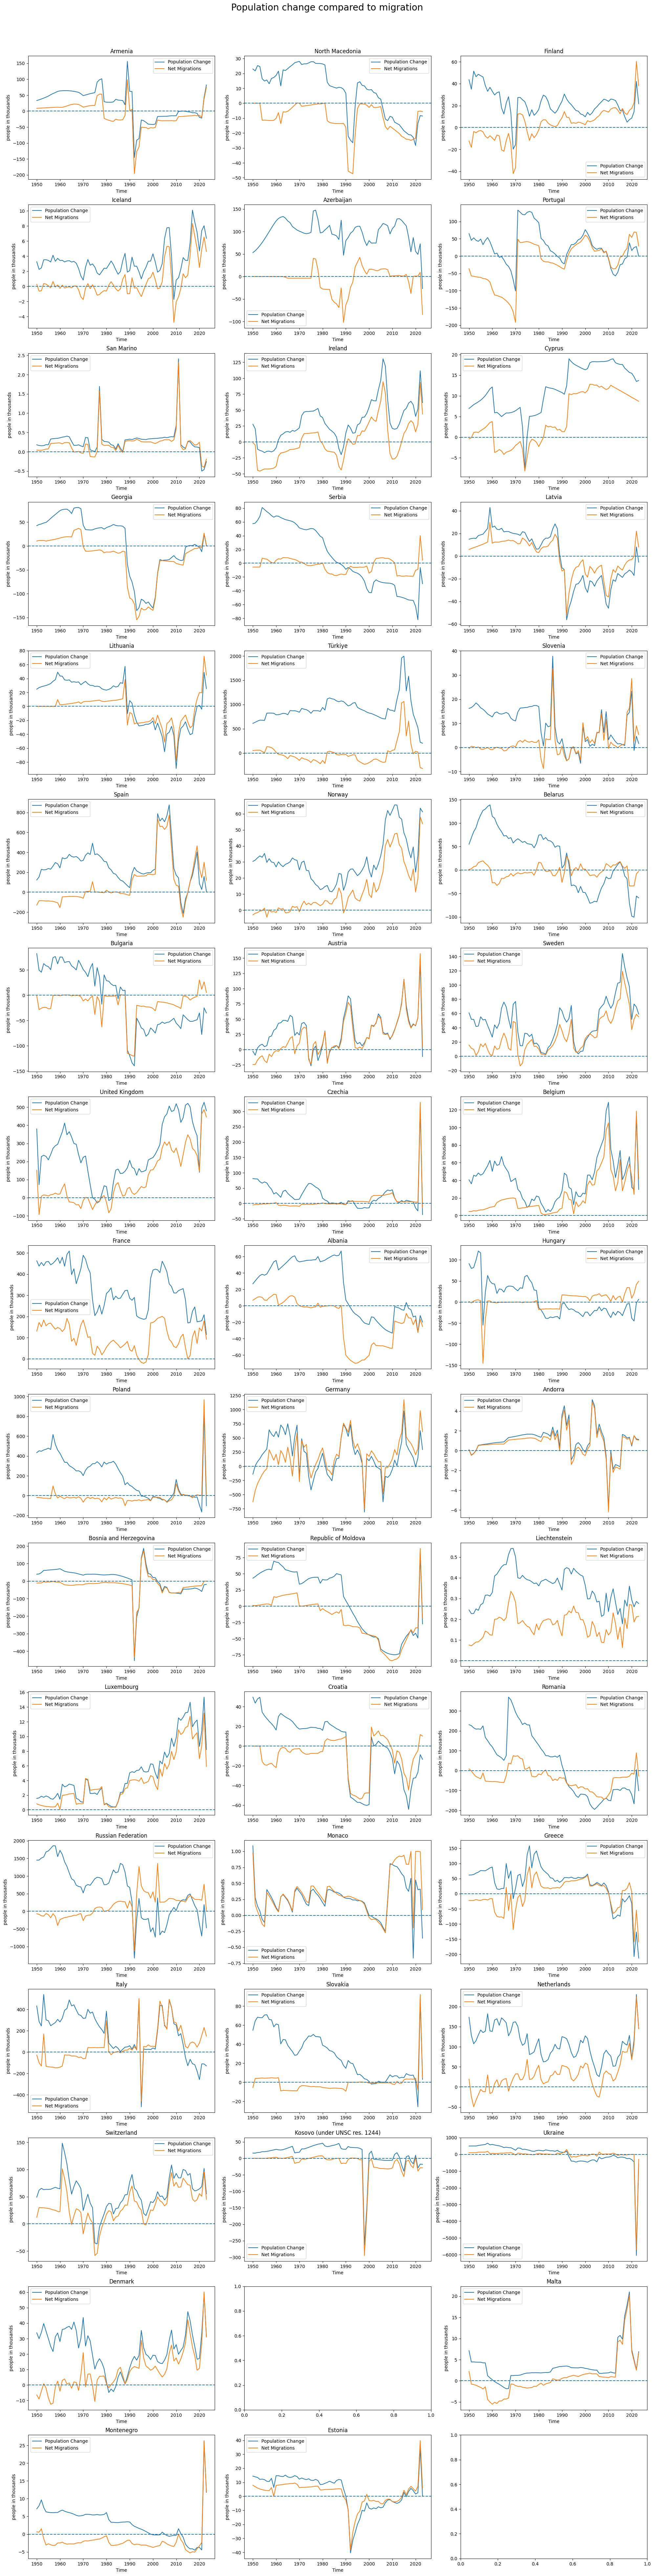

In [341]:
fig, axs = plt.subplots(17, 3)
fig.set_figheight(80)
fig.set_figwidth(20)

locs = un_world_pop_df['Location'].unique()
for i, l in enumerate(locs):
    sub_df = un_world_pop_df[un_world_pop_df['Location'] == l].set_index('Time')
    ax = sub_df[['PopChange', 'NetMigrations']].plot(title=l, ylabel='people in thousands', ax=axs[i % 17, i % 3])
    ax.axhline(y = 0, linestyle = '--') 
    ax.legend(['Population Change', 'Net Migrations'])

fig.tight_layout(pad=1)
fig.suptitle('Population change compared to migration', fontsize=20)
plt.subplots_adjust(top=0.96)
plt.show()
#note, the two empty figures are expected towards the end

### Population change compared to migration

As Expected, all countries behave a little bit different here, however, it is visible that for a lot of them migrations play a big part in how their population changed in the recent decades. We selected some interesting examples:
- Austria - Especially from the 2000s on (but also before) Migration takes up pretty much all population growth, as the lines are very close together
- Ukraine - it's clearly visible that the war took a big toll as a huge negative spike built up, showing many people left the country. This spike is also visible as immigration in other countries, e.g. in Poland
- Italy - this is one of the few examples where Migration and pop. growth is diverging in recent years. In this case the overall population is decreasing but there are still growing numbers of immigrants.
- North Macedonia - always had more people leaving the country since the 1950s. Despite that, population is only really decreasing since ca. 2006.
- Luxembourg - Since ca. 1985 population growth had a big increase, mostly attributable to migration
- Moldova - Had a decreasing population for some decades, big part of it because of emigration but has then got a small gain, due to immigrants
- France - One of the few countries that had big growth which was always attributed to natural change, only in recent years the net migration and population change lines are converging

Overall we can see that big movements in migration are often caused by geopolitical events such as wars. We will also go into more details about Migration in Section 2.

## Correlation between Population Growth and Other Statistics

We will check the correlation of population changing attributes to some general statistics of each country, to see if they have an effect on how population grows or shrinks. Unfortunately we don't have huge amounts of data here to check, as we only have the years 2012-2022 and many countries do have missing values. Still we can get an idea that will be presented below

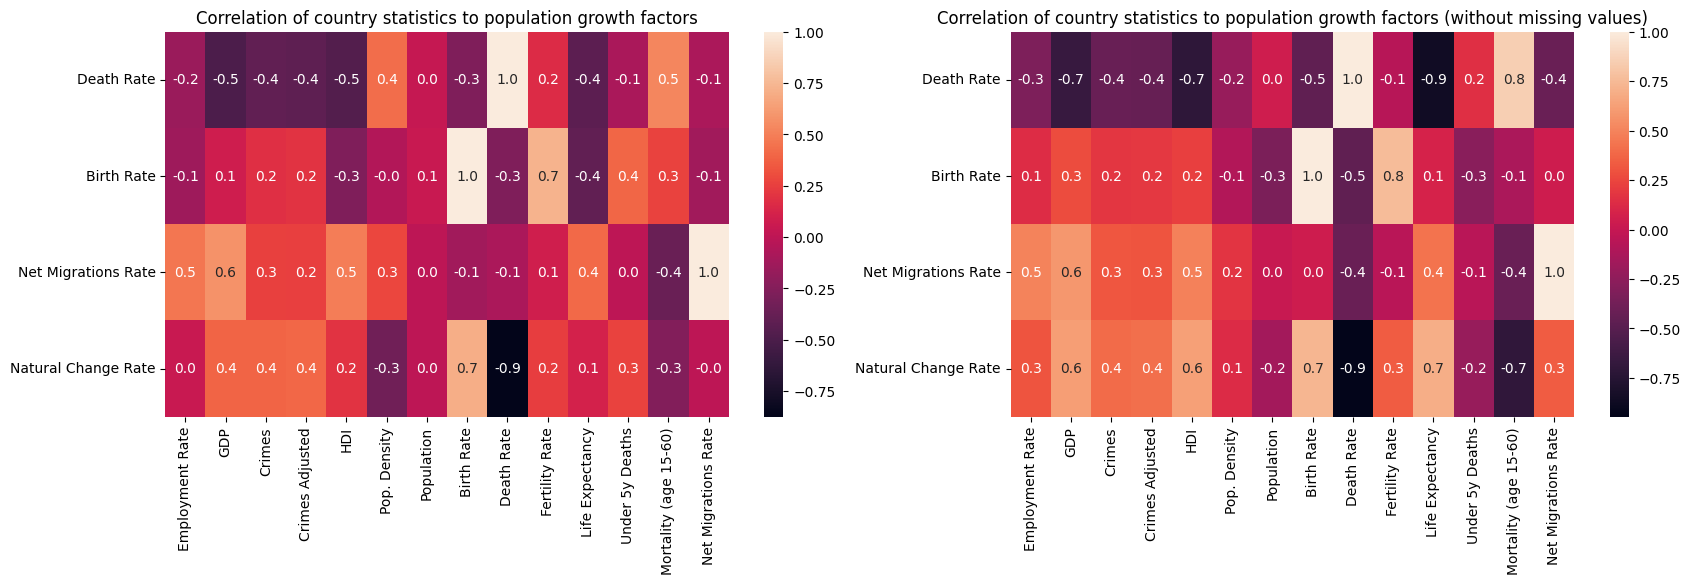

In [342]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)

xticks = ['Employment Rate', 'GDP', 'Crimes', 'Crimes Adjusted', 'HDI', 'Pop. Density', 'Population', 'Birth Rate',
          'Death Rate', 'Fertility Rate', 'Life Expectancy', 'Under 5y Deaths', 'Mortality (age 15-60)', 'Net Migrations Rate']
yticks = ['Death Rate', 'Birth Rate', 'Net Migrations Rate', 'Natural Change Rate']

corr = combined_df.drop(columns=['Location']).corr()
corr_selected_feats = corr.loc[['CDR', 'CBR', 'CNMR', 'NatChangeRT'], ['employment_rate', 'gdp', 'crimes', 'crimes_adjusted', 
                                                                           'hdi', 'PopDensity', 'TPopulation1Jan', 'CBR', 'CDR', 'TFR', 
                                                                           'LEx', 'Under5Deaths', 'Q1560', 'CNMR']]

a = sns.heatmap(corr_selected_feats, annot=True, fmt=".1f", ax=axs[0], xticklabels=xticks, yticklabels=yticks)
a.set_title('Correlation of country statistics to population growth factors')

corr_no_nans = combined_df.drop(columns=['Location']).dropna().corr()
corr_selected_feats = corr_no_nans.loc[['CDR', 'CBR', 'CNMR', 'NatChangeRT'], ['employment_rate', 'gdp', 'crimes', 'crimes_adjusted', 
                                                                           'hdi', 'PopDensity', 'TPopulation1Jan', 'CBR', 'CDR', 'TFR', 
                                                                           'LEx', 'Under5Deaths', 'Q1560', 'CNMR']]

b = sns.heatmap(corr_selected_feats, annot=True, fmt=".1f", ax=axs[1], xticklabels=xticks, yticklabels=yticks)
b.set_title('Correlation of country statistics to population growth factors (without missing values)')
plt.show()


### Correlation of country statistics to population growth factors

To see if we can identify some general properties influencing population growth we tried to find correlations. As there were many missing values, we created two heatmaps, one including and one excluding missing values. We selected four features that are relevant for population change:

**Crude Death Rate:** There is some correlation between the Mortality of people between people of age 15 - 60 and population density. Where the first one makes sense, the second, most likely isn't a cause but rather another symptom. Also higher gdp, hdi and lower crimes seem to have a positive effect on the death rate. Obviously Life expectancy also has a negative correlation. Without missing values, population density doesn't seem to influence the rate a lot, other than that it just reinforces the correlations already mentioned.

**Crude Birth Rate:** Opposed to the death rate, there is no noticeable correlation between any statistic and the birth rate, except the total fertility rate, which was expected. In the calculation without missing values, also the death rate seems to have a negative correlation.

**Net Migration Rate:** There is some moderate correlation between employment rate, gdp and hdi, suggesting people are migrating to more developed and economically strong countries. The number of crimes does not seem to have a big effect. Also, live expectancy and mortality seems to have a slight influence.

**Natural Change Rate:** As expected, the deathrate and birth rate have a strong correlation, as the natural change is births - deaths. Surprisingly though, the correlation is stronger with the death rate. If we look at the diagram without missing values life expectancy and mortality also seem to play a role. Also GDP and HDI seem to influence this statistic.

It is important to remember that these are only correlations and not the causes for these behaviors, therefore, any statement is just an assumption and must be further investigated. In general it seems though that countries with a higher hdi and gdp experience more population growth than those with a lower one. crimes and unemployment doesn't seem to affect these numbers too much.

# 2. Migration

## Original Migration Questions
1. What are the most common origin and destination countries of migration? Are there any spatial trends noticeable (e.g. differences between east and west europe)? Have they changed over time?
2. ~~What are the most common reasons of migration? Are there regional or temporal trends noticeable (either for origin or destination country)?~~
3. Are there demographic trends (incl education & jobs) amongst people migrating? How have they developed over time?


## Dataset
We looked at multiple datasets about migration, most notably from the UN and EU since they are the most reliable and detailed, and there are few other sources for migration data. Given the questions we set out to ask, we focused on migration flow (instead of stock) data for subquestions 1 and 3. While is generally a lot of UN/EU data available on "raw" migration flows, finding data that also covers origin (country of previous residence or birth) is a bit more difficult. There are two main candidates for datasets, the [UN International Migration Flows](https://www.un.org/development/desa/pd/data/international-migration-flows) dataset and the [EU Migration & Asylum Data](https://ec.europa.eu/eurostat/web/migration-asylum). The latter is actually a collection of datasets however. Having looked at datasets from both sources, we noticed that the Un data, while claiming comprehensive data with a large time coverage (1980-2013), does actually not provide dense data for a significant parts of the years (i.e. many datapoints are missing). Additionally, ending the time coverage with 2013 would provide little overlap with the more detailed datasets used to answer Question 1 (general population). Given that we only wanted to look at european countries, the lower number of countries available was no problem for us. When looking at the more detailed explanation of the EU/Eurostat data ([here](https://ec.europa.eu/eurostat/web/migration-asylum/international-migration-citizenship/information-data)), it is clearly outlined that there is a tradeoff between the time-coverage and the origin information (country of previous residence is only available from 1998 onwards). As a result, we used the "[Immigration by age group, sex and country of previous residence]((https://ec.europa.eu/eurostat/databrowser/view/migr_imm5prv/default/table?lang=en&category=migr.migr_cit.migr_immi))" dataset which provides the longest time-coverage while also containing information on origin. Even with this dataset though, there are many irregularities and datapoints missing. 

We also kept subquestion 3 rather short as this would have required a full new dataset, just for this specific points (i.e. it wouldn't have been used anywhere else in the project). That's why we "reinterpreted" the demographic part to a short analysis of sex and age.

*Given that the EU does provide a rather good interface (available under the link above) for looking at data, not all of the "checking" and inspection was done in this code.*

## Subquestion 2: Reasons of Migration
After having looked for (and found) datasets on reason of migration, we decided against further pursuing this part. The reasons for this are 
- the limited coverage/availability of datasets makes this very hard
- with the data available there is probably very little (novel) information we could generate

Given these points, we prioritised the other questions. The first problem is that there is generally very little data on reasons of migration. We did however find potentially interesting datasets. 

- [**First permits by reason, length of validity and citizenship**](https://ec.europa.eu/eurostat/databrowser/view/migr_resfirst/default/table?lang=en) - which provides a nice time-coverage (2008 - 2023), but only highly limited reasons for permits (namely just 3 categories + "other").
- [**Foreign-born population by sex, age, main reason for migrating, country of birth and educational attainment level**](https://data.europa.eu/data/datasets/7ilehit0c5f80vwmrkgw?locale=en) - which provides more detailed reasons, but only from 2023-2024. 

So, the analysis for both dataset would probably not have been very interesting and detailed since we could have only either looked at a time series with low granularity (in terms of reasons) or more detailed reasons for basically static data, which would have just been statistics for an unchanged dataset (so barely Data Science).

## Cleaning Migration Data

In [343]:
df = data_frames['estat_migr_imm5prv']
df.head(10)


freq,partner,agedef,age,unit,sex,geo\TIME_PERIOD 1998  1999  2000  2001   \
0                       A,AD,COMPLET,TOTAL,NR,F,AT    1     1     1     0    
1                       A,AD,COMPLET,TOTAL,NR,F,BE    :     :     :     :    
2                       A,AD,COMPLET,TOTAL,NR,F,BG    :     :     :     :    
3                       A,AD,COMPLET,TOTAL,NR,F,CH    :     :     :     :    
4                       A,AD,COMPLET,TOTAL,NR,F,CZ    :     :     :     :    
5                       A,AD,COMPLET,TOTAL,NR,F,DE   14     6     3     :    
6                       A,AD,COMPLET,TOTAL,NR,F,DK    2     4     1     0    
7                       A,AD,COMPLET,TOTAL,NR,F,EE    :     :     :     :    
8                       A,AD,COMPLET,TOTAL,NR,F,ES  379   337   339   245    
9                       A,AD,COMPLET,TOTAL,NR,F,FI    0     0     0     0    

  2002  2003  2004  2005  2006   ... 2013  2014  2015  2016  2017  2018   \
0   0 b    0     1     0     0   ...    :     0     0     0     1     1    
1    :     :     :     :     :   ...    5     3     0     2     1     5    
2    :     :     :     :     :   ...    0    0 p    0    0 p    0    0 p   
3    :     :     :     :     :   ...   10    11     4     8     9     9    
4    0     0     0     0     0   ...    :     :     :     :     :     :    
5    9     :     4     8     5   ...    :    4 e   4 e   2 e   3 e  14 e   
6    3     0     3     3     1   ...    2     1     1     2   186     1    
7    :     :     0     0     0   ...    0     0   2 be    0     0     0    
8  322     :   499   692   852   ...    :     :     :     :     :     :    
9    0     0     2     1     0   ...    0     1     1     0     0     2    

  2019  2020  2021  2022   
0    0     1     0     0   
1    0     :     :     0   
2   1 p   0 p    0     0   
3    7     9     :     :   
4    :     :     0     0   
5   6 e   2 e   1 e   4 e  
6    5     1     1     :   
7    0     0     0     0   
8    :     :     :     :   
9    1     1     0     2   

[10 rows x 26 columns]

After this initial look, there are three most apparent problems
- A lot of data if collected in one column
- some values are flagged with (combinations of) letters (meaning of the flags is explained in the link of the dataset)
- missing values are marked with ":" (and there are a lot of them)

There are more problems, but we'll get to those later

## Extracting/Expanding First Column Data

First, let's extract the detailed information from the single column. We don't need the 'freq', 'unit' and 'agedef' columns, as they only provide constant and for our purposes irrelevant meta information. From here on, we refer to the european reporting country ("geo") by "destination" and the country of previous residence ("partner") as "origin". We also remove trailing whitespaces from the year column names

In [344]:
# Read and split the initial data
first_col = df.columns[0]

# Split the first column into its components
df_expanded = df[first_col].str.split(',', expand=True)
df_expanded.columns = ['freq', 'partner', 'agedef', 'age', 'unit', 'sex', 'geo']

# Drop unwanted columns and rename as specified
df_expanded = df_expanded.drop(columns=['freq', 'unit', 'agedef'])
df_expanded = df_expanded.rename(columns={'partner': 'origin', 'geo': 'destination'})

# Get the year columns
year_cols = df.columns[1:]
year_data = df[year_cols]

# Strip spaces from year column names
year_data.columns = year_data.columns.str.strip()

# Combine the expanded columns with the year data
df_final = pd.concat([df_expanded, year_data], axis=1)

display(df_final.head())


origin    age sex destination 1998 1999 2000 2001 2002 2003  ... 2013 2014  \
0     AD  TOTAL   F          AT   1    1    1    0   0 b   0   ...   :    0    
1     AD  TOTAL   F          BE   :    :    :    :    :    :   ...   5    3    
2     AD  TOTAL   F          BG   :    :    :    :    :    :   ...   0   0 p   
3     AD  TOTAL   F          CH   :    :    :    :    :    :   ...  10   11    
4     AD  TOTAL   F          CZ   :    :    :    :    0    0   ...   :    :    

  2015 2016 2017 2018 2019 2020 2021 2022  
0   0    0    1    1    0    1    0    0   
1   0    2    1    5    0    :    :    0   
2   0   0 p   0   0 p  1 p  0 p   0    0   
3   4    8    9    9    7    9    :    :   
4   :    :    :    :    :    :    0    0   

[5 rows x 29 columns]

## Value Cleaning
Luckily, the Eurostat data has already clearly marked NaN values that just need replacing

In [345]:
# Replace ': ' with NaN first
dfFull = df_final.replace(': ', np.nan)

The flags are a bit more interesting and signal properties like break in timeseries or estimated values. We originally didn't want to include values flagged with 'b' (break in timeseries) as there should be no values available, but we later decided to include those cells too as eurostat already provides a (fairly logical) fill-in value and we wanted to have as much data available for analysis. Given this, we simply detect the flags using regex and remove it from the cells. Afterwards, we can simply convert the cells to numeric values.

*missing values will be talked about again later*

In [346]:
# Define the cleaning function for flags
def clean_flags(value):
    if pd.isna(value):
        return value
    
    # Convert to string if not already
    value = str(value)

    # this was to remove values of with 'b' (break in timeseries) flags, but we instead decided to keep those estimates
    # If only 'b' flag is present (not part of 'be' or 'bep'), replace with NaN
    # if ' b' in value and not any(flag in value for flag in ['be', 'bep']):
    #     return np.nan

    # Remove all flag patterns and strip whitespace
    cleaned = re.sub(r'\s*[pb]*e?p?\s*', '', value).strip()
    
    try:
        return float(cleaned)
    except ValueError:
        return np.nan

# Apply the cleaning function to all yearly columns (starts from the 5th column)
year_cols = dfFull.columns[4:]
dfFull[year_cols] = dfFull[year_cols].map(clean_flags)

# Convert year columns to numeric
dfFull[year_cols] = dfFull[year_cols].apply(pd.to_numeric, errors='coerce')

display(dfFull.head())

origin    age sex destination  1998  1999  2000  2001  2002  2003  ...  \
0     AD  TOTAL   F          AT   1.0   1.0   1.0   0.0   0.0   0.0  ...   
1     AD  TOTAL   F          BE   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2     AD  TOTAL   F          BG   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3     AD  TOTAL   F          CH   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4     AD  TOTAL   F          CZ   NaN   NaN   NaN   NaN   0.0   0.0  ...   

   2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  
0   NaN   0.0   0.0   0.0   1.0   1.0   0.0   1.0   0.0   0.0  
1   5.0   3.0   0.0   2.0   1.0   5.0   0.0   NaN   NaN   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  
3  10.0  11.0   4.0   8.0   9.0   9.0   7.0   9.0   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  

[5 rows x 29 columns]

Lastly, in anticipating of the choropleth plots later, we transform the country codes to actual iso alpha-2 codes. This only pertains to two countries, as the columns should actually be alpha-2 (but eurostat for some reason does this differently)

In [347]:
# renaming UK to GB and EL to GR (this is a EU-specific issue)
dfFull.loc[dfFull['destination'] == 'EL', 'destination'] = 'GR'
dfFull.loc[dfFull['origin'] == 'EL', 'origin'] = 'GR'
dfFull.loc[dfFull['destination'] == 'UK', 'destination'] = 'GB'
dfFull.loc[dfFull['origin'] == 'UK', 'origin'] = 'GB'

## Checking Categorical Values (Destination Country, Origin Country, Age, Sex)

### Understanding Categories
To fully understand the data, we'll look at the unique categories used in the categorical columns.

In [348]:
dfFull['sex'].unique()

array(['F', 'M', 'T'], dtype=object)

In [349]:
dfFull['age'].unique()

array(['TOTAL', 'UNK', 'Y10-14', 'Y15-19', 'Y15-64', 'Y20-24', 'Y25-29',
       'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y5-9', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89',
       'Y90-94', 'Y95-99', 'Y_GE100', 'Y_GE65', 'Y_GE85', 'Y_LT15',
       'Y_LT5'], dtype=object)

In [350]:
dfFull['destination'].unique()

array(['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'HR',
       'IE', 'IS', 'IT', 'KG', 'LI', 'LT', 'LU', 'LV', 'ME', 'MK', 'NL',
       'NO', 'PL', 'RO', 'RU', 'SE', 'SI', 'SK', 'GB', 'BY', 'IL', 'MD',
       'GR', 'AZ', 'UZ', 'AM', 'TJ', 'FR', 'HU', 'CY', 'MT', 'PT',
       'EU27_2020', 'TR', 'BA', 'GE', 'SM', 'UA'], dtype=object)

In [351]:
dfFull['origin'].unique()

array(['AD', 'AE', 'AF', 'AFR', 'AFR_C', 'AFR_E', 'AFR_N', 'AFR_OTH',
       'AFR_S', 'AFR_W', 'AG', 'AI', 'AL', 'AM', 'AME', 'AME_C', 'AME_N',
       'AME_OTH', 'AME_S', 'AN', 'AO', 'AQ', 'AR', 'AS', 'ASI', 'ASI_C',
       'ASI_E', 'ASI_OTH', 'ASI_S', 'ASI_S_E', 'ASI_W', 'AT', 'AU',
       'AU_NZ', 'AW', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH',
       'BI', 'BJ', 'BL', 'BM', 'BN', 'BO', 'BQ', 'BR', 'BS', 'BT', 'BW',
       'BY', 'BZ', 'CA', 'CC', 'CC3_07', 'CC4_10', 'CC8_22_FOR', 'CD',
       'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CO', 'CR', 'CRB',
       'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'CZ_SK', 'DE', 'DJ', 'DK',
       'DM', 'DO', 'DZ', 'EC', 'EE', 'EFTA', 'EFTA_FOR', 'EG', 'EH', 'GR',
       'ER', 'ES', 'ET', 'EU15', 'EU25', 'EU27_2007', 'EU27_2007_FOR',
       'EU27_2020_FOR', 'EU28_FOR', 'EUR', 'EUR_OTH', 'EXT', 'EX_SU',
       'EX_YU', 'FI', 'FJ', 'FK', 'FM', 'FO', 'FR', 'GA', 'GD', 'GE',
       'GG', 'GH', 'GI', 'GL', 'GM', 'GN', 'GQ', 'GS', 'GT', 'GU', 'GW'

From this, we gained the following insights:
- All categorical columns include aggregate categories that need special treatment for analysis (i.e. no simply groupby possible)
- Different countries report different age "systems" (detailed vs "<15, 15-64, >64")
- The destination data, has one aggregate category (EU27_2020)
- The origin data, has quite a lot of aggregate areas which will need to be removed (see below)
- Apart from the destination column all columns have a "TOTAL"/"T" category (which will be used for most of the analysis because it's the only reliable one)
- This is not reflected in the output above, but not all countries report all of those categories. France for example doesn't report origin countries apart from EU/non-EU.
- For age and origin there is also an unknown "UNK" category which we can't remove since it's not an aggregate category and we might loose information

The categories will be handled in the following section

### Removing (some) aggregate Areas and determining consistent/reliable reporters (apart from 'TOTAL')

For our analysis, we'll remove all the aggregate categories from the origin column as they are not consistently reported and thus not reliable. They were extracted manually. 

For a more detailed insight (and for seeing the reporting problem), we have a tabular view of how many individual origin countries and aggregate areas are reported by each european destination country. Unfortunately, there are quite a few that barely report individual origin countries.

In [352]:
# aggregate areas for origin countries
# this excludes UNK since it's technically not an aggregate

aggregate_areas = ['EUR','EU27_2007','EU25','EU15','EU27_2020_FOR','EU28_FOR','EU27_2007_FOR','EFTA','EFTA_FOR','CC8_22_FOR','CC4_10','CC3_07','EXT','HDC_EXT','MDC_EXT','LDC_EXT','NEU27_2020_FOR','NEU28_FOR','NEU27_2007_FOR','EUR_OTH','AFR','AFR_C','AFR_E','AFR_N','AFR_S','AFR_W','AFR_OTH','AME','AME_N','CRB','AME_C','AME_S','AME_OTH','ASI','ASI_C','ASI_E','ASI_S','ASI_S_E','ASI_W','ASI_OTH','OCE','AU_NZ','MEL','MIC','OCE_OTH']

In [353]:
# getting an overview/understanding of how (destination) countries reprot

subset = dfFull[(dfFull["sex"] == "T") & (dfFull["age"] == "TOTAL")].copy(deep=True)
subset["agg"] = subset["origin"].isin(aggregate_areas)
subset["indiv"] = ~subset["agg"]
nDestinationsPerDestination = subset.groupby(["destination"]).agg({"agg": "sum", "indiv": "sum"})
display(nDestinationsPerDestination)

agg  indiv
destination            
AM            28     84
AT            86    502
AZ            26     54
BA             0      2
BE            78    468
BG            88    492
BY            64    456
CH            78    470
CY            30      4
CZ            88    492
DE            88    500
DK            88    500
EE            88    492
ES            88    498
EU27_2020     12      4
FI            88    500
FR            30     58
GB            86    474
GE             0      2
GR            30      4
HR            88    500
HU            30     58
IE            78    460
IL            62    456
IS            82    500
IT            78    468
KG            62    456
LI            78    468
LT            88    500
LU            86    464
LV            42    296
MD            46    220
ME            56    464
MK            76    496
MT            26      4
NL            88    500
NO            88    500
PL            88    476
PT            26      4
RO            62    462
RU            64    458
SE            88    498
SI            88    500
SK            88    500
SM             0      2
TJ            12     20
TR             0      6
UZ            24     82

In [354]:
# remove aggregate areas from the origin column

dfFull = dfFull[~dfFull["origin"].isin(aggregate_areas)]

In [355]:
# remove the aggregate area from the destination column

dfFull = dfFull[~(dfFull["destination"] == 'EU27_2020')]

In [356]:
# these are destination countries that are consistently reporting (i.e. over many years)
# specifically, we removed 'GE', 'TR', 'ME', from the countries reporting in 2022

consistentReporters = ['AT', 'BE', 'BG', 'CZ', 'EE', 'FI', 'HR', 'IS', 'IT', 'LT', 'NL', 'NO', 'SE', 'SI', 'SK', 'ES', 'FR', 'HU', 'CH', 'CY', 'DE', 'DK', 'EL', 'IE', 'LI', 'LU', 'LV', 'MK', 'MT', 'PL', 'PT', 'MD']
print(len(consistentReporters))

32


Apart from the initial overview of generally reliable/consistent reporters above, at which countries actually (reliably) report for which year (as this might change over years). For this we set a threshold of 200 reported origin countries as there are countries slightly above this level that we want to include and we see 200 as a high enough granularity. 

Number of origin countries reported per year and destination:


1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  ...  \
destination                                                              ...   
AM              0     0     0     0     0     0     0    32    28    84  ...   
AT            464   464   296   466   466   466   466   466   466   462  ...   
AZ              0     0     0     0     0     0     0    44     0    46  ...   
BA              0     0     0     0     0     0     0     0     0     2  ...   
BE              2     2     2     2     2     2     2     2     2     2  ...   

             2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  
destination                                                              
AM              0     0     0     0     0     0     0     0     0     0  
AT              4   460   460   460   460   460   460   452   452   452  
AZ              0     0     0     0     0     0     0     0     0     0  
BA              0     0     0     0     0     0     0     0     0     0  
BE            462   460   460   460   460   460   460     4     4   452  

[5 rows x 25 columns]

Detailed reporters per year:


1998   1999   2000   2001   2002   2003   2004   2005   2006  \
destination                                                                  
AM           False  False  False  False  False  False  False  False  False   
AT            True   True   True   True   True   True   True   True   True   
AZ           False  False  False  False  False  False  False  False  False   
BA           False  False  False  False  False  False  False  False  False   
BE           False  False  False  False  False  False  False  False  False   
BG           False  False  False  False  False  False  False  False  False   
BY           False  False  False  False  False  False  False  False   True   
CH           False  False  False  False  False  False  False  False  False   
CY           False  False  False  False  False  False  False  False  False   
CZ           False  False  False  False   True   True   True   True   True   
DE            True   True   True  False   True  False   True   True   True   
DK            True   True   True   True   True   True   True   True   True   
EE           False  False  False  False  False  False   True   True   True   
ES            True   True   True   True   True  False   True   True   True   
FI            True   True   True   True   True   True   True   True   True   
FR           False  False  False  False  False  False  False  False  False   
GB            True   True   True   True   True   True   True   True   True   
GE           False  False  False  False  False  False  False  False  False   
GR           False  False  False  False  False  False  False  False  False   
HR           False   True  False   True   True   True   True  False   True   
HU           False  False  False  False  False  False  False  False  False   
IE           False  False  False  False  False  False  False  False   True   
IL           False  False  False  False  False  False  False  False  False   
IS            True   True   True   True   True  False  False  False  False   
IT           False  False  False  False  False  False  False  False  False   
KG           False  False  False  False  False  False  False  False   True   
LI           False  False  False  False  False  False  False  False  False   
LT            True   True   True   True   True   True   True   True   True   
LU           False  False  False  False  False   True   True   True  False   
LV            True   True  False  False  False  False  False  False  False   
MD           False  False  False  False  False  False  False  False  False   
ME           False  False  False  False  False  False  False  False  False   
MK           False  False   True   True   True  False   True   True  False   
MT           False  False  False  False  False  False  False  False  False   
NL            True   True   True   True   True   True   True   True   True   
NO            True   True   True   True   True   True   True   True   True   
PL           False  False  False   True   True   True   True   True   True   
PT           False  False  False  False  False  False  False  False  False   
RO           False  False  False  False  False  False  False  False  False   
RU           False  False  False  False  False  False  False   True   True   
SE            True   True   True   True   True   True   True   True   True   
SI            True   True   True   True   True   True   True   True   True   
SK            True   True   True   True   True   True   True   True   True   
SM           False  False  False  False  False  False  False  False  False   
TJ           False  False  False  False  False  False  False  False  False   
TR           False  False  False  False  False  False  False  False  False   
UZ           False  False  False  False  False  False  False  False  False   

              2007  ...   2013   2014   2015   2016   2017   2018   2019  \
destination         ...                                                    
AM           False  ...  False  False  

Number of detailed reporters per year:


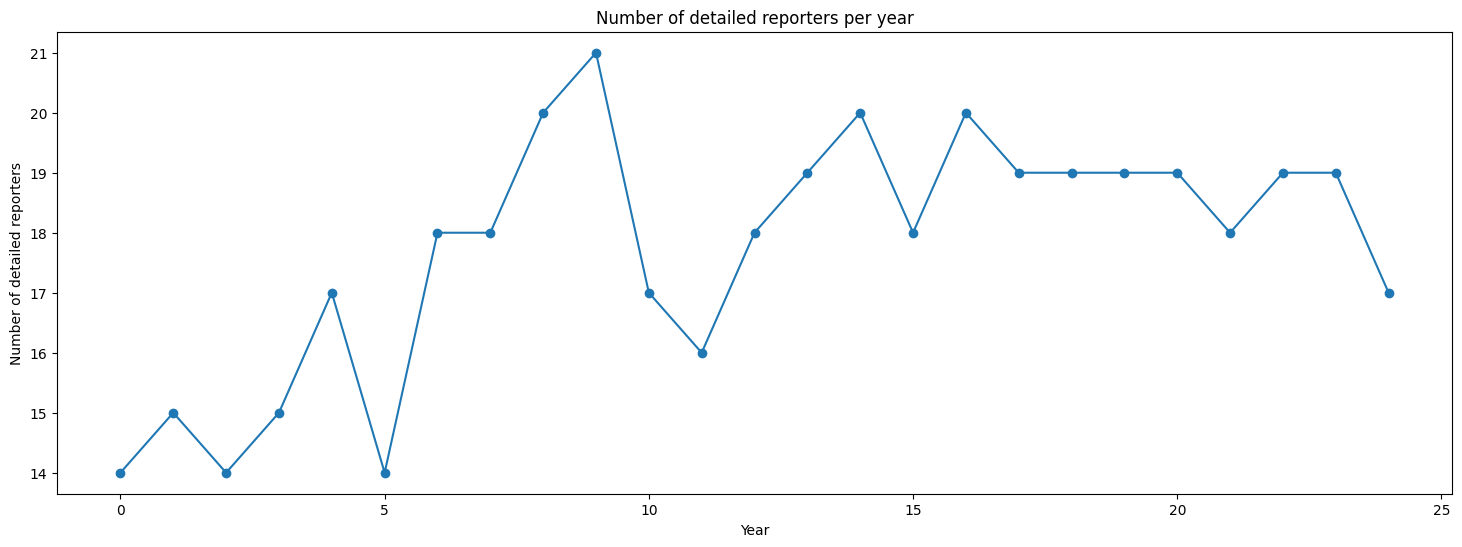

In [357]:
# the consistent reporters still have gaps in reporting however. So where necessary, we can use a yearly resolution
# also, these consistent reporters have to report detailed origins (e.g. not France who only report EU/non-EU)

subset = dfFull[(dfFull["sex"] == "T") & (dfFull["age"] == "TOTAL")]
# test = test[~test["origin"].isin(consistentReporters)]
# test.groupby(["destination"]).agg({col: "sum" for col in year_cols})
# test.groupby(["destination"]).agg({col: lambda x: np.count_nonzero(x) for col in year_cols})
detailedReporters = subset.groupby(["destination"]).agg({col: lambda x: (len(x) - x.isna().sum()) for col in year_cols})

ref = detailedReporters.copy(deep=True)
for year in range(1998, 2023):
    detailedReporters[str(year)] = np.where(ref[str(year)] >= 200, True, False)

detailedReporters = detailedReporters.astype({str(year): 'bool' for year in range(1998, 2023)})

print("Number of origin countries reported per year and destination:")
display(ref.head())

print("Detailed reporters per year:")
display(detailedReporters)

# Detailed reporters over the years
print("Number of detailed reporters per year:")
# display()
plt.figure(figsize=(18, 6))
plt.plot(detailedReporters.sum(axis=0).values, 'o-')
plt.title("Number of detailed reporters per year")
plt.xlabel("Year")
plt.ylabel("Number of detailed reporters")
plt.show()

At this point there are still one aggregate categories (namely TOTAL) in each of the "meta-columns" (age, destination, sex and also one in origin). The reason why we can't remove the "TOTAL" category from all columns is that some countries don't report the sub-categories. For example, while most destination (reporting) countries in europe report the origin (previous place of residence), France only differentiates between within EU and from outside the EU. 

Given this inconsistency in reporting, we'll leave the "TOTAL" category in the dataset and very frequently use it to focus on only on the relevant aspects to look at. 

## SQ 1: Common Origin Countries (for whole Europe)
In terms of analysis, we first wanted to look at the distribution of origin countries, i.e. from which countries most immigration into Europe happened. A choropleth plot could have also been an option here, but given that we consider the whole world it might not have provided good insight (or overview). Instead, we look at the 5 origin countries with the highest number of immigrants. This, and the next, section provide insight into "one-sided" immigration (so either origin or destination), the section after that will provide a more granular resolution.

In [358]:
# function for plotting (absolute) horizontal stacked bar charts

def create_flexible_stacked_horizontal_bar_charts(categories, data_sets, color_map, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    y_pos = np.arange(len(categories))
    bar_height = 0.6
    
    all_subcategories = set()
    for data in data_sets:
        all_subcategories.update(data.keys())
    
    legend_elements = []
    
    for i, (category, data) in enumerate(zip(categories, data_sets)):
        # Sort the data for this category in descending order
        sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)
        
        start = 0
        for subcategory, value in sorted_data:
            bar = ax.barh(y_pos[i], value, bar_height, left=start, 
                          color=color_map[subcategory])
            
            # Add text in the middle of the bar segment
            text_x = start + value / 2
            ax.text(text_x, y_pos[i], subcategory, 
                    ha='center', va='center',
                    color='black', fontweight='bold')
            
            start += value
            
            # Add to legend elements if not already there
            if subcategory not in [le.get_label() for le in legend_elements]:
                legend_elements.append(plt.Rectangle((0,0),1,1, 
                                       color=color_map[subcategory], 
                                       label=subcategory))
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories)
    ax.invert_yaxis()
    ax.set_xlabel('Number of Migrants')
    ax.set_title(title)
    
    # Add the legend with all unique subcategories
    ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.1, 0))
    
    plt.tight_layout()
    plt.show()


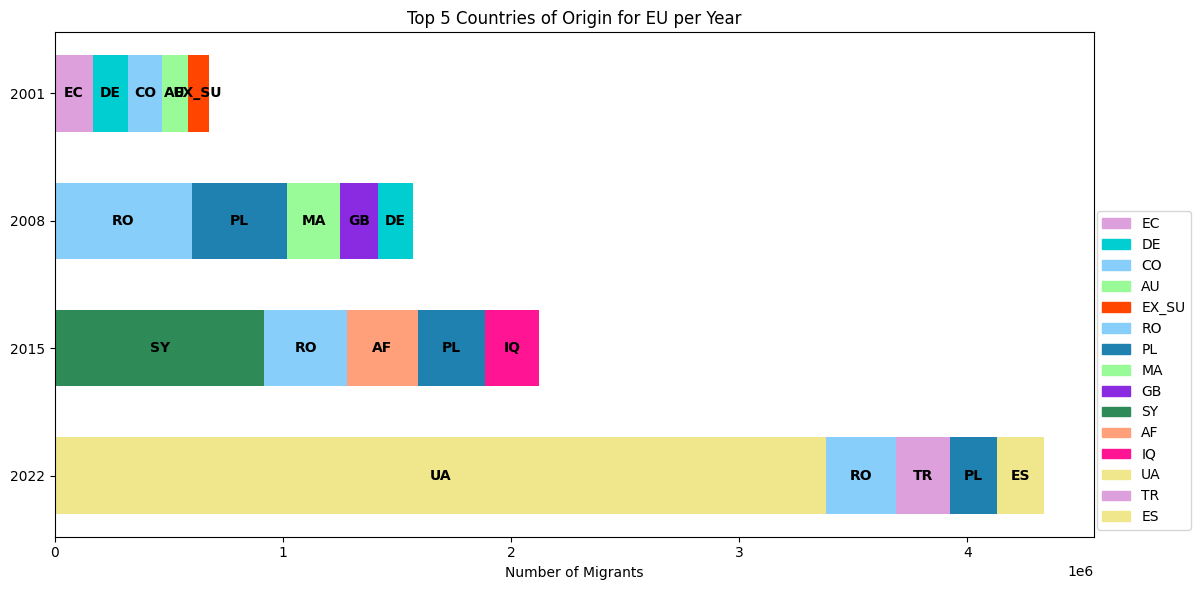

In [359]:
dfOrigin = dfFull[(dfFull["sex"] == "T") & (dfFull["age"] == "TOTAL") & (dfFull["origin"] != 'TOTAL')].drop(columns= ["age", "sex"])

years = ["2001"]
years = ["2001", "2008", "2015", "2022"]
datasets = []
countries = []


# display(detailedReporters)
for year in years:
    detailedYearReporters = detailedReporters[detailedReporters[year]].index

    detailedReport = dfOrigin.loc[dfOrigin["destination"].isin(detailedYearReporters), ["origin", year]]
    detailedReport = detailedReport.groupby(["origin"]).sum()[year].sort_values(ascending= False).nlargest(5).to_dict()
    # display(detailedReport)
    datasets.append(detailedReport)
    countries.append(list(detailedReport.keys()))

# get the colors
colorList = ['#FFA07A', '#98FB98', '#87CEFA', '#00CED1', '#DDA0DD', '#F0E68C', '#FF4500', '#8A2BE2', '#FF1493', '#98FB98', '#1e81b0', '#87CEFA', '#2E8B57', '#DDA0DD','#F0E68C', '#FF4500', '#00CED1', '#8A2BE2', '#2E8B57', '#FF1493']
colors = {}
for i, country in enumerate(np.unique(countries)):
    colors[country] = colorList[i]

create_flexible_stacked_horizontal_bar_charts(years, datasets, colors, "Top 5 Countries of Origin for EU per Year")

The answer to the most common "origin" countries is quite interesting, especially considering the changes (and consistencies) over the years. It's rather to be expected that most immigration in 2022 came from Ukraine and in 2015 from Syria, Afghanistan and Iraq. Beyond that though, the results provide some (potentially) suprising insights. E.g. Romania and Poland consistenly being among the top origin countries. I find it especially interesting to see quite a few european/EU countries too.

Below, we perform a similar analysi, but exclude european/EU countries.

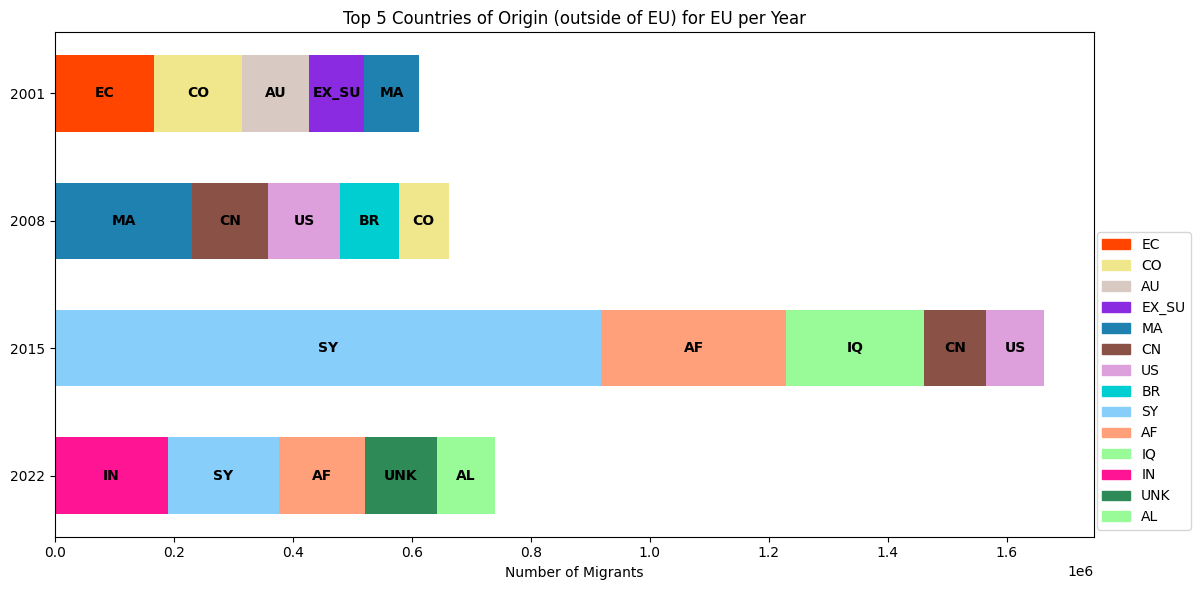

In [360]:
dfOrigin = dfFull[(dfFull["sex"] == "T") & (dfFull["age"] == "TOTAL") & (dfFull["origin"] != 'TOTAL') & (~dfFull["origin"].isin(dfFull["destination"]))].drop(columns= ["age", "sex"])

years = ["2001"]
years = ["2001", "2008", "2015", "2022"]
datasets = []
countries = []


# display(detailedReporters)
for year in years:
    detailedYearReporters = detailedReporters[detailedReporters[year]].index

    detailedReport = dfOrigin.loc[dfOrigin["destination"].isin(detailedYearReporters), ["origin", year]]
    detailedReport = detailedReport.groupby(["origin"]).sum()[year].sort_values(ascending= False).nlargest(5).to_dict()
    # display(detailedReport)
    datasets.append(detailedReport)
    countries.append(list(detailedReport.keys()))

# get the colors
colorList = ['#FFA07A', '#98FB98', '#d8cac2', '#00CED1', '#8a5147', '#F0E68C', '#FF4500', '#8A2BE2', '#FF1493', '#98FB98', '#1e81b0', '#87CEFA', '#2E8B57', '#DDA0DD','#F0E68C', '#FF4500', '#00CED1', '#8A2BE2', '#2E8B57', '#FF1493']
colors = {}
for i, country in enumerate(np.unique(countries)):
    colors[country] = colorList[i]

create_flexible_stacked_horizontal_bar_charts(years, datasets, colors, "Top 5 Countries of Origin (outside of EU) for EU per Year")

Again, part of those results are to be expected (there is probably a consistent immigration from the US and China), but comparatively high immigration from countries like Albania and Morocco as well as south-american countries like Ecuador and Columbia are interesting to see and in my opinion unexpected.

## SQ 1: General Immigration Distribution across europe (Choropleth)
Next we want to look at how immigration into europe is distributed amongst the countries and if there are any regional trends and tendencies. For this, given that europe nicely fits onto a map and is fairly assessable, we use choropleth plots since allow for high information density while still being well understandable. For our choice of program, namely the plotly library, the country codes first need to be converted to iso alpha-3 codes. Since we don't need sex, age and origin resolution, we take the "TOTAL" aggregate category for each.

In [361]:
dfDest = dfFull[((dfFull["sex"] == "T") & (dfFull["age"] == "TOTAL") & (dfFull["origin"] == "TOTAL"))].drop(columns=["origin", "age", "sex"]).reset_index()
dfDest.drop(dfDest[dfDest["destination"] == "EU27_2020"].index, inplace=True)
dfDest = dfDest.sort_values("destination").set_index("destination", drop= True).drop(columns= ["index"]).drop_duplicates().reset_index()


# Convert ISO2 country codes to ISO3 using pycountry
# Define a function to map ISO2 to ISO3
def iso2_to_iso3(iso2):
    if (iso2 == "UK"):
        iso2 = "GB"
    if (iso2 == "EL"):
        iso2 = "GR"

    # if (iso2 == "DE"):
    #     return 'GER'

    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except AttributeError:
        return None

# Apply the conversion to the 'destination' column
dfDest['iso3'] = dfDest['destination'].apply(iso2_to_iso3)



In [362]:
years = ["2001", "2008", "2015", "2022"]

for year in years:   
    fig = px.choropleth(dfDest, locations="iso3", color=year,  scope='europe',
                        projection="mercator", title="Total Immigration into European Countries in " + year,  locationmode='ISO-3')

    # Customize the layout
    fig.update_layout(
        geo=dict(
            showcoastlines=True,
            coastlinecolor="Black",
            showland=True,
            landcolor="white",
            showocean=True,
            oceancolor="lightblue",
            projection_type='mercator'
        ),
        coloraxis_colorbar=dict(
            title="Immigration"
        ),
        width=600, height=600
    )
    fig.update_geos(fitbounds="locations", visible=False)
    # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # fig.update_layout()


    fig.show()

At least to me these results were quite suprising. Amongst the four years surveyed, 2008 (and a very limited aspect 2022) are the ones that see immigration somewhat distributed within europe. For all years though, it's clearly visible that most migration happens to Germany, with UK, France and in 2008 Italy seeing elevated immigration numbers too. Additionally, as a "side-note" one can see the UK leaving the EU (and thus not reporting anymore), but also inconsistent reporters like France and Switzerland, which don't provide reports for each year.

## Origin Breakdown for Germany
Based on the previous results and out of curiousity, we took a closer look at how immigration into Germany was distributed with regards to common origin countries. Specifically, we wanted to see if there was deviation between origin countries for Germany and the whole EU. 

First though, we need to figure out which years we can even look at for Germany (i.e. when they reported detailed origin breakdowns).

In [363]:
# looking at when germany reported detailed destination data
detailedReporters.loc["DE"]

1998     True
1999     True
2000     True
2001    False
2002     True
2003    False
2004     True
2005     True
2006     True
2007     True
2008     True
2009    False
2010    False
2011    False
2012    False
2013    False
2014     True
2015     True
2016     True
2017     True
2018     True
2019     True
2020     True
2021     True
2022     True
Name: DE, dtype: bool

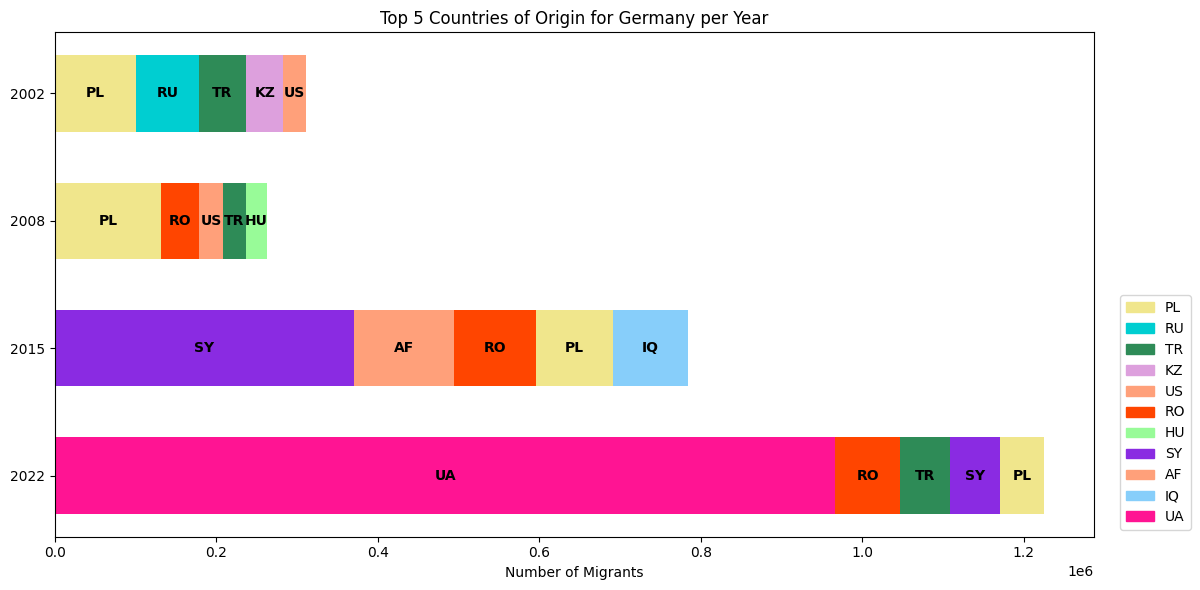

In [364]:
# selection of years based on detailed reports above
years = ["2002", "2008", "2015", "2022"]

# again select totals for categories
dfGer = dfFull[(dfFull["sex"] == "T") & (dfFull["age"] == "TOTAL") & (dfFull["destination"] == "DE") & (dfFull["origin"] != "TOTAL")].set_index("origin", drop= True).drop_duplicates()

datasets = []
countries = []

# display(detailedReporters)
for year in years:
    detailedReport = dfGer[year].sort_values(ascending= False).nlargest(5).to_dict()
    datasets.append(detailedReport)
    countries.append(list(detailedReport.keys()))

# get the colors
colorList = ['#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD','#F0E68C', '#FF4500', '#00CED1', '#8A2BE2', '#2E8B57', '#FF1493', '#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD','#F0E68C', '#FF4500', '#00CED1', '#8A2BE2', '#2E8B57', '#FF1493']
colors = {}
for i, country in enumerate(np.unique(countries)):
    # print(country)
    colors[country] = colorList[i]

create_flexible_stacked_horizontal_bar_charts(years, datasets, colors, "Top 5 Countries of Origin for Germany per Year")

For 2022 the EU results seem to align very well with the German results, apart from Spain being replaced by Syria of similar proportion. Also, 2015 seems to align very well. For the earlier 2001 and 2008 years however we can see quite a few differences like Romania not being as prevalent and instead large "contributions" from Poland, higher numbers from the US and Russia, as well as no occurences of south-american countries (like it was the case with 2001 for whole europe).

## SQ 1: Origin and Destination Trends
Next we want to look at the origin and destination trends/tendencies a bit more in detail. Namely, we want to see if there are global differences with regards to destinations for immigration. That is to say if e.g. immigration from the americas tends to different european areas than immigration from e.g. africa. Given the amount of origins (and also destinations), we again need to limit our resolution. We do this by categorising destination countries into five geographic areas as well as separating europe into four geographic areas.

*Like previously, we use the totals from the unused categories (instead of aggregating ourselves) in order to have reliable total numbers*

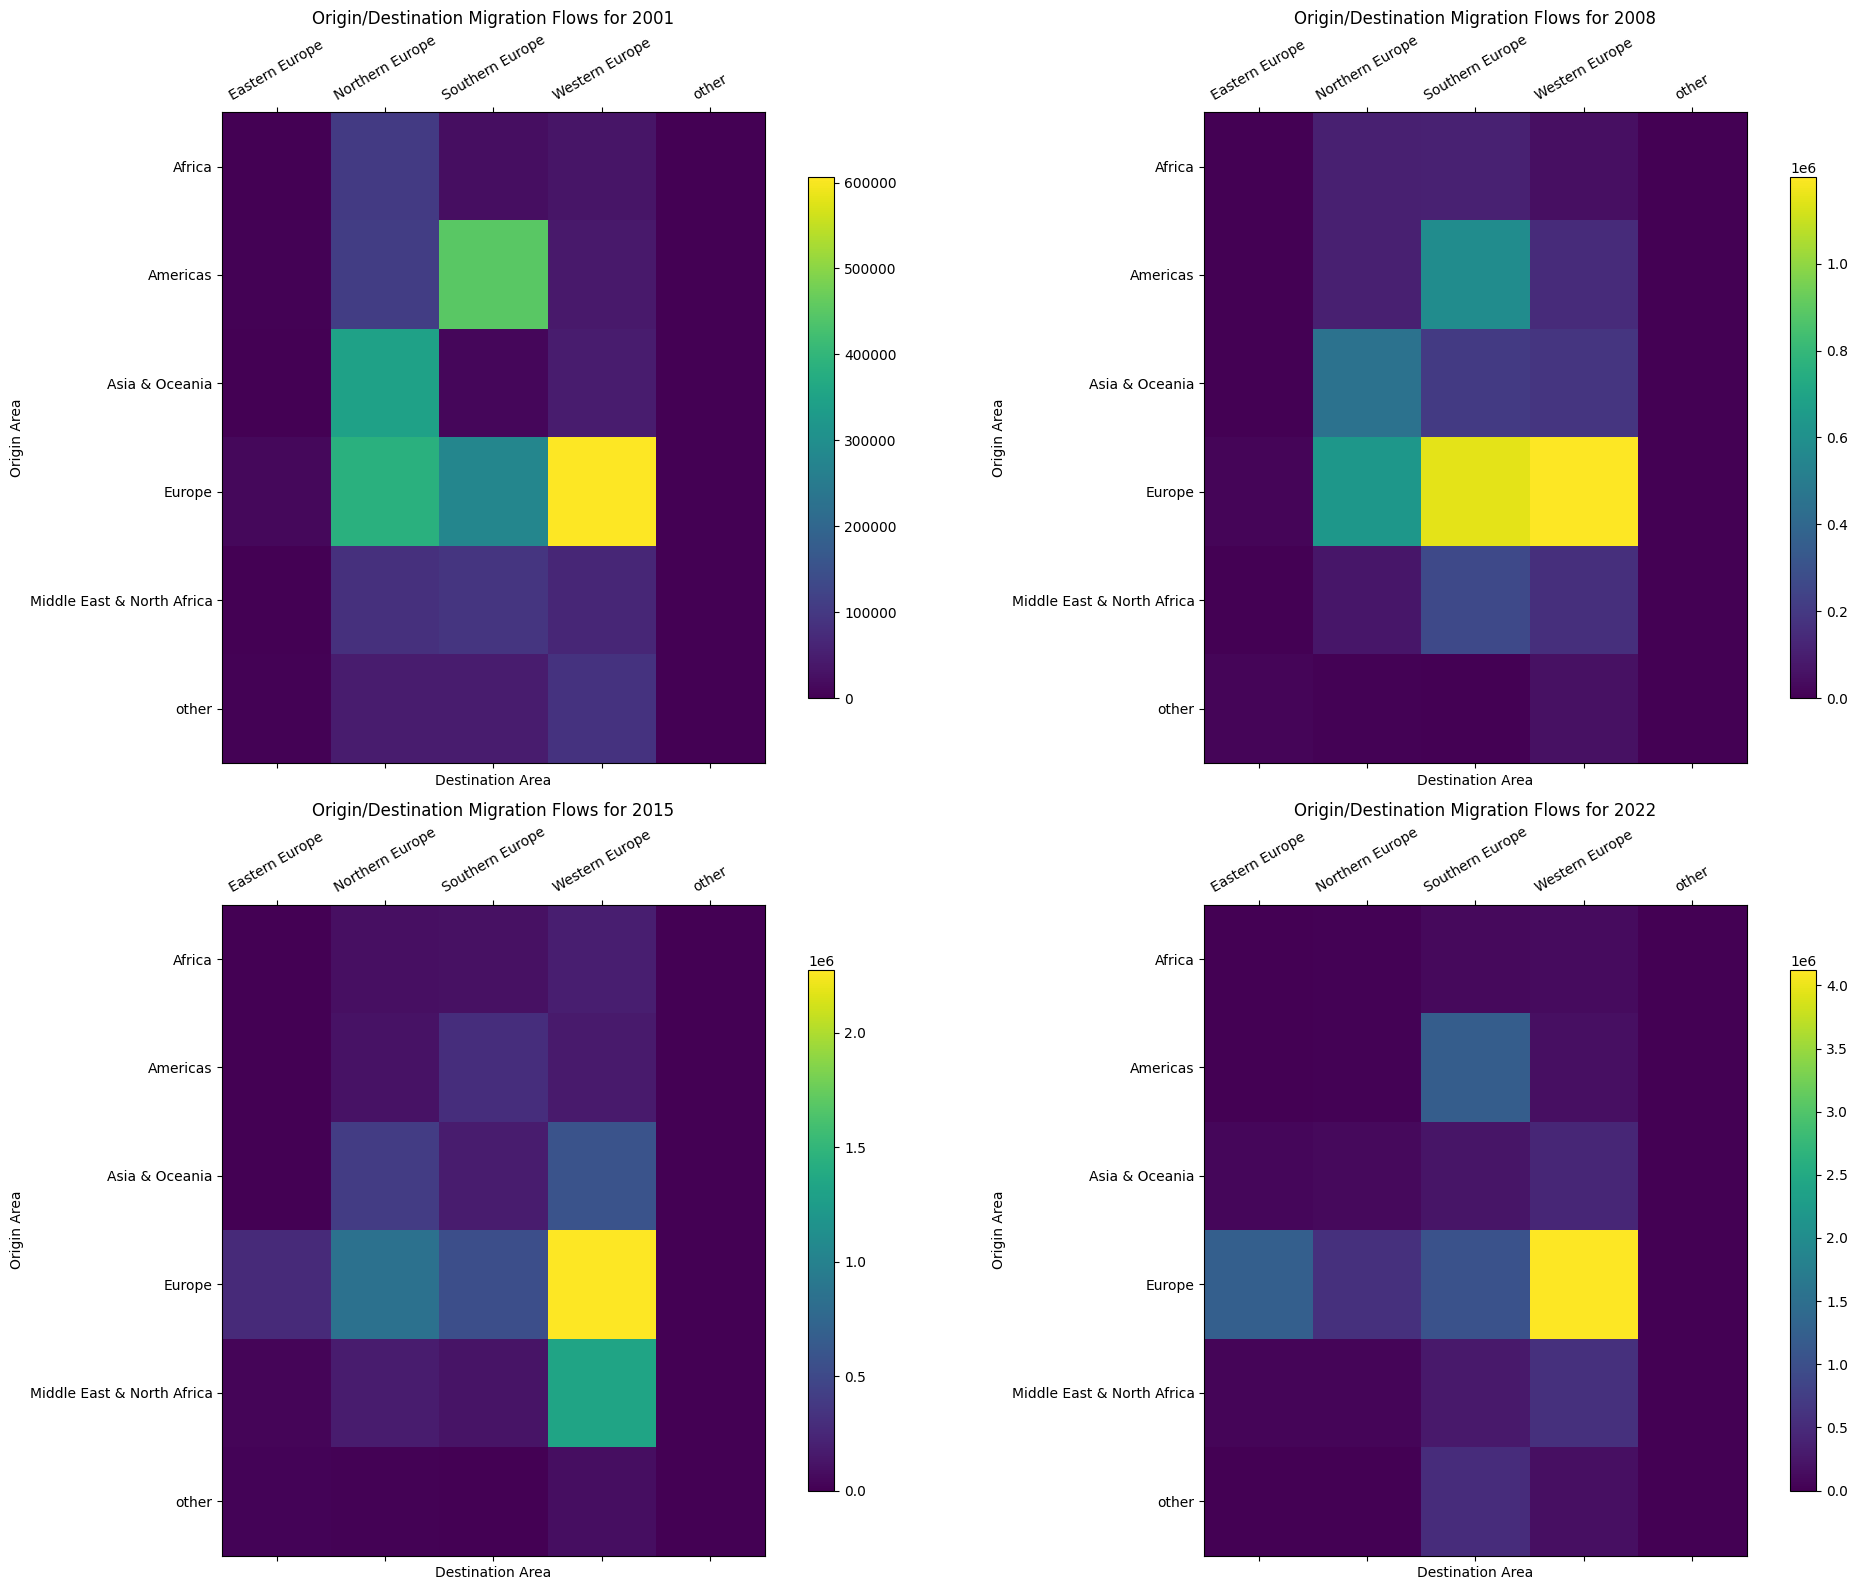

Origin countries categorised as 'other':
 ['AM' 'AN' 'AQ' 'AZ' 'CX' 'CZ_SK' 'EX_SU' 'EX_YU' 'FK' 'FO' 'GE' 'GG' 'GI'
 'GS' 'IM' 'JE' 'KZ' 'MS' 'OTH' 'PM' 'POL' 'RS_ME' 'SH' 'SJ' 'TF' 'UNK']


In [365]:
# define global origin areas
europe = ['AD', 'AL', 'AT', 'BA', 'BE', 'BG', 'BY', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 'SM', 'UA', 'VA', 'XK']
americas = ['AG', 'AI', 'AR', 'AW', 'BB', 'BL', 'BM', 'BO', 'BQ', 'BR', 'BS', 'BZ', 'CA', 'CL', 'CO', 'CR', 'CU', 'CW', 'DM', 'DO', 'EC', 'GD', 'GL', 'GT', 'GY', 'HN', 'HT', 'JM', 'KN', 'KY', 'LC', 'MF', 'MX', 'NI', 'PA', 'PE', 'PR', 'PY', 'SR', 'SV', 'SX', 'TC', 'TT', 'US', 'UY', 'VC', 'VE', 'VG', 'VI']
asia_oceania = ['AF', 'AS', 'AU', 'BD', 'BN', 'BT', 'CC', 'CK', 'CN', 'FJ', 'FM', 'GU', 'HK', 'ID', 'IN', 'IO', 'JP', 'KG', 'KH', 'KI', 'KP', 'KR', 'LA', 'LK', 'MH', 'MM', 'MN', 'MO', 'MP', 'MV', 'MY', 'NC', 'NF', 'NP', 'NR', 'NU', 'NZ', 'PF', 'PG', 'PH', 'PK', 'PN', 'PW', 'SB', 'SG', 'TH', 'TJ', 'TK', 'TL', 'TM', 'TO', 'TV', 'TW', 'UZ', 'VN', 'VU', 'WF', 'WS']
africa = ['AO', 'BF', 'BI', 'BJ', 'BW', 'CD', 'CF', 'CG', 'CI', 'CM', 'CV', 'DJ', 'ER', 'ET', 'GA', 'GH', 'GM', 'GN', 'GQ', 'GW', 'KE', 'KM', 'LR', 'LS', 'MG', 'ML', 'MR', 'MU', 'MW', 'MZ', 'NA', 'NE', 'NG', 'RW', 'SC', 'SD', 'SL', 'SN', 'SO', 'SS', 'ST', 'SZ', 'TD', 'TG', 'TZ', 'UG', 'YT', 'ZA', 'ZM', 'ZW']
middle_east_north_africa = ['AE', 'BH', 'DZ', 'EG', 'EH', 'IQ', 'IR', 'IL', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM', 'PS', 'QA', 'SA', 'SY', 'TN', 'TR', 'YE']

globalAreas = {'Europe': europe, 'Americas': americas, 'Asia & Oceania': asia_oceania, 'Africa': africa, 'Middle East & North Africa': middle_east_north_africa}


# define european destination areas
western_europe = ['AT', 'BE', 'CH', 'DE', 'FR', 'LI', 'LU', 'NL']
eastern_europe = ['BG', 'BY', 'CZ', 'HU', 'MD', 'PL', 'RO', 'RU', 'SK', 'UA', 'AZ', 'UZ', 'AM', 'TJ', 'GE']
northern_europe = ['DK', 'EE', 'FI', 'IE', 'IS', 'LT', 'LV', 'NO', 'SE', 'GB']
southern_europe = ['CY', 'ES', 'HR', 'IT', 'ME', 'MK', 'MT', 'PT', 'SI', 'EL', 'TR', 'BA', 'SM']

europeanAreas = {'Western Europe': western_europe, 'Eastern Europe': eastern_europe, 'Northern Europe': northern_europe, 'Southern Europe': southern_europe}



# Functions required for categorisation
other = []
def categorize_global(country):
    for name, areaList in globalAreas.items():
        if country in areaList:
            return name
    else:
        other.append(country)
        return "other"

def categorize_europe(country):
    for name, areaList in europeanAreas.items():
        if country in areaList:
            return name
    else:
        return "other"


# years to look at
years = ["2001", "2008", "2015", "2022"]

# set up plot and subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.ravel()  # Flatten the 2x2 array to make it easier to iterate

# iterate through years to generate plots
for i, year in enumerate(years):
    dfMixed = dfFull[(dfFull["age"] == "TOTAL") & (dfFull["sex"] == "T") & (dfFull['origin'] != 'TOTAL')].copy(deep=True)

    # categorise
    dfMixed['Origin_Area'] = dfMixed['origin'].apply(categorize_global)
    dfMixed['Destination_Area'] = dfMixed['destination'].apply(categorize_europe)

    ptMixed = dfMixed.pivot_table(values=year, index=["Origin_Area"], columns="Destination_Area", aggfunc="sum")

    # Plot the heatmap
    im = axs[i].matshow(ptMixed.values, 
                   cmap='viridis',
                   aspect='equal')

    # Add colorbar
    plt.colorbar(im, ax=axs[i], shrink=0.8)

    # Set x and y tick labels
    axs[i].set_xticks(np.arange(len(ptMixed.columns)))
    axs[i].set_yticks(np.arange(len(ptMixed.index)))
    axs[i].set_xticklabels(ptMixed.columns, rotation=30, ha='center')
    axs[i].set_yticklabels(ptMixed.index)

    # Add title and labels
    axs[i].set_title(f'Origin/Destination Migration Flows for {year}')
    axs[i].set_xlabel('Destination Area')
    axs[i].set_ylabel('Origin Area')

# Adjust layout to prevent cutting off labels~
plt.tight_layout()

plt.show()

print("Origin countries categorised as 'other':\n", np.unique(other))

As we can see, for all analysed years the migration from Europe dominates. Specifically, there seems to be a strong trend for european citizens to migrate towards western europe for all years (apart from 2008 where european migration splits for southern europe too). Interestingly for the early 2000nds we also see higher migration from Asia & Oceania into norther europe and from the americas into southern europe, which has suprised me. As expected, during the migration "crisis" there was also a strong contribution from the Middle Eeast & North Africa. For 2022 we also see the impact from the Covid pandemic, with global migration being severly reduced. Lastly, it's interesting to see that there is very little migration into eastern europe and where there are nonzero numbers, they are coming from the rest of europe. Excluding europe, migration from the americas seems to dominate with also Asia & Oceania as common destination countries (outside of 2015).

## SQ 3: Demographic Trends
Lastly then, we also want to address subquestion 3 and examine the demographic trends within the migration data. While there is solid coverage for sex, fewer countries report age uniformly (or at all). Since we are however interested in *relative* comparisons (between the age categories), we don't see a major problem in limiting our analysis to the countries that did actually report detailed age information, while simply omitting the destination countries that did not.

### By Age
Let's first look at the development of the distribution of age over the year. For this, we reuse the horizontal stacked bar chart from earlier, but adapt it to normalise each yearly bar (since we are interested in proportions). In order to make plot more understandable, we decrease resolution of the age categories to 10-year intervals

In [366]:
def create_flexible_stacked_horizontal_bar_charts_normalized(categories, data_sets, color_map, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    y_pos = np.arange(len(categories))
    bar_height = 0.6
    
    all_subcategories = set()
    for data in data_sets:
        all_subcategories.update(data.keys())
    
    legend_elements = []
    
    for i, (category, data) in enumerate(zip(categories, data_sets)):
        total = sum(data.values())
        start = 0
        j = 0
        for subcategory, value in data.items():
            # Normalize the value
            normalized_value = value / total if total > 0 else 0
            
            bar = ax.barh(y_pos[i], normalized_value, bar_height, left=start, 
                          color=color_map[subcategory])
            
            # Add text in the middle of the bar segment (but only for the large enough bars in the middle)
            if (j < 6):
                text_x = start + normalized_value / 2
                ax.text(text_x, y_pos[i], f'{normalized_value * 100:.1f}%', 
                        ha='center', va='center',
                        color='black', fontsize=8)

            j += 1
            start += normalized_value
            
            # Add to legend elements if not already there
            if subcategory not in [le.get_label() for le in legend_elements]:
                legend_elements.append(plt.Rectangle((0,0),1,1, 
                                       color=color_map[subcategory], 
                                       label=subcategory))
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories)
    ax.invert_yaxis()
    ax.set_xlabel('Proportion of Migration Flow')
    ax.set_title(title)
    
    # Add the legend with all unique subcategories
    ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.1, 0))
    
    # Set x-axis to percentage
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    plt.tight_layout()
    plt.show()


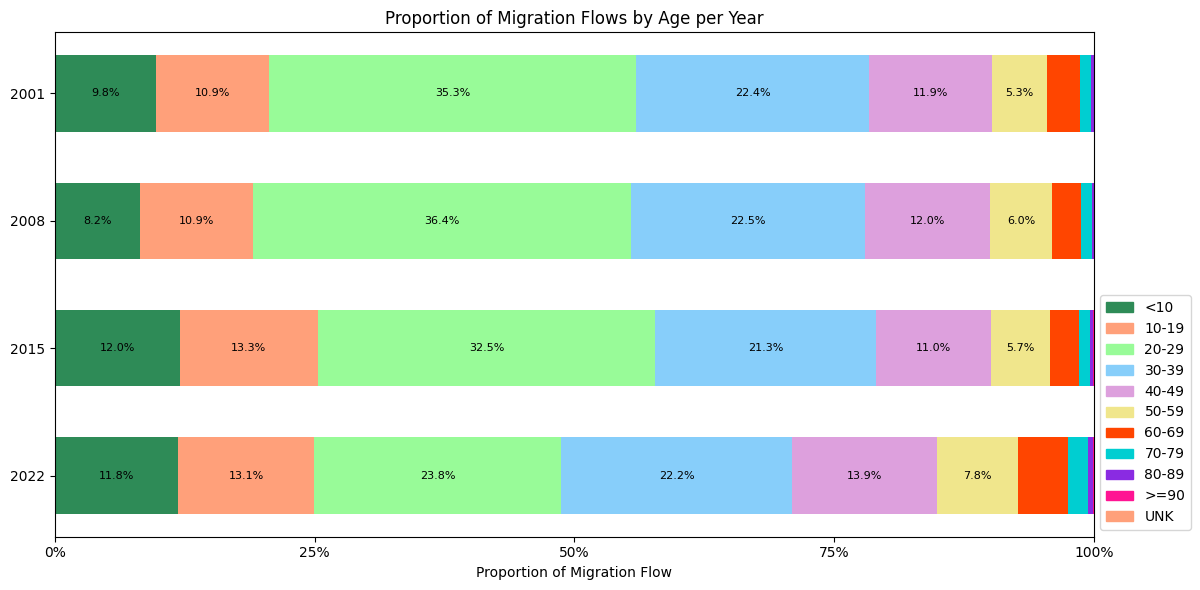

In [367]:
dfAge = dfFull[((dfFull["sex"] == "T") & (dfFull["origin"] == "TOTAL"))].drop(columns= ["origin", "sex"])

# exclude aggregate ages and ages that have a different resolution
aggregate_ages = ['TOTAL', 'Y15-64', 'Y_GE65', 'Y_LT15','Y_GE85']
dfAge = dfAge[~dfAge["age"].isin(aggregate_ages)]

years = ["2001", "2008", "2015", "2022"]
datasets = []
countries = []

# reduce resolution of age categories
newCategories = {'Y25-29': ("20-29",2),
 'Y20-24': ("20-29",2),
 'Y30-34': ("30-39",3),
 'Y35-39': ("30-39",3),
 'Y15-19': ("10-19",1),
 'Y40-44': ("40-49",4),
 'Y_LT5': ("<10",0),
 'Y45-49': ("40-49",4),
 'Y5-9': ("<10",0),
 'Y10-14': ("10-19",1),
 'Y50-54': ("50-59",5),
 'Y55-59': ("50-59",5),
 'Y60-64': ("60-69",6),
 'Y65-69': ("60-69",6),
 'Y70-74': ("70-79",7),
 'Y75-79': ("70-79",7),
 'Y80-84': ("80-89",8),
 'Y85-89': ("80-89",8),
 'Y90-94': (">=90",9),
 'UNK': ("UNK",10),
 'Y95-99': (">=90",9),
 'Y_GE100': (">=90",9)}


for year in years:
    rep = dfAge.groupby(["age"]).sum()
    rep['ageCat'] = rep.index.map(lambda x: newCategories[x][0])
    rep['idx'] = rep.index.map(lambda x: newCategories[x][1])
    detailedReport = rep[["ageCat", year, "idx"]].groupby(["ageCat"]).agg({year: "sum", "idx": "first"}).sort_values("idx")[year].to_dict()

    datasets.append(detailedReport)
    countries.append(list(detailedReport.keys()))

# get the colors
colorList = ['#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD','#F0E68C', '#FF4500', '#00CED1', '#8A2BE2', '#2E8B57', '#FF1493', '#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD','#F0E68C', '#FF4500', '#00CED1', '#8A2BE2', '#2E8B57', '#FF1493']
colors = {}
for i, country in enumerate(np.unique(countries)):
    colors[country] = colorList[i]

create_flexible_stacked_horizontal_bar_charts_normalized(years, datasets, colors, "Proportion of Migration Flows by Age per Year")


While on first sight there aren't any major changes in the age distribution over the years, there are some minor ones. The biggest change is the significant reduction of immigrants of 20-29 years after 2015. Also, after 2008 more children (especially below the age of 10) immigrated. There was also an increase in older people, with increasing percentage of people of 50-59 and 60-69 years as well as a minor increase of people of 40-49 years of age.

### By Sex
Next, we want to look at the comparison between male and female migration. We do so first, by looking at the overall development over the years. Afterwards, we check if there are major differences between the age categories for a given year. Given the level of detail between sex and age, it is however a bit difficult to display the development over the year, which is why we focus on a single year (2022).

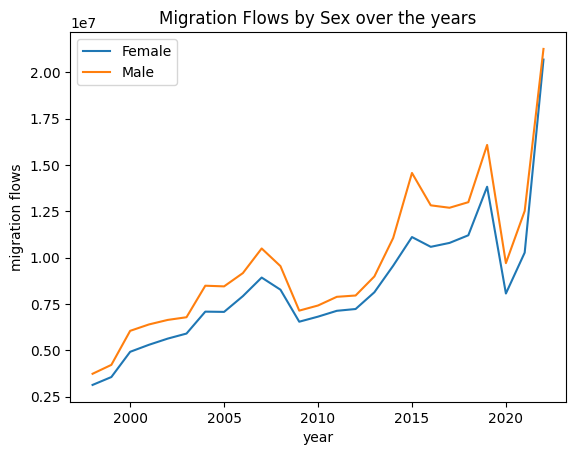

In [368]:
dfTime = dfFull[(dfFull["origin"] == "TOTAL") & (dfFull["destination"] != "EU27_2020") & (dfFull["sex"] != "T")].groupby("sex").sum().drop(columns=["origin", "destination", "age"])
plt.plot(range(1998, 2023), dfTime.loc["F"].values, label= "Female")
plt.plot(range(1998, 2023), dfTime.loc["M"].values, label= "Male")
plt.legend()
plt.title("Migration Flows by Sex over the years")
plt.xlabel("year")
plt.ylabel("migration flows")
plt.show()

New and insightful information is limited here, but we can see that male immigration is consistently higher than female and that the difference increaced during the migration "crisis", but decrease in recent years.

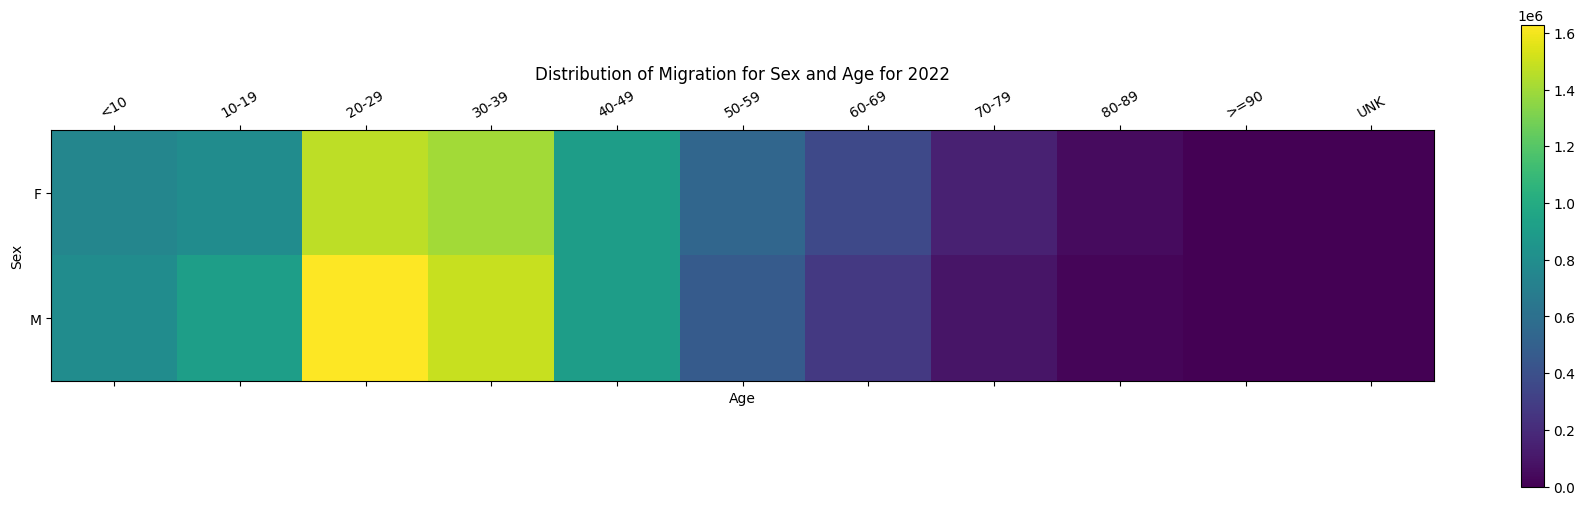

In [369]:
year = "2022"

dfMixed = dfFull[(dfFull["origin"] == "TOTAL") & (dfFull["destination"] != "EU27_2020") & (dfFull["sex"] != "T")].copy(deep= True)
aggregate_areas = ['TOTAL', 'Y15-64', 'Y_GE65', 'Y_LT15','Y_GE85']
dfMixed = dfMixed[~dfMixed["age"].isin(aggregate_areas)]
dfMixed["ageCat"] = dfMixed["age"].map(lambda x: newCategories[x][0])
dfMixed["idx"] = dfMixed["age"].map(lambda x: int(newCategories[x][1]))
dfMixed = dfMixed.sort_values("idx")

# create pivot table
ptMixed = dfMixed.pivot_table(values=year, index=["sex"], columns="ageCat", aggfunc="sum")
ptMixed = ptMixed[['<10', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '>=90', 'UNK']]


# start plot
fig, ax = plt.subplots(figsize=(18, 8))

# Plot the heatmap
im = ax.matshow(ptMixed.values, 
               cmap='viridis',  # Nice color theme
               aspect='equal')  # Make plot squared

# Add colorbar
plt.colorbar(im, ax=ax, shrink=0.6)

# Set x and y tick labels
ax.set_xticks(np.arange(len(ptMixed.columns)))
ax.set_yticks(np.arange(len(ptMixed.index)))
ax.set_xticklabels(ptMixed.columns, rotation=30, ha='center')
ax.set_yticklabels(ptMixed.index)

# Add title and labels
plt.title(f'Distribution of Migration for Sex and Age for {year}')
plt.xlabel('Age')
plt.ylabel('Sex')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

Based on this plot, we can see that there are no major differences between male and female immigration. As expected based on the time-evolution above, for most ages male immigration is slightly higher. Suprisingly, there does not seem to be a difference for 40-49 year-olds though

# Recap of Questions and Answers
Apart from subquestion 2 (which we neglected based on the non-availabilty of proper data), we think the questions have been nicely answered. This is more so the case for subquestion 2 (regional differences and trends), where the stacked bar plot, the choropleth and the heatmap have provided thourough insight into the data. For subqestion 3 (demographics), we the resolution of age groups, at least for us, has provided an interesting breakdown. While this was not so much the case for the sex data, this is mostly due to there not being major differences between male and female immigration (which is an important insight itself). Overall also, all obtained answers seem very plausible, alhtough (of course) the reasons for those answers are not available to us (e.g. it would be interesting to know why Germany has the highest immigration numbers)

The main difficulty in actually visualising the data, in our opinion, is that it's difficult to look at more than 1 (categorical) properties within a single plot. E.g. we can generate a choropleth of overall immigration into european countries, but providing additional time-, origin- or age-resolution, tends to blow up the plots and thus make them hardly understandable. 

With regards to bias, we think the most relevant aspect here is that there might be bias involved based on some countries not (consistently) reporting values or more detailed breakdown. Additionally, for the category there might a tendency to adapt the "true age" to an age that is more favourable for european immigration policy, the question however is if that is even relevant for the given categorisation. Lastly then, one should be aware, that the reported data is the *country of previous residence* and not actual country of origin or birth. The analysis still provides similar insight though. Apart from that, we think that european, and specifically migration data, is *for the most part* reliable to use.

# Merging of General Population- and Migration Data
For the prediction of migration, we combine the migration data with the detailed population data from question 1. Both datasets can be resolved to multi-index with country and year and can thus be easily joined. For the immigration data, since we don't need more detailed information and this information would also not be consistent, we simply take the totals for origin, age and sex. Similary to exercise 1A, we melt the yearly columns into one column in order to be able to set them as part of the index. Lastly, since up until now we used the years in string format, we simply convert them to integers. Given that the immigration data only provides a small addition to the population data (since overall net migration was already included), we omit further correlation analysis at this point (since this was already done in the population analysis for question 1).

In [370]:
population_data = combined_df.copy()
population_data.head()

employment_rate  gdp  crimes  crimes_adjusted    hdi Location  \
country year                                                                  
AM      2012              NaN  NaN     NaN              NaN  0.751  Armenia   
        2013              NaN  NaN     NaN              NaN  0.757  Armenia   
        2014              NaN  NaN     NaN              NaN  0.764  Armenia   
        2015              NaN  NaN     NaN              NaN  0.769  Armenia   
        2016              NaN  NaN     NaN              NaN  0.773  Armenia   

              TPopulation1Jan  PopDensity  NatChangeRT  PopGrowthRate  Births  \
country year                                                                    
AM      2012         2922.641    102.6745        5.668         -0.008  45.208   
        2013         2922.414    102.6742        5.634          0.007  45.139   
        2014         2922.622    102.6708        5.252         -0.014  44.017   
        2015         2922.222    102.6271        4.498         -0.072  41.785   
        2016         2920.133    102.5433        4.115         -0.092  40.595   

                 CBR     TFR  Deaths    CDR      LEx  Under5Deaths     Q1560  \
country year                                                                   
AM      2012  15.469  1.6474  28.645  9.801  73.4396         0.757  132.6213   
        2013  15.445  1.6689  28.673  9.811  73.7131         0.721  129.6448   
        2014  15.062  1.6634  28.669  9.810  73.9800         0.673  126.9438   
        2015  14.304  1.6207  28.646  9.806  74.2290         0.615  124.6434   
        2016  13.908  1.6248  28.584  9.793  74.4937         0.567  122.2607   

              NetMigrations   CNMR  
country year                        
AM      2012        -16.782 -5.742  
        2013        -16.265 -5.565  
        2014        -15.745 -5.388  
        2015        -15.225 -5.212  
        2016        -14.697 -5.035

In [371]:
immigrationPerCountry = dfFull[(dfFull["origin"] == "TOTAL") & (dfFull["age"] == "TOTAL") & (dfFull["sex"] == "T")].drop(columns=["origin", "age", "sex"])

immigrationPerCountry = immigrationPerCountry.sort_values("destination").set_index("destination", drop= True).drop_duplicates().reset_index().sort_values("destination")
immigrationPerCountry.rename(columns={"destination": "country"}, inplace=True)

immigrationPerCountry = pd.melt(immigrationPerCountry, id_vars= "country", value_vars= [str(i) for i in range(1998, 2023)], value_name="immigration", var_name="year")
immigrationPerCountry["year"] = immigrationPerCountry["year"].astype(int)
immigrationPerCountry.set_index(["country", "year"], inplace= True)
immigrationPerCountry.head()

immigration
country year             
AM      1998          NaN
AT      1998      72723.0
AZ      1998          NaN
BA      1998          NaN
BE      1998      83812.0

In [372]:
# determine none-overlap
populationCountries = np.unique(population_data.index.get_level_values(0))
immigrationCountries = np.unique(immigrationPerCountry.index.get_level_values(0))
print("Number of countries in population data:", len(populationCountries))
print("Number of countries in immigration data:", len(immigrationCountries))

popMissingFromImm = np.setdiff1d(populationCountries, immigrationCountries)
immMissingFromPop = np.setdiff1d(immigrationCountries, populationCountries)

print("Population countries missing from immigration data:", popMissingFromImm)
print("Immigration countries missing from population data:", immMissingFromPop)

Number of countries in population data: 49
Number of countries in immigration data: 47
Population countries missing from immigration data: ['AD' 'AL' 'MC' 'RS' 'UA' 'XK']
Immigration countries missing from population data: ['IL' 'KG' 'TJ' 'UZ']


Looking at the intersection analysis from above, we can see that there are a few countries that don't appear in both datasets, but they are negligible. Interestingly, Ukraine is listed as not being in the immigration dataset. This is technically not true since UA is indeed listed in the original immigration data, but when looking more closely, one can see that there no numbers reported by ukraine

In [373]:
joined_data = population_data.join(immigrationPerCountry, how='inner')
joined_data.head()

employment_rate  gdp  crimes  crimes_adjusted    hdi Location  \
country year                                                                  
AM      2012              NaN  NaN     NaN              NaN  0.751  Armenia   
        2013              NaN  NaN     NaN              NaN  0.757  Armenia   
        2014              NaN  NaN     NaN              NaN  0.764  Armenia   
        2015              NaN  NaN     NaN              NaN  0.769  Armenia   
        2016              NaN  NaN     NaN              NaN  0.773  Armenia   

              TPopulation1Jan  PopDensity  NatChangeRT  PopGrowthRate  ...  \
country year                                                           ...   
AM      2012         2922.641    102.6745        5.668         -0.008  ...   
        2013         2922.414    102.6742        5.634          0.007  ...   
        2014         2922.622    102.6708        5.252         -0.014  ...   
        2015         2922.222    102.6271        4.498         -0.072  ...   
        2016         2920.133    102.5433        4.115         -0.092  ...   

                 CBR     TFR  Deaths    CDR      LEx  Under5Deaths     Q1560  \
country year                                                                   
AM      2012  15.469  1.6474  28.645  9.801  73.4396         0.757  132.6213   
        2013  15.445  1.6689  28.673  9.811  73.7131         0.721  129.6448   
        2014  15.062  1.6634  28.669  9.810  73.9800         0.673  126.9438   
        2015  14.304  1.6207  28.646  9.806  74.2290         0.615  124.6434   
        2016  13.908  1.6248  28.584  9.793  74.4937         0.567  122.2607   

              NetMigrations   CNMR  immigration  
country year                                     
AM      2012        -16.782 -5.742          NaN  
        2013        -16.265 -5.565          NaN  
        2014        -15.745 -5.388          NaN  
        2015        -15.225 -5.212          NaN  
        2016        -14.697 -5.035          NaN  

[5 rows x 21 columns]

# 3. Predictions

# 3.1. Population Prediction

- Can we predict population development (in 3/5/10 years), based on recent data?
- How will the european population develop in the next 5 years?

The goal of this part of the project is to build models that can reliably predict the population growth of European countries. For this we will utilize the prepared UN World Population data set with its full range of 1950-2023 because it has a reasonable time range and next to no missing values.

## Selecting the predictors:

Since the dataset is already preprocessed we can directly begin by looking at the variables we keep for the prediction and what is not of value for the model. For this we will plot the correlation matrix of the whole dataset as a first step.

In [374]:
def plot_corr_matrix(df, columns, figsize = 20):

    correlations = df.loc[:,columns].corr()
    
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations, cmap=colormap, annot=True, fmt=".2f")

    plt.show()

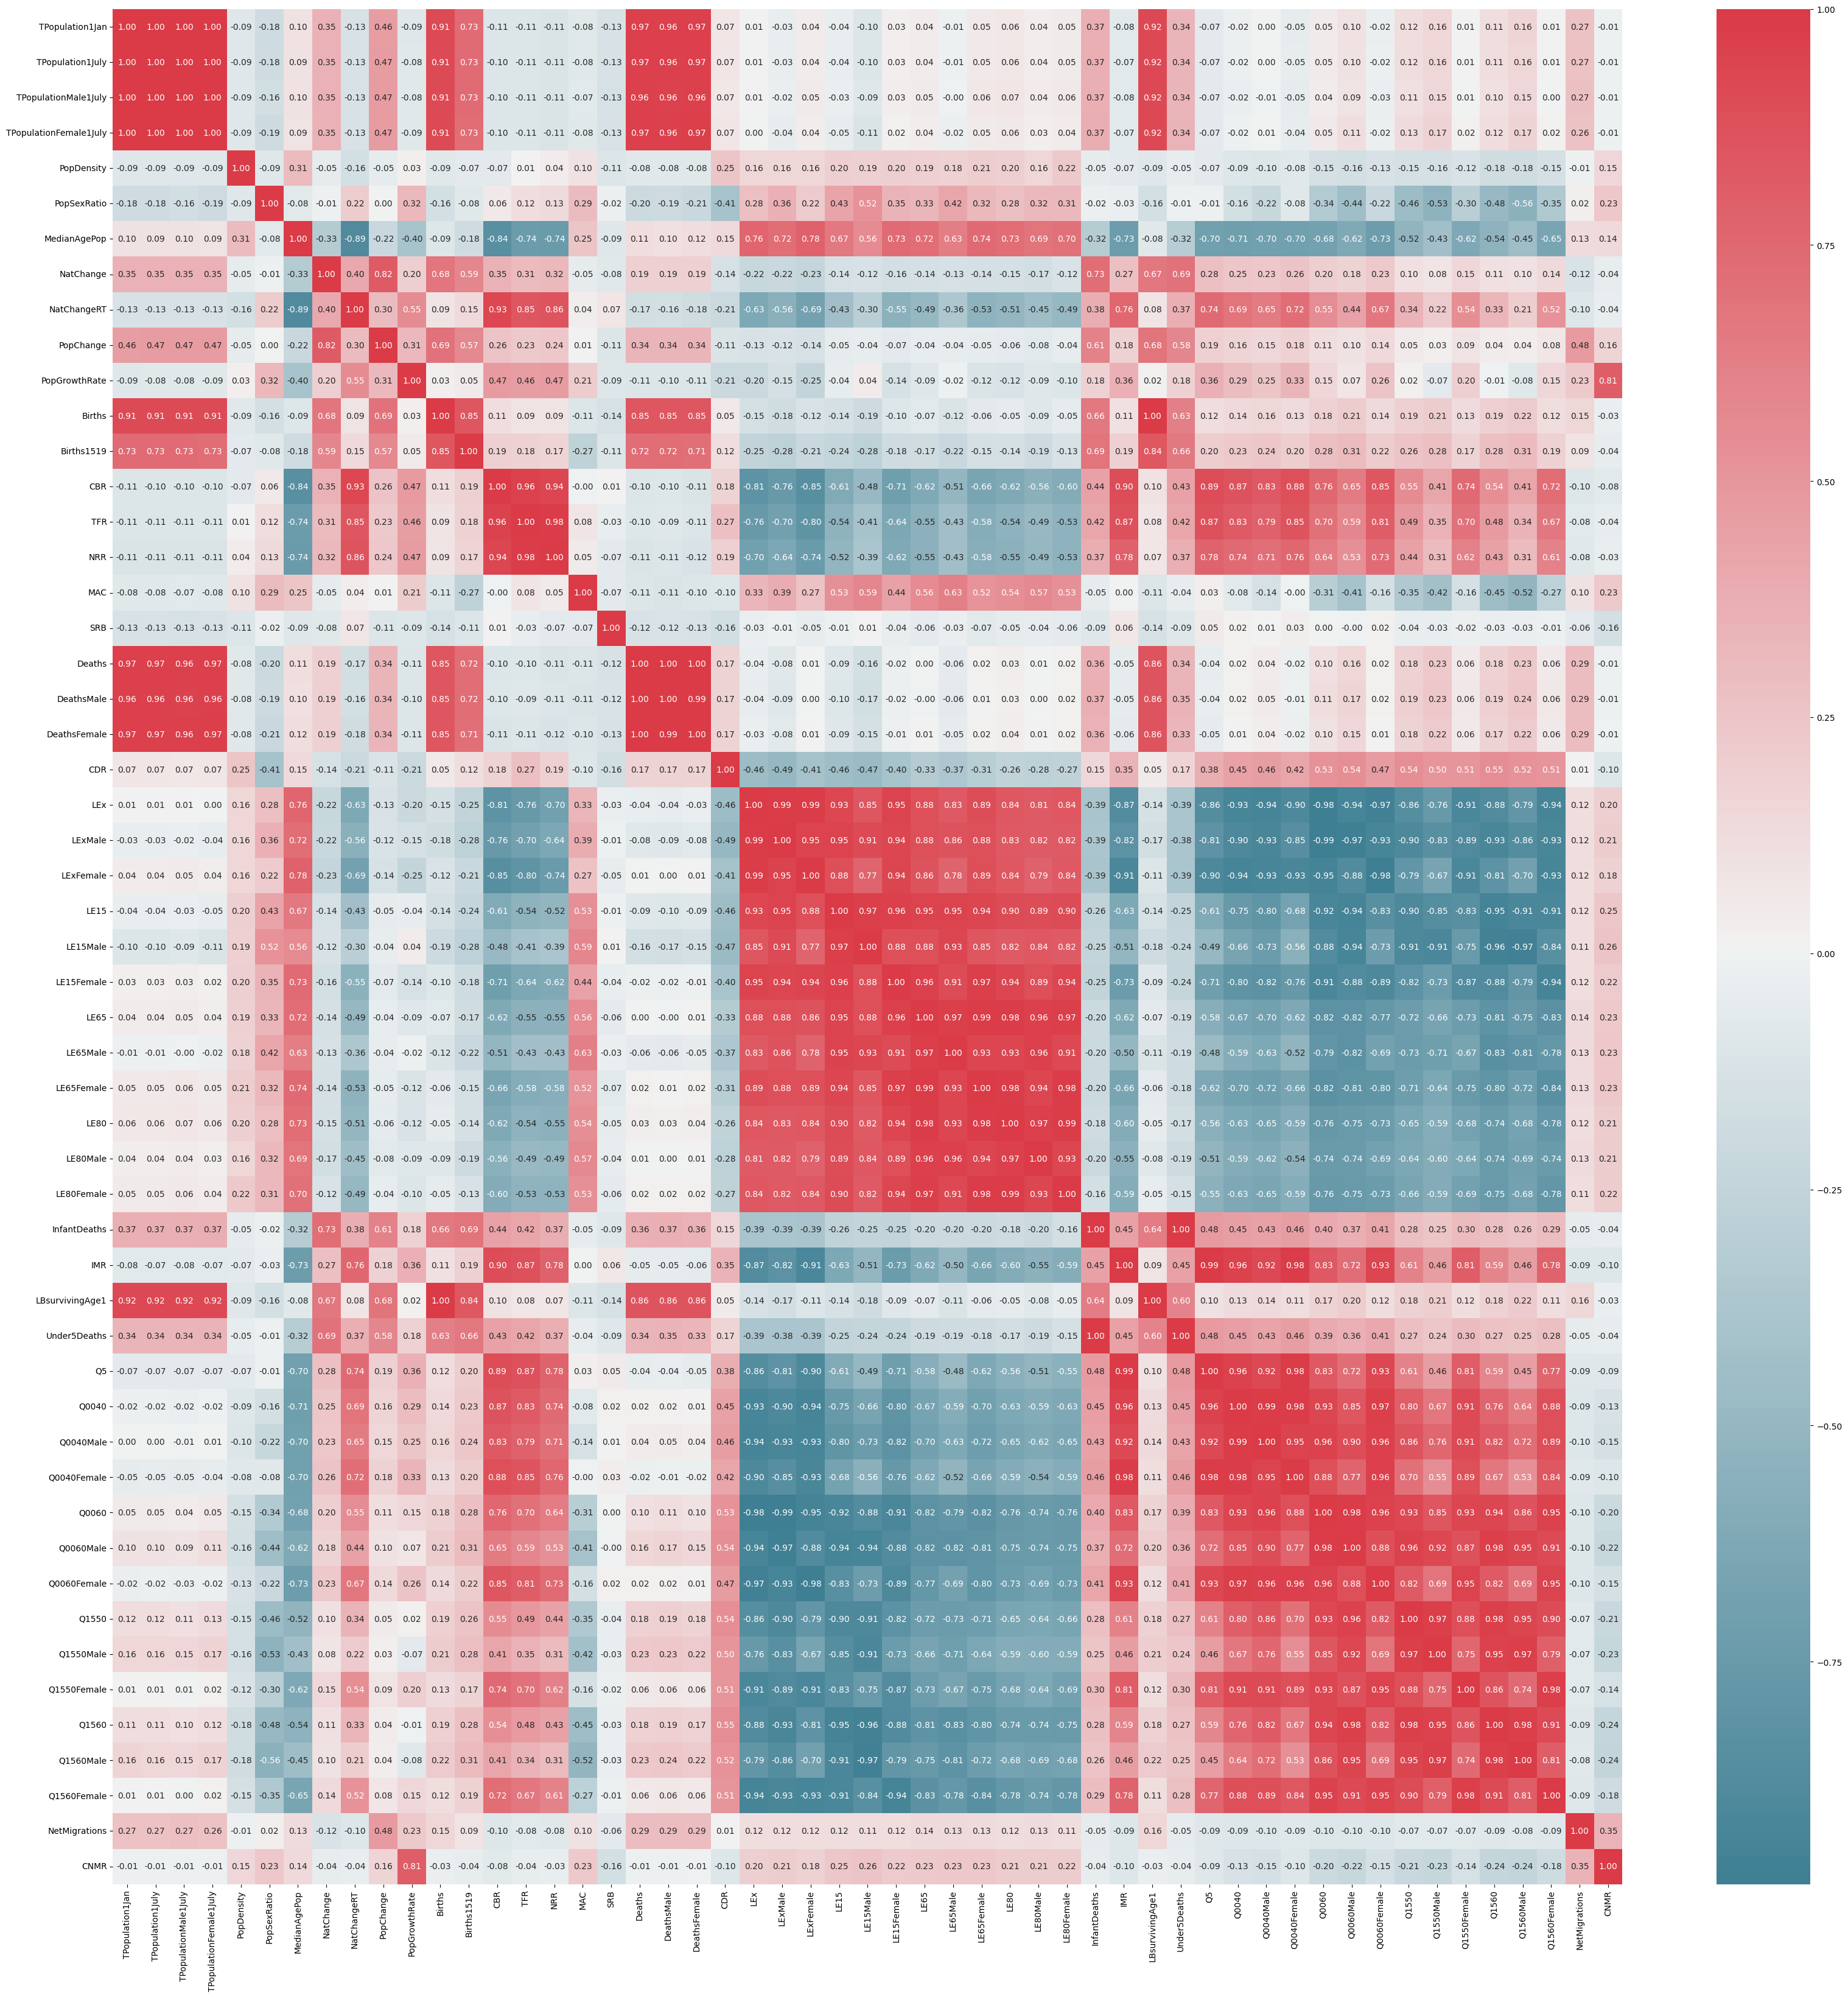

In [375]:
num_cols = un_world_pop_df.columns[4:] # get all columns with numerical data
plot_corr_matrix(un_world_pop_df,num_cols,40) # generates a very big plot

As expected a lot of predictors are correlated to each other given the amount of variables and their structure. The methodology report of the UN gives a clearer overview over which variables got derived from others (https://www.un.org/development/desa/pd/content/world-population-prospects-2024-methodology-report). Therefore a lot of columns can be removed without losing any information. The removed columns and why they where removed can be seen in detail in the next cell:

In [376]:
cols_to_remove=["TPopulation1Jan", # predictions will be for Jul 1 making Jan 1 redundant
                "TPopulationMale1July", "TPopulationFemale1July", # expressed in Sex Ratio
                "PopDensity", # no practical info for our model
                "MedianAgePop", # dropped in favor of life expectancy
                "NatChangeRT", # derived from birth, death and migration indicators
                "PopChange", "PopGrowthRate", # derived from birth, death and migration indicators
                "NatChange", #  derived from birth and death indicators
                "Births", "Births1519", "SRB", "CBR", "NRR", # birth indicators will be dropped in favor of fertility rate
                "Deaths", "DeathsMale", "DeathsFemale","CDR", # death indicators will be dropped because of high correlation with population indicators
                "LExMale", "LExFemale", "LE15", "LE15Male", "LE15Female", "LE65", "LE65Male", "LE65Female", "LE80", "LE80Male", "LE80Female", # only total life expectancy kept
                "IMR", "LBsurvivingAge1", "InfantDeaths", "Under5Deaths", "Q5", "Q0040", "Q0040Male", "Q0040Female", "Q0060", # Mortalities excluded because of life expectancy included
                "Q0060Male", "Q0060Female", "Q1550", "Q1550Male", "Q1550Female", "Q1560", "Q1560Male", "Q1560Female", # Mortalities excluded because of life expectancy included
                "CNMR"] # dropped in favor of net number of migrants

In [377]:
def remove_cols(df, labels):
    df_removed = df.copy()
    df_removed = df_removed.drop(labels=labels,axis=1)
    return df_removed

un_world_pop_df_shortened = remove_cols(un_world_pop_df,cols_to_remove)
un_world_pop_df_shortened.head()

ISO3_code ISO2_code Location  Time  TPopulation1July  PopSexRatio  \
59736       ARM        AM  Armenia  1950          1382.895      91.8097   
59737       ARM        AM  Armenia  1951          1417.284      92.0740   
59738       ARM        AM  Armenia  1952          1454.107      92.3362   
59739       ARM        AM  Armenia  1953          1493.578      92.5959   
59740       ARM        AM  Armenia  1954          1535.978      92.8541   

          TFR     MAC      LEx  NetMigrations  
59736  4.9045  30.244  54.5541          9.013  
59737  4.8520  30.226  55.0359          9.309  
59738  4.8079  30.205  55.5107          9.722  
59739  4.7923  30.183  55.9801         10.131  
59740  4.7955  30.161  56.4433         10.608

Dropping all of these columns leaves us with 5 indicators (excluding Total Population) to build a model. The included predictors contain the population sex ratio, total fertility rate, mean age of childbearing, life expectancy at birth for both sexes and the net migration number.

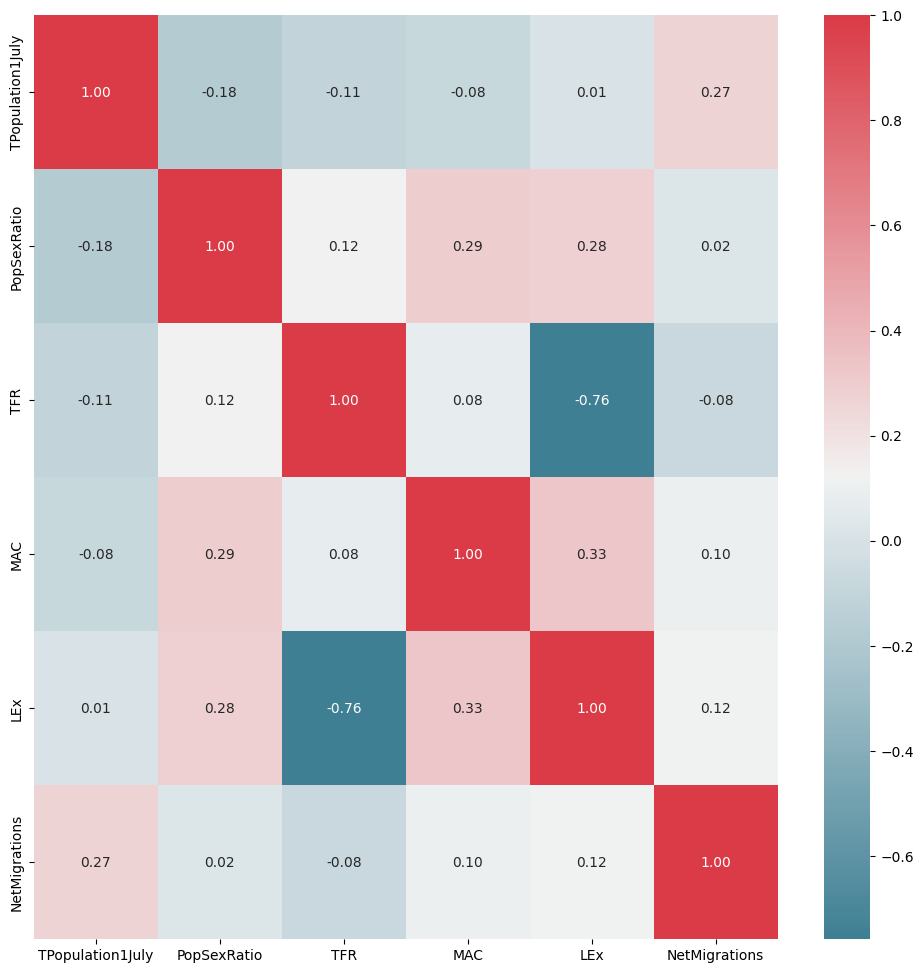

In [378]:
num_cols = un_world_pop_df_shortened.columns[4:]
plot_corr_matrix(un_world_pop_df_shortened, num_cols,12)

## Model Building:

Because the main goal is to predict the future population, we will utilize the Prophet model developed by Meta (https://facebook.github.io/prophet/), which is usually used to forecast time series data, that has strong seasonal trends and holiday effects, e.g  for business decisions, financial planning, etc., but it can be used for our case aswell and generally is a steady model for time series data. The model is mathematically speaking an additive model consisting of the long term trend, a seasonality component and holiday effects, but will be implemented in a way that only the trend component and our additional regressors are used. It works by introducing "changepoints", which are able to allow a slope change for the (in our case) piecewise linear trends, which are modelled. The relationships of our additional regressors to the modelled term are automatically learned during training and their impact is modelled linearly.

### Preprocessing:

The model only needs the target variable to be named "y" and the time column has to be named "ds". We will also drop the remaining unnecessary columns and fix the timestamps of the data.

In [379]:
def preprocess_europe_data(df):
    df = df.copy()
    df = df.rename(
        columns={
            "Location": "region",
            "Time": "ds",
            "TPopulation1July": "y",
            "PopSexRatio": "sex_ratio",
            "TFR": "fertility_rate",
            "MAC": "childbearing_age",
            "LEx": "life_expectancy",
            "NetMigrations": "net_migrants"})
    df["ds"] = pd.to_datetime(df["ds"], format="%Y")
    df["ds"] = df["ds"].apply(lambda x: pd.Timestamp(year=x.year, month=7, day=1))
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df = df.drop(columns=["ISO3_code", "ISO2_code"])
    df = df.sort_values(by=["region", "ds"]).reset_index(drop=True)

    return df

In [380]:
europe_data_prophet = preprocess_europe_data(un_world_pop_df_shortened)

In [381]:
europe_data_prophet.head()
#europe_data_prophet.to_csv("europe_data_prophet.csv", index=False)

region         ds         y  sex_ratio  fertility_rate  childbearing_age  \
0  Albania 1950-07-01  1247.851   104.8635          6.1686            30.975   
1  Albania 1951-07-01  1276.366   103.9256          6.1982            30.881   
2  Albania 1952-07-01  1308.360   103.1153          6.2390            31.060   
3  Albania 1953-07-01  1343.575   102.4029          6.3410            30.866   
4  Albania 1954-07-01  1381.087   101.7427          6.4316            30.799   

   life_expectancy  net_migrants  
0          44.5214         6.757  
1          45.2742         8.626  
2          46.2810        10.481  
3          47.3686        10.962  
4          48.4165        10.158

### Grid Search:

In order to find a good parameter and regressor combination for the different models for all the countries we perform a grid search testing changepoint_prior_scale, which influences the trend flexibility of the model and changepoint_range, which translates to the data range used to detect changepoints. We will also test all combinations of regressors up to a maximum of 3 regressors because of computational limitations and some experimentation with the model has also shown that using to many additional regressors does not really add a lot of prediction power. 

The grid search will be performed with a cross-validation approach by utilizing the sliding window method to avoid data leakage starting with a training set of 48 years (~66%) and a validation set of 6 years and moving forward in time 3 times (again for computational reasons) to cover the whole data range. In the end the model with the lowest RMSE value over all 3 splits will be selected as the best model.

Following this we will also evaluate the grid search on the last 8 years of the data range to see how good our models are. For this we will use the mean absolute percentage error to make all the models comparable.

Note: Grid search code is commented out at the time because it takes some time to run (~20min). Instead the results will be loaded from a .csv file in the following code.

In [382]:
'''
training_years = 48  # 1950–1997
validation_window = 6  # 1998–2015
n_splits = 3
test_years = 8  # 2016–2023
available_regressors = ["sex_ratio", "fertility_rate", "childbearing_age", "life_expectancy", "net_migrants"]
param_grid = {"changepoint_prior_scale": [0.01, 0.05, 0.25], "changepoint_range": [0.8, 0.95]}
all_params = [dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())]
regressor_combinations = [list(comb) for i in range(0, 4) for comb in combinations(available_regressors, i)]

# function to run the CV 
def evaluate_combination(region, params, reg_comb, prophet_data):
    split_metrics = []

    for split in range(n_splits):
        train_end_index = training_years + split * validation_window
        val_start_index = train_end_index
        val_end_index = train_end_index + validation_window

        train_data = prophet_data.iloc[:train_end_index]
        val_data = prophet_data.iloc[val_start_index:val_end_index]

        if len(val_data) == 0:
            continue

        model = Prophet(
            growth="linear",
            yearly_seasonality=False,
            weekly_seasonality=False,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            changepoint_range=params["changepoint_range"],
            interval_width=0.95,
            uncertainty_samples=1000
        )

        for reg in reg_comb:
            model.add_regressor(reg)

        model.fit(train_data)

        future = model.make_future_dataframe(periods=len(val_data), freq="YE")
        for reg in reg_comb:
            future[reg] = train_data[reg].iloc[-1]  # Use last available year for additional regressor data

        forecast = model.predict(future)
        y_pred = forecast["yhat"][-len(val_data):]
        y_true = val_data["y"]

        mse = mean_squared_error(y_true, y_pred)
        rmse = sqrt(mse)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        split_metrics.append({"split": split + 1, "rmse": rmse, "mape": mape})

        avg_rmse = np.mean([metric["rmse"] for metric in split_metrics])
        avg_mape = np.mean([metric["mape"] for metric in split_metrics])

    return {"region": region, "params": params, "regressors": reg_comb, "avg_rmse": avg_rmse,"avg_mape": avg_mape, "split_metrics": split_metrics}
    

# function to evaluate the best model on the test set
def evaluate_on_test_set(region, params, reg_comb, prophet_data, test_years=test_years):
    train_data = prophet_data.iloc[:-(test_years)]
    test_data = prophet_data.iloc[-test_years:]

    model = Prophet(
        growth="linear",
        yearly_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale=params["changepoint_prior_scale"],
        changepoint_range=params["changepoint_range"],
        interval_width=0.95,
        uncertainty_samples=1000
    )

    for reg in reg_comb:
        model.add_regressor(reg)

    model.fit(train_data)

    future = model.make_future_dataframe(periods=test_years, freq="YE")
    for reg in reg_comb:
        future[reg] = train_data[reg].iloc[-1]

    forecast = model.predict(future)
    y_pred = forecast["yhat"][-test_years:]
    y_true = test_data["y"]

    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    return {"region": region, "params": params, "regressors": reg_comb,"rmse": rmse, "mape": mape}

# Main function to perform grid search and final test evaluation
def perform_grid_search(europe_data_prophet):
    regions = europe_data_prophet["region"].unique()

    # Grid search 
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(evaluate_combination)(
            region, params, reg_comb, 
            europe_data_prophet[europe_data_prophet["region"] == region].drop(columns=["region"])
        )
        for region in regions
        for params in all_params
        for reg_comb in regressor_combinations
    )

    # Identify the best parameters per region
    results_df = pd.DataFrame(results)
    best_params_per_region = results_df.loc[results_df.groupby("region")["avg_rmse"].idxmin()]

    # Evaluate the best models on the test set
    test_results = Parallel(n_jobs=-1, backend="loky")(
        delayed(evaluate_on_test_set)(
            row["region"], row["params"], row["regressors"],
            europe_data_prophet[europe_data_prophet["region"] == row["region"]].drop(columns=["region"])
        )
        for _, row in best_params_per_region.iterrows()
    )

    test_results_df = pd.DataFrame(test_results)

    # Save results for review
    best_params_per_region.to_csv("best_params_per_region.csv", index=False)
    test_results_df.to_csv("test_results.csv", index=False)
    return best_params_per_region, test_results_df

best_params_per_region, test_results_df = perform_grid_search(europe_data_prophet)
'''

'\ntraining_years = 48  # 1950–1997\nvalidation_window = 6  # 1998–2015\nn_splits = 3\ntest_years = 8  # 2016–2023\navailable_regressors = ["sex_ratio", "fertility_rate", "childbearing_age", "life_expectancy", "net_migrants"]\nparam_grid = {"changepoint_prior_scale": [0.01, 0.05, 0.25], "changepoint_range": [0.8, 0.95]}\nall_params = [dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())]\nregressor_combinations = [list(comb) for i in range(0, 4) for comb in combinations(available_regressors, i)]\n\n# function to run the CV \ndef evaluate_combination(region, params, reg_comb, prophet_data):\n    split_metrics = []\n\n    for split in range(n_splits):\n        train_end_index = training_years + split * validation_window\n        val_start_index = train_end_index\n        val_end_index = train_end_index + validation_window\n\n        train_data = prophet_data.iloc[:train_end_index]\n        val_data = prophet_data.iloc[val_start_index:val_end_index]\n\n        

In [383]:
best_params_per_region = pd.read_csv("other/best_params_per_region.csv")
best_params_per_region.head()

region                                             params  \
0     Albania  {'changepoint_prior_scale': 0.25, 'changepoint...   
1     Andorra  {'changepoint_prior_scale': 0.01, 'changepoint...   
2     Armenia  {'changepoint_prior_scale': 0.25, 'changepoint...   
3     Austria  {'changepoint_prior_scale': 0.05, 'changepoint...   
4  Azerbaijan  {'changepoint_prior_scale': 0.25, 'changepoint...   

                                          regressors   avg_rmse  avg_mape  \
0  ['childbearing_age', 'life_expectancy', 'net_m...  37.635373  1.110799   
1                                 ['fertility_rate']   5.560181  6.528474   
2                   ['sex_ratio', 'life_expectancy']  30.599453  0.869385   
3            ['childbearing_age', 'life_expectancy']  25.244985  0.241183   
4                                ['life_expectancy']  69.311718  0.700689   

                                       split_metrics  
0  [{'split': 1, 'rmse': 35.75667061727833, 'mape...  
1  [{'split': 1, 'rmse': 1.6314501965613433, 'map...  
2  [{'split': 1, 'rmse': 14.276580821320746, 'map...  
3  [{'split': 1, 'rmse': 13.320506798277052, 'map...  
4  [{'split': 1, 'rmse': 35.051279499562185, 'map...

In [384]:
test_results_df = pd.read_csv("other/test_results.csv")
test_results_df.head()

region                                             params  \
0     Albania  {'changepoint_prior_scale': 0.25, 'changepoint...   
1     Andorra  {'changepoint_prior_scale': 0.01, 'changepoint...   
2     Armenia  {'changepoint_prior_scale': 0.25, 'changepoint...   
3     Austria  {'changepoint_prior_scale': 0.05, 'changepoint...   
4  Azerbaijan  {'changepoint_prior_scale': 0.25, 'changepoint...   

                                          regressors        rmse       mape  
0  ['childbearing_age', 'life_expectancy', 'net_m...   41.461312   1.408456  
1                                 ['fertility_rate']   11.488537  14.995575  
2                   ['sex_ratio', 'life_expectancy']   28.176821   0.799132  
3            ['childbearing_age', 'life_expectancy']   47.069843   0.463218  
4                                ['life_expectancy']  100.720496   0.832814

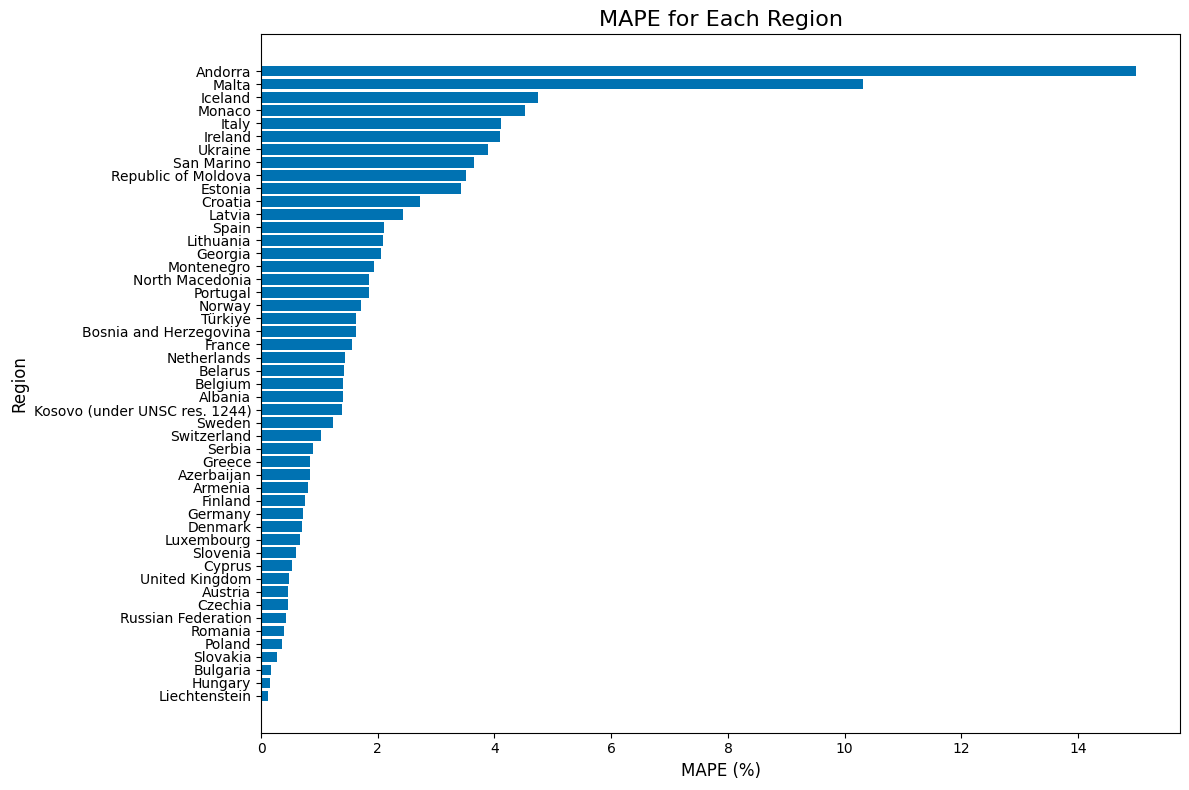

In [385]:
def plot_mape(test_results):

    test_results_sorted = test_results.sort_values(by="mape", ascending=True)

    color = "#0072B2"  

    plt.figure(figsize=(12, 8))
    plt.barh(test_results_sorted['region'], test_results_sorted['mape'], color=color, height=0.8)

    plt.xlabel('MAPE (%)', fontsize=12)
    plt.ylabel('Region', fontsize=12)
    plt.title('MAPE for Each Region', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_mape(test_results_df)

The results look very promising. The models seem to be performing quite well on the test sets. We can see a small tendency to less populated countries performing worse with Andorra, Malta, Iceland and Monaco being the countries with the worst testing results.

## Full Model + Predictions:

We now take the parameters and regressors from our grid search and apply it to the full data range for all countries. After that we try to predict the next 10 years.

In [386]:
def predict_with_best_models(data, prediction_window=10):

    logging.getLogger("cmdstanpy").setLevel(logging.WARNING) # turn off cmdstanpy messages
    logging.getLogger("cmdstanpy").setLevel(logging.ERROR) # turn off cmdstanpy messages

    predictions = []
    
    for _, row in data.iterrows():

        region = row["region"]
        params = eval(row["params"]) 
        regressors = eval(row["regressors"])  

        region_data = europe_data_prophet[europe_data_prophet["region"] == region].copy()
        prophet_data = region_data.drop(columns=["region"])

        model = Prophet(
            growth="linear",
            yearly_seasonality=False,
            weekly_seasonality=False,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            changepoint_range=params["changepoint_range"],
            interval_width=0.95,
            uncertainty_samples=1000)

        for reg in regressors:
            model.add_regressor(reg)

        model.fit(prophet_data)

        last_date = prophet_data["ds"].max()
        future_dates = pd.date_range(start=last_date, periods=prediction_window + 1, freq="YE")[1:] 
        future_dates = [date.replace(month=7, day=1) for date in future_dates] # correct the date changes the model makes

        future = pd.concat([prophet_data[["ds"]].copy(), pd.DataFrame({"ds": future_dates})], ignore_index=True)

        for reg in regressors:
            if reg in prophet_data.columns:
                future[reg] = pd.concat([prophet_data[reg], pd.Series([prophet_data[reg].iloc[-1]] * len(future_dates), index=range(len(prophet_data), len(future)))], ignore_index=True)
       
        forecast = model.predict(future)

        forecast["region"] = region
        predictions.append(forecast)

    combined_forecasts = pd.concat(predictions, ignore_index=True)

    return combined_forecasts

predictions = predict_with_best_models(best_params_per_region)

#predictions.to_csv("predictions_with_10_year_window.csv", index=False)


Now that we have our full models we can compare it to the original UN Data and also look at some UN predictions and see how our models perform in comparison to their predictions. For this we will first prepare the UN predictions and merge them with ours after that we can again look at the MAPE for the full historical and prediction data.

In [387]:
def prepare_un_pred(df, forecast):
    df_copy = df.copy()
    df_copy = df_copy[["Location", "Time", "TPopulation1July"]]

    df_copy.rename(columns={ "Location": "region", "Time": "ds",
        "TPopulation1July": "pop_predictions"}, inplace=True)
    df_copy["pop_predictions"] = pd.to_numeric(df_copy["pop_predictions"], errors="coerce")
    
    df_copy["ds"] = pd.to_numeric(df_copy["ds"], errors="coerce")  
    df_copy = df_copy.dropna(subset=["ds"])  
    df_copy["ds"] = df_copy["ds"].astype(int) 

    df_copy["ds"] = pd.to_datetime(df_copy["ds"], format="%Y")
    df_copy = df_copy.sort_values(by=["region", "ds"]).reset_index(drop=True)

    forecast_regions = forecast["region"].unique()
    df_copy = df_copy[df_copy["region"].isin(forecast_regions)]

    df_copy = df_copy[df_copy["ds"] <= "2033-07-01"]

    return df_copy


def merge_historical_un_pred(historical_df, un_pred):
    un_pred["ds"] = un_pred["ds"].apply(lambda x: pd.Timestamp(year=x.year, month=7, day=1))
    historical_df["ds"] = historical_df["ds"].apply(lambda x: pd.Timestamp(year=x.year, month=7, day=1))

    historical_df = historical_df.rename(columns={"y": "pop_predictions"})
    combined_df = pd.concat([historical_df, un_pred], ignore_index=True)
    combined_df = combined_df.sort_values(by=["region", "ds"]).reset_index(drop=True)

    return combined_df

def merge_forecast_pred(forecast, pred):

    merged = pd.merge( forecast[["ds", "region", "yhat", "yhat_lower", "yhat_upper"]], pred[["ds", "region", "pop_predictions"]], on=["ds", "region"], how="inner")

    # add statistics 
    merged["absolute_difference"] = (merged["yhat"] - merged["pop_predictions"]).abs()
    merged["percentage_difference"] = (merged["absolute_difference"] / merged["pop_predictions"]) * 100

    merged = merged.sort_values(by=["region", "ds"]).reset_index(drop=True)

    return merged

In [388]:
un_pred_prepped = prepare_un_pred(un_world_pop_predictions_df, predictions)
un_whole_prepped = merge_historical_un_pred(europe_data_prophet, un_pred_prepped)
combined_preds = merge_forecast_pred(predictions, un_whole_prepped)

In [389]:
def evaluate_performance(merged_df,range = "overall"):

    if range == "historical":
        merged_df = merged_df.loc[merged_df["ds"] < "2024-01-01"]
    elif range == "future":
         merged_df = merged_df.loc[merged_df["ds"] > "2024-01-01"]
    elif range == "overall":
        pass

    region_performance = (merged_df.groupby("region")["percentage_difference"].mean().reset_index().rename(columns={"percentage_difference": "mean_percentage_difference"}))

    sorted_performance = region_performance.sort_values(by="mean_percentage_difference")
    sorted_performance2 = region_performance.sort_values(by="mean_percentage_difference", ascending=False)
    best_regions = sorted_performance.head(5)
    worst_regions = sorted_performance2.head(5)

    print(f"Showing {range} performance:\n")
    print("Best 5 Regions:")
    print(best_regions)

    print("\nWorst 5 Regions:")
    print(worst_regions)

    return sorted_performance

historical_comparison = evaluate_performance(combined_preds, range="historical")

Showing historical performance:

Best 5 Regions:
            region  mean_percentage_difference
40          Serbia                    0.033134
48  United Kingdom                    0.039260
5          Belarus                    0.041583
41        Slovakia                    0.042877
15          France                    0.043950

Worst 5 Regions:
                           region  mean_percentage_difference
1                         Andorra                   10.542374
29                         Monaco                    1.763206
23  Kosovo (under UNSC res. 1244)                    1.655815
21                        Ireland                    0.686679
20                        Iceland                    0.577892


For the full range models Serbia and the United Kingdom perform the best with very minimal differences. The worst performing regions are Andorra (with a huge gap), followed by Monaco and the Kosovo. 

In [390]:
future_comparison = evaluate_performance(combined_preds, range="future")

Showing future performance:

Best 5 Regions:
            region  mean_percentage_difference
37         Romania                    0.170656
48  United Kingdom                    0.328916
9          Croatia                    0.349293
8         Bulgaria                    0.426738
19         Hungary                    0.460068

Worst 5 Regions:
       region  mean_percentage_difference
47    Ukraine                   16.349738
1     Andorra                   10.467807
22      Italy                    6.252136
26  Lithuania                    6.187545
29     Monaco                    6.181072


For the comparison to the UN predictions we can see Romania and the UK again on top, meaning our models come to the same conclusions as the UN prediction model. For the worst regions Ukraine is on top, which could be because our model prediction a bigger population decline because of the ongoing war. In second place is Andorra, which also did not have a good performance on historical data.

### Plotting the results:

In a last step we will plot our models and compare them visually to the UN data.

In [391]:
def plot_predictions(df, regions, start_year=1950, zoomed=False):
    
    # define palette (colorblind-friendly hopefully...)
    combined_color = "#CC6677"  
    prediction_color = "#117733"  
    uncertainty_color = "#88CCEE"  
    indicator_color = "#332288"  

    n_regions = len(regions)
    
    if n_regions > 4:
        cols = 5
    else:
        cols = n_regions
    
    rows = ceil(n_regions / cols)

    if n_regions == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
        axes = [axes]  
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), constrained_layout=True)
        axes = axes.flatten()  

    for i, region in enumerate(regions):
        region_data = df[(df["region"] == region) & (df["ds"].dt.year >= start_year)]

        # plot UN data
        axes[i].plot(region_data["ds"], region_data["pop_predictions"], color=combined_color, linewidth=1.5, alpha=0.6, label="UN Historical and Predictions")

        # plot model predictions
        axes[i].plot(region_data["ds"], region_data["yhat"], color=prediction_color, linewidth=1.5, alpha=0.8, label="Model Predictions")

        # plot uncertainty intervals of the model
        axes[i].fill_between(region_data["ds"], region_data["yhat_lower"], region_data["yhat_upper"], color=uncertainty_color, alpha=0.3)

        # vertical line where predictions start
        label = "Prediction Start" if start_year <= 2023 else None
        axes[i].axvline(pd.Timestamp(year=2023, month=7, day=1), color=indicator_color, linestyle="--", linewidth=0.5, label="Prediction Start")
        

        axes[i].set_title(region)
        axes[i].set_xlabel("Year")
        axes[i].set_ylabel("Population (thousands)")
        axes[i].legend()

        # set x-axis limits
        axes[i].set_xlim([pd.Timestamp(year=start_year, month=1, day=1), region_data["ds"].max()])
        axes[i].xaxis.set_major_locator(mdates.YearLocator(15))  
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

        # adjust y-axis limits for zooming
        if zoomed:
            min_pop = region_data[["yhat_lower", "yhat_upper", "pop_predictions"]].min().min()
            max_pop = region_data[["yhat_lower", "yhat_upper", "pop_predictions"]].max().max()
            axes[i].set_ylim([min_pop * 0.95, max_pop * 1.05])
            axes[i].xaxis.set_major_locator(mdates.YearLocator(int(floor(2033 - start_year)/5)))

    if n_regions > 1:
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    
    plt.suptitle(f"Population Forecasts and UN Projections by Region", fontsize=16, y=1.05)

    plt.show()

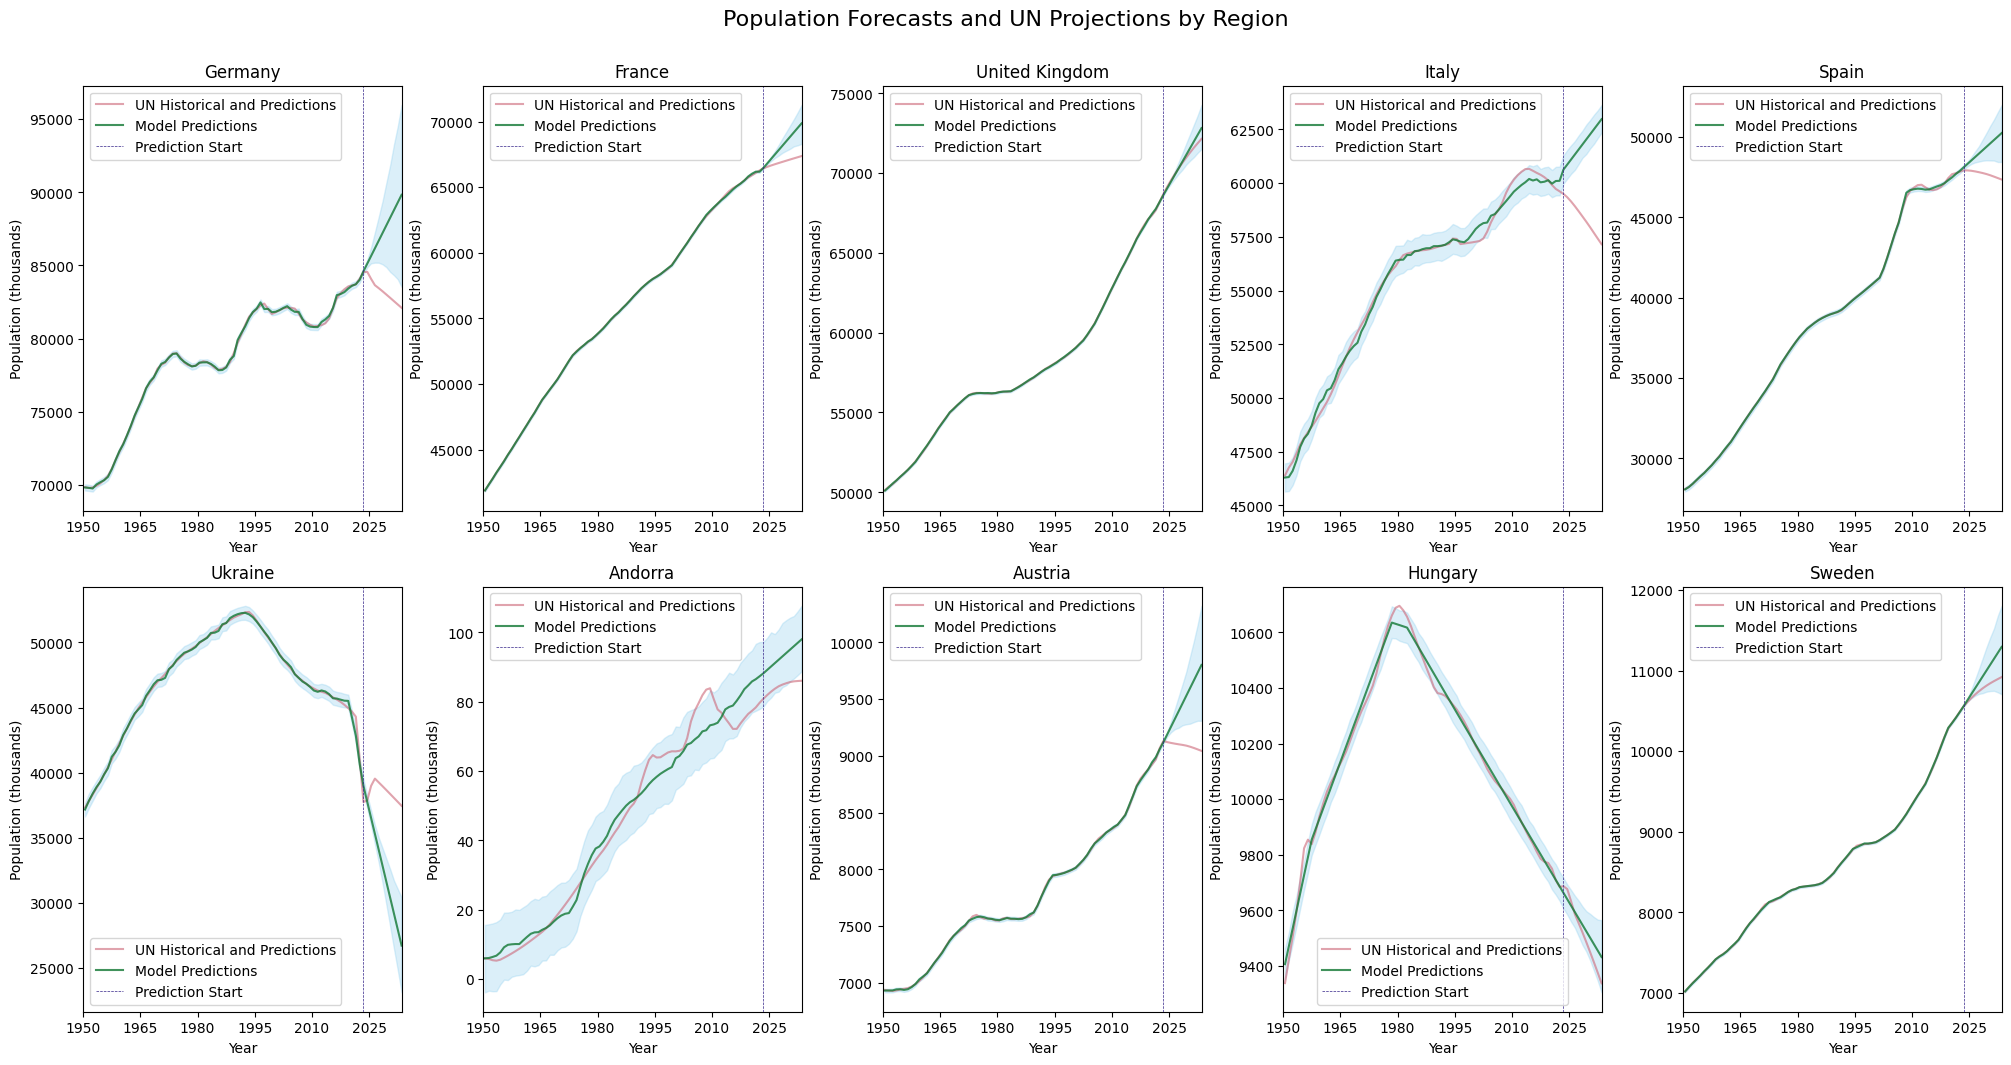

In [392]:
#regions = combined_preds["region"].unique() 
#plot_predictions(combined_preds, regions = regions, start_year=1950, zoomed=False)
plot_predictions(combined_preds, regions = ["Germany", "France", "United Kingdom", "Italy", "Spain","Ukraine","Andorra","Austria","Hungary","Sweden"], start_year=1950, zoomed=False)

In [393]:
#eastern_europe = ['Belarus', 'Bulgaria', 'Czechia', 'Hungary', 'Poland', 'Republic of Moldova', 'Romania','Russian Federation','Slovakia', 'Ukraine']
#northern_europe = ['Denmark', 'Estonia', 'Finland', 'Iceland', 'Ireland', 'Latvia', 'Lithuania', 'Norway', 'Sweden', 'United Kingdom']
#southern_europe = ['Albania', 'Andorra', 'Bosnia and Herzegovina', 'Croatia','Greece', 'Italy', 'Kosovo (under UNSC res. 1244)', 'Malta','Montenegro', 'North Macedonia', 'Portugal', 'San Marino','Serbia', 'Slovenia', 'Spain']
#western_europe = ['Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein','Luxembourg', 'Monaco', 'Netherlands', 'Switzerland']
#transcontinental_europe = ['Armenia', 'Azerbaijan', 'Cyprus', 'Georgia', 'Türkiye']
#all_regions = [eastern_europe, northern_europe, southern_europe, western_europe, transcontinental_europe]
#for region in all_regions:
#   plot_predictions(combined_preds, regions = region, start_year=1950, zoomed=False)

Here are some good, average and bad models visualized as a comparison. The plot for Germany shows a good historical alignment but disagree with the predictions. The same can be said for Spain, France and Austria. In the plot for Ukraine the before mentioned huge gap in predictions can be seen and for Andorra the not so well aligning model. On the other side the plots for Hungary, Sweden and the UK align well with the historical data and agree wel with the UN predictions.

## Summary and Conclusion

The models that we get by using Prophet are for the most part reasonable and work pretty well for how simple they are (population data + max. 3 regressors). Also a bad alignment with the UN predictions does not necessarily mean that the model is bad because there are no guarantees that the UN model is more right than ours. The questions from the beginning of this part can also be answered well with the models by obtaining a 10 year prediction for every country. 

### Key insights

Some key insights suggested by our models include:
- an overall population decline in Eastern Europe excluding Poland, Czechia and Slovakia
- a big increase in population for almost all Northern and Western countries
- decreasing numbers for Southern Europe with a tendency to more eastern suitated countries having a higher population decline

There are overall big difference in how the population changes for the different regions of Europe. Generally the models suggest that the population shifts to the northwest, with the main drivers likely being migration because of different reasons (e.g. climate change, war). 

### Potential Biases

Some biases in the modelling process could include that the Prophet model may oversimplify the population dynamics and it being (as it is trained now) not sensitive enough to quick changes our special events like seen in the case of the Ukraine. Considering factors like the COVID pandemic or the Ukraine war could improve the prediction quality of the models. Prophet also tends to assume the historical trend continuing, which could introduce inaccuracies in countries with rapid population changes.

### Data Science Tools learned

The valuable things learned during this modelling process include a better understanding on how to handle CV on time series data, how to (somewhat) handle the Prophet model and joblib for parallel computing and how to implement a predictive model for uncertain values.

# 3.2. Immigration Prediction

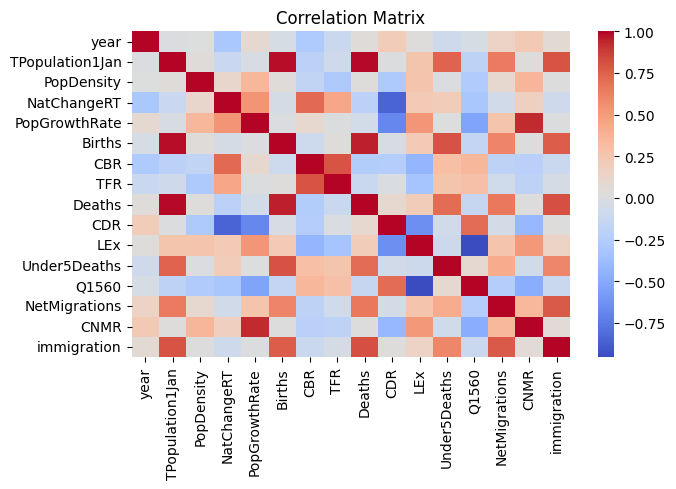


Processing Region: Eastern Europe
Best Parameters for Region Eastern Europe: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.2}
Evaluation Metrics for Eastern Europe Region:
Mean Absolute Error (MAE): 10.65
Mean Squared Error (MSE): 393.50
Root Mean Squared Error (RMSE): 19.84
R² Score: 0.92


c:\Users\fabci\TU\dopp\dopp_exercise_2_group_2\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but GradientBoostingRegressor was fitted without feature names



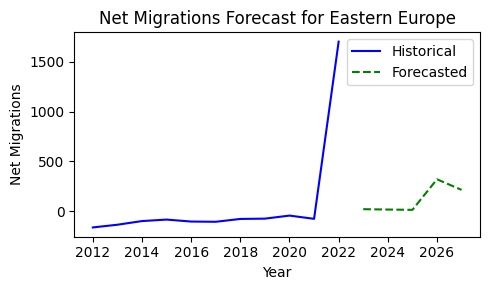


Processing Region: Northern Europe
Best Parameters for Region Northern Europe: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.05}
Evaluation Metrics for Northern Europe Region:
Mean Absolute Error (MAE): 4.40
Mean Squared Error (MSE): 43.08
Root Mean Squared Error (RMSE): 6.56
R² Score: 0.94


c:\Users\fabci\TU\dopp\dopp_exercise_2_group_2\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but GradientBoostingRegressor was fitted without feature names



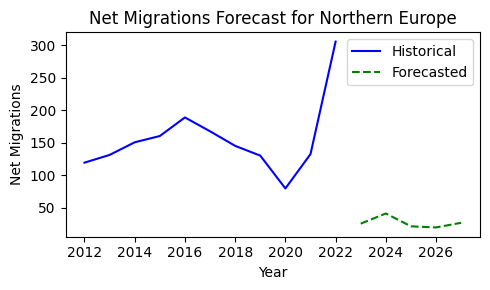


Processing Region: Southern Europe
Best Parameters for Region Southern Europe: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.2}
Evaluation Metrics for Southern Europe Region:
Mean Absolute Error (MAE): 34.00
Mean Squared Error (MSE): 3099.58
Root Mean Squared Error (RMSE): 55.67
R² Score: 0.62


c:\Users\fabci\TU\dopp\dopp_exercise_2_group_2\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but GradientBoostingRegressor was fitted without feature names



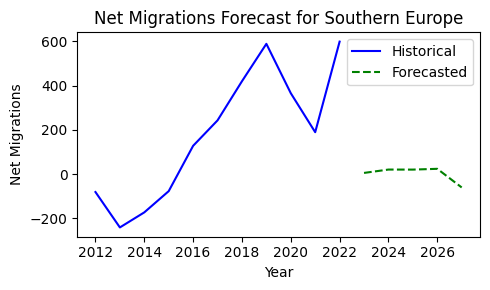


Processing Region: Western Europe
Best Parameters for Region Western Europe: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.05}
Evaluation Metrics for Western Europe Region:
Mean Absolute Error (MAE): 18.30
Mean Squared Error (MSE): 1366.85
Root Mean Squared Error (RMSE): 36.97
R² Score: 0.91


c:\Users\fabci\TU\dopp\dopp_exercise_2_group_2\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but GradientBoostingRegressor was fitted without feature names



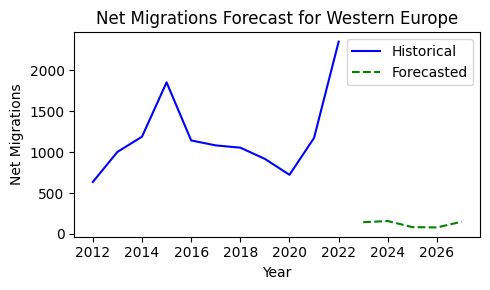


Forecasts for the Next 5 Years (Net Migrations):
Eastern Europe Region: [ 20.98512974  17.30048745  14.25192171 320.99444982 214.58662827]
Northern Europe Region: [25.83474495 41.4578231  21.69434184 19.99554757 27.10991483]
Southern Europe Region: [  5.30268376  20.51976134  20.32067153  23.8751861  -60.32051847]
Western Europe Region: [143.08429972 157.25807244  82.79076994  79.1201633  148.56211533]


In [394]:
data = joined_data.reset_index().drop(columns=['country'])

# Preprocessing
data = data.drop(columns=["employment_rate", "gdp", "crimes", "crimes_adjusted", "hdi"])  # Drop irrelevant columns
data = data.dropna(subset=["NetMigrations", "Location", "year"])  # Ensure no missing values in critical columns
numeric_columns = data.select_dtypes(include=[np.number])
data[numeric_columns.columns] = data[numeric_columns.columns].fillna(data[numeric_columns.columns].mean())

# Add Regions
regions = {
    "Northern Europe": ["Norway", "Sweden", "Denmark", "Finland", "Iceland", "Latvia", "Estonia"],
    "Southern Europe": ["Spain", "Italy", "Greece", "Portugal", "Cyprus", "Bosnia and Herzegovina", "Croatia", "Malta", "Montenegro", "North Macedonia", "Slovenia"],
    "Western Europe": ["France", "Germany", "Netherlands", "Belgium", "United Kingdom", "Switzerland", "Luxembourg", "Liechtenstein", "Ireland", "Austria"],
    "Eastern Europe": ["Poland", "Czechia", "Slovakia", "Hungary", "Romania", "Azerbaijan", "Armenia", "Georgia", "Belarus", "Bulgaria", "Republic of Moldova"],
}
data["Region"] = data["Location"].apply(
    lambda x: next((region for region, countries in regions.items() if x in countries), None)
)

# Filter out rows with Region as None (ignoring "Other" sector)
data = data[data["Region"].notna()]

# Correlation Matrix
plt.figure(figsize=(7, 5))
correlation_matrix = data[numeric_columns.columns].corr()
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Prepare data for modeling
features = ["year", "PopGrowthRate", "Births", "Deaths", "TFR", "PopDensity", "NatChangeRT"]
target = "NetMigrations"
grouped_data = data.groupby("Region")
predictions = {}

for region, group in grouped_data:
    print(f"\nProcessing Region: {region}")

    # Aggregate historical NetMigrations by year for the region
    historical_aggregated = group.groupby("year")["NetMigrations"].sum().reset_index()

    # Prepare feature matrix and target variable for individual countries
    X = group[features]
    y = group[target]

    # Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Randomized Search for Hyperparameter Tuning
    param_dist = {
        "n_estimators": [100, 200, 300, 400],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7, 9],
        "subsample": [0.8, 0.9, 1.0],
        "min_samples_split": [2, 5, 10],
    }
    random_search = RandomizedSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=50,
        scoring="neg_mean_squared_error",
        cv=5,  # Increased cross-validation folds
        random_state=42,
        verbose=0,  # Suppress verbose output
    )
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print(f"Best Parameters for Region {region}:", best_params)

    # Train Final Model
    model = GradientBoostingRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the Model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Evaluation Metrics for {region} Region:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Ensure X_train is handled as a DataFrame for feature access
    feature_columns = ["year", "PopGrowthRate", "Births", "Deaths", "TFR", "PopDensity", "NatChangeRT"]
    if not isinstance(X_train, pd.DataFrame):
        X_train_df = pd.DataFrame(X_train, columns=feature_columns)
    else:
        X_train_df = X_train

    # Generate realistic future feature projections
    future_years = pd.DataFrame({
        "year": [2023, 2024, 2025, 2026, 2027],
        "PopGrowthRate": np.linspace(X_train_df["PopGrowthRate"].mean(), X_train_df["PopGrowthRate"].max(), 5),
        "Births": np.linspace(X_train_df["Births"].mean(), X_train_df["Births"].max(), 5),
        "Deaths": np.linspace(X_train_df["Deaths"].mean(), X_train_df["Deaths"].min(), 5),
        "TFR": np.linspace(X_train_df["TFR"].mean(), X_train_df["TFR"].max(), 5),
        "PopDensity": np.linspace(X_train_df["PopDensity"].mean(), X_train_df["PopDensity"].max(), 5),
        "NatChangeRT": np.linspace(X_train_df["NatChangeRT"].mean(), X_train_df["NatChangeRT"].max(), 5),
    })

    # Predict future NetMigrations values
    forecasts = model.predict(future_years)

    # Store and visualize predictions
    predictions[region] = forecasts

    plt.figure(figsize=(5, 3))

    # Plot aggregated historical NetMigrations for the region
    plt.plot(
        historical_aggregated["year"],
        historical_aggregated["NetMigrations"],
        label="Historical",
        color="blue"
    )
    plt.plot(
        future_years["year"],
        forecasts,
        label="Forecasted",
        color="green",
        linestyle="--"
    )
    plt.title(f"Net Migrations Forecast for {region}")
    plt.xlabel("Year")
    plt.ylabel("Net Migrations")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Display Predictions
print("\nForecasts for the Next 5 Years (Net Migrations):")
for region, forecast in predictions.items():
    print(f"{region} Region: {forecast}")


In [395]:
# Fine-tune hyperparameters for the "south" region
south_params = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.05, 0.1, 0.15],
    "max_depth": [5, 7, 9],
    "min_samples_split": [5, 10],
    "subsample": [0.8, 0.9],
}

# Filter the "south" region data
south_data = data[data["Region"] == "Southern Europe"]
X_south = south_data[features]
y_south = south_data[target]

# Scale features
scaler = StandardScaler()
X_south_scaled = scaler.fit_transform(X_south)

# Train-test split
X_train_south, X_test_south, y_train_south, y_test_south = train_test_split(
    X_south_scaled, y_south, test_size=0.2, random_state=42
)

# Grid Search CV for south region
south_model = GradientBoostingRegressor(random_state=42)
grid_search_south = GridSearchCV(
    estimator=south_model,
    param_grid=south_params,
    scoring="r2",
    cv=5,
    verbose=0,
)
grid_search_south.fit(X_train_south, y_train_south)

# Train and evaluate the best model
best_south_model = grid_search_south.best_estimator_
y_pred_south = best_south_model.predict(X_test_south)

# Evaluation metrics for the south region
mae_south = mean_absolute_error(y_test_south, y_pred_south)
mse_south = mean_squared_error(y_test_south, y_pred_south)
rmse_south = np.sqrt(mse_south)
r2_south = r2_score(y_test_south, y_pred_south)

print(f"Improved Evaluation Metrics for South Region:")
print(f"Mean Absolute Error (MAE): {mae_south:.2f}")
print(f"Mean Squared Error (MSE): {mse_south:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_south:.2f}")
print(f"R² Score: {r2_south:.2f}")


Improved Evaluation Metrics for South Region:
Mean Absolute Error (MAE): 28.43
Mean Squared Error (MSE): 2350.41
Root Mean Squared Error (RMSE): 48.48
R² Score: 0.71


1. Why I chose this dataset?

The dataset was chosen because it includes key demographic features such as population growth rate, births, total fertility rate (TFR), population density, natural change rate, and net migrations across European regions over multiple years. These features are highly relevant for analyzing and predicting migration trends, which is the core objective of the project. Furthermore, the data spans multiple years and regions, allowing for regional and temporal analysis.


2. How did you clean/transform the data? Why?
   
Cleaning Steps:

•	Dropped irrelevant columns: Columns like "employment_rate," "gdp," "crimes," etc., were dropped because they did not contribute directly to the objective of predicting net migrations.

•	Filtered null values: Ensured no missing values in key columns such as "NetMigrations," "Location," and "Year" to avoid errors during modeling.

•	Region classification: Grouped countries into regions (e.g., Northern Europe, Southern Europe) for regional analysis.

Transformation:

•	Imputed missing values: Numeric columns were filled with mean values to ensure the completeness of the data.

•	Standardized the features: Applied StandardScaler to scale the features for better model performance.

These steps ensured that the data was consistent, relevant, and prepared for analysis without introducing bias from missing or irrelevant information.


3. How did you solve the problem of missing values? Why?
   
Missing values in numeric columns were replaced with the mean of the respective columns. This approach was used because It retains the dataset's overall distribution. Also it avoids introducing bias that could arise from other imputation methods (e.g., forward fill, backward fill).


4. What questions did you ask of the data? Why were these good questions?
   
The questions asked of the data were designed to address the core objective of the analysis—predicting migration patterns—by focusing on regional trends, identifying influential features, and assessing the impact of historical trends on forecasts.

How do net migrations vary by region and year?
This question aimed to uncover migration patterns over time across different regions. By analyzing variations by region and year, we could identify regions with significant migration inflows or outflows, understand temporal dynamics, and detect potential migration hotspots. This information is critical for tailoring region-specific policy interventions and identifying global migration trends. It also establishes a foundation for accurate forecasting by aligning historical observations with future predictions.

What features (e.g., population growth rate, TFR) have the strongest correlation with net migrations?
Understanding which factors most strongly correlate with net migrations helps identify the key drivers of migration. This question enables the creation of a more focused and accurate predictive model by emphasizing features like population growth rate and total fertility rate (TFR), which are directly linked to demographic changes. Analyzing feature importance also provides actionable insights into how social, economic, and demographic variables influence migration patterns, offering a pathway for evidence-based decision-making.

How do historical trends influence future forecasts?
Historical trends serve as a baseline for predictive analysis. This question ensures that the model accounts for past behaviors while identifying the limitations of solely relying on historical data. It helps assess the stability of migration patterns and detect anomalies or disruptions. By understanding the extent to which historical trends shape predictions, the analysis remains transparent about its reliance on past data and prepares for scenarios where abrupt policy or economic changes might alter these patterns.

These questions were essential because they targeted the fundamental aspects of migration analysis, including identifying trends, evaluating feature importance, and gauging data reliability. They ensured that the analysis remained comprehensive, actionable, and aligned with the goal of providing valuable insights for policymakers and stakeholders.

5. What were the answers to these questions? How did you obtain them?

Regional Trends: The analysis highlighted clear regional differences in net migrations. Northern and Western Europe consistently exhibited higher net migration levels compared to Southern and Eastern Europe. This trend was visualized using time-series plots, which displayed historical migration patterns and forecasted values for each region. These visualizations revealed that Northern and Western Europe remain attractive destinations for migrants, likely due to their robust economies, higher standards of living, and favorable policies. In contrast, Southern and Eastern Europe showed lower migration levels, reflecting economic disparities and differing migration dynamics.

Feature Importance: By performing correlation analysis, we identified key predictors of migration. The population growth rate (PopGrowthRate) and Total Fertility Rate (TFR) emerged as particularly influential features in explaining migration trends. Regions with higher growth rates and favorable fertility levels tended to have higher migration inflows, indicating the interplay between demographic factors and migration. This understanding helped refine the forecasting models by emphasizing the most relevant features, thereby improving the model's predictive power.

Forecasts: The forecasting models provided insights into potential future migration trends. While some regions, such as Western Europe, showed stable or increasing trends, others, like Northern Europe, indicated a potential decrease in net migration levels. These forecasts were derived using Gradient Boosting Regressor models, fine-tuned for each region to capture region-specific patterns. The projected decrease in Northern Europe, for instance, might reflect a saturation of migration inflows or policy changes, while steady growth in Western Europe suggests sustained economic opportunities and migrant-friendly environments.

By combining these insights, we obtained a comprehensive understanding of migration patterns across Europe, which can inform policy and planning. The use of data visualizations and region-specific models ensured that the findings were interpretable and actionable for stakeholders.

6. Do the answers make sense?

Yes, the answers make sense as they align with established migration patterns and demographic dynamics. Northern and Western Europe have historically been attractive destinations for migrants due to their strong economies, higher living standards, and greater job opportunities. These regions tend to offer better infrastructure, social welfare systems, and political stability, which are significant pull factors for migration. Additionally, the relationship between population growth, fertility rates, and migration trends is logical. Regions with low natural population growth or aging populations, such as many Northern and Western European countries, often rely on migration to sustain their workforce and economic growth. Conversely, regions with high fertility rates and limited economic opportunities may experience emigration as people seek better prospects elsewhere. These observations support the validity of the model’s outcomes, reinforcing its alignment with real-world migration trends and demographic behaviors.

7. Were there any difficulties in analyzing the data?

There were several challenges encountered while analyzing the data. First, imbalanced regional data posed a significant difficulty. Certain regions, such as Northern Europe, had fewer data points compared to others, which limited the model's ability to learn patterns effectively for those regions. This imbalance likely stemmed from a lack of consistent or comprehensive data collection across all regions, making it harder to create a robust and uniform model for all areas. In contrast, regions with more abundant data provided richer patterns for analysis, highlighting the disparity in data quality and quantity across different regions.

Second, model performance presented another challenge, especially when striving to achieve high R² scores for all regions. Southern Europe, in particular, required extensive hyperparameter tuning and experimentation with model configurations to improve its prediction accuracy. This process involved fine-tuning parameters such as the learning rate, maximum tree depth, and the number of estimators, which was both time-consuming and computationally intensive. Despite these efforts, achieving consistent performance across all regions remained difficult due to the variability in migration trends and underlying factors influencing them. 

8. What were the key insights obtained?

The key insights obtained from the analysis reveal significant regional variations in net migrations across Europe, with notable differences in trends and migration levels among regions. Predictors such as population growth rate and total fertility rate (TFR) emerged as strong influencers of migration patterns, underlining their critical role in shaping migration trends. While historical data indicated increases in migration for certain regions, the forecasted trends suggest stagnation or even decline in some areas, likely driven by economic changes or policy interventions, emphasizing the importance of regional-specific strategies to address migration challenges effectively.

9. What are potential biases in the data and analysis?

Potential biases in the data and analysis include the lack of socioeconomic factors like GDP and employment rates, which are significant drivers of migration. Additionally, the reliance on historical data for forecasting introduces a historical bias, as predictions are based on past trends and may fail to capture sudden changes in migration dynamics due to shifts in policies, economic conditions, or global crises, limiting the model's adaptability to unforeseen events.

10. Which Data Science tools and techniques were learned during this exercise?

During this exercise, several Data Science tools and techniques were explored and applied, providing valuable learning opportunities.

Tools: Python was the primary programming language used, with libraries such as pandas for data manipulation, numpy for numerical computations, seaborn and matplotlib for data visualization, and scikit-learn for implementing machine learning models and evaluating their performance. These libraries offered a comprehensive suite of functionalities for handling data, building models, and analyzing results effectively.

Techniques: A variety of critical Data Science techniques were employed. Data cleaning and preprocessing were essential for preparing the dataset by removing irrelevant columns, handling missing values, and ensuring the dataset was ready for analysis. Feature scaling was performed using StandardScaler to normalize the data and ensure that features with different scales did not disproportionately impact the model's performance. Advanced hyperparameter tuning was applied using RandomizedSearchCV and GridSearchCV to optimize the Gradient Boosting Regressor by identifying the best parameter combinations, improving the accuracy and robustness of predictions. Finally, model performance was assessed using evaluation metrics such as R² (coefficient of determination) to measure goodness-of-fit, MAE (Mean Absolute Error) for average error quantification, and RMSE (Root Mean Squared Error) for penalizing larger errors more significantly.

These tools and techniques provided a well-rounded approach to data-driven problem-solving, combining rigorous preprocessing, machine learning, and comprehensive evaluation to derive meaningful insights from the data.

# Final Words and Learnings

Throughout this exercise we were able to improve our programming skills in python, especially in common libraries used in the data science community such as numpy, pandas or matplotlib. Fruthermore, we were able get better insights into the world of machine learning as we were experimenting with different models, such as prophet and parameters.

The freedom of the exercise to choose a question and having to select the datasets has also been a very valuable part, as it teached us how to correctly approach data science questions. After all we can say that selecting data sets is more difficult than it seems.